# TAREAS 

**Tomando el archivo que habéis simulado para la tarea final del bloque 1 de programación, o con el ejemplo_simulacion.json que os proporcionó el profesor en este bloque si tuvisteis algún problema. Debéis realizar los siguientes ejercicios:** 

**- Extracción de los datos del archivo JSON**


Este trabajo se esta realizando con Visual Studio Code, con un kernel basado en Python 3.12.0

In [1]:
# En este código iremos importando las librerias necesarias
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
# habría que cambiar el path dependiendo de la máquina desde donde se corra el código

with open("result.json", "r") as read_file:
  data = json.load(read_file)
print(data.keys())
equipos_liga = data['teams']
partidos_liga = data['matches']
clasificacion_liga = data['classification']

dict_keys(['teams', 'matches', 'classification'])


El fichero json que se nos ha proporcinado lo hemos leido y guardado en el objeto llamado 'data', que es un objeto del tipo dict, que tiene tres elementos; 'teams','matches' y 'classification'

Hemos comprobado que lo ha leido correctamente a nivel de codificación.


- Creación de un BoxScore para cada uno de los partidos contenidos en el archivo de datos. 
  
  - Crea una función cuya variable de entrada sean los datos de un partido y cuyo output sea el boxscore del partido con las columnas necesarias para el cálculo de estadísticas. Necesario añadir el tiempo jugado. 
  
  **Si deseas trabajar con varias simulaciones, un ejercicio a valorar sería el de la creación de un CSV que contenga los resultados finales de cada partido (home team, away team, puntos, PA2, PA3, TO…). Una forma de llevarlo a cabo puede ser utilizando las funciones de groupby sobre el boxscore del partido y añadiendo este registro con todos los campos necesarios a un nuevo DataFrame que posteriormente guardaremos como CSV. Podríais crear un bucle que iterase sobre los partidos y fuese añadiendo esta línea al DataFrame.**


In [3]:
# vamos a extraer que posibles acciones hay en un partido
# para eso recorremos todos los partidos y extraemos que posibles acciones hay
claves = data['matches'][0].keys()
acciones = []
i = 0
j = 0
data['matches'][i]['play_by_play'][j]['action']
for i in range(len(data['matches'])):
    for j in range(len(data['matches'][i]['play_by_play'])):
        acciones.append(data['matches'][i]['play_by_play'][j]['action'])
acciones = list(set(acciones))


Definimos una función para obtener el tiempo que ha jugado cada jugador en un partido. Recorrerremos el play_by_play, en cada momento controlaremos que jugador esta en el campo y le sumaremos los segundos que va consumiendo cada jugada. Devolveremos un data.frame en el que aparece el nombre del jugador, el equipo al que pertenece y el tiempo de juego consumido

In [4]:

def obtenerTiemposDeJuego(partido):
    tiempo_possesion_local = {jugador['name']: {'Tiempo': 0, 'team': partido['home_team']['team_name']} for jugador in partido['home_team']['players']}
    tiempo_possesion_visitante = {jugador['name']: {'Tiempo': 0, 'team': partido['away_team']['team_name']} for jugador in partido['away_team']['players']}

    jugadores_actuales_local = set()
    jugadores_actuales_visitante = set()

    for idx, jugada in enumerate(partido['play_by_play']):
        if 'current_players' in jugada:
            jugadores_actuales_local = {jugador['name'] for jugador in jugada['current_players'][partido['home_team']['team_name']]}
            jugadores_actuales_visitante = {jugador['name'] for jugador in jugada['current_players'][partido['away_team']['team_name']]}

        if 'possesion_time' in jugada:
            for jugador in jugadores_actuales_local:
                tiempo_possesion_local[jugador]['Tiempo'] += jugada['possesion_time']
                if idx == len(partido['play_by_play']) - 1 or (jugada['quarter'] != partido['play_by_play'][idx+1]['quarter']):
                    tiempo_possesion_local[jugador]['Tiempo'] += jugada['time_remaining']

            for jugador in jugadores_actuales_visitante:
                tiempo_possesion_visitante[jugador]['Tiempo'] += jugada['possesion_time']
                if idx == len(partido['play_by_play']) - 1 or (jugada['quarter'] != partido['play_by_play'][idx+1]['quarter']):
                    tiempo_possesion_visitante[jugador]['Tiempo'] += jugada['time_remaining']

    dfTiempoJuego_local = pd.DataFrame([(jugador, tiempo['Tiempo'], tiempo['team']) for jugador, tiempo in tiempo_possesion_local.items()], columns=['player', 'Tiempo', 'team'])
    dfTiempoJuego_visitante = pd.DataFrame([(jugador, tiempo['Tiempo'], tiempo['team']) for jugador, tiempo in tiempo_possesion_visitante.items()], columns=['player', 'Tiempo', 'team'])

    dfTiempoJuego = pd.concat([dfTiempoJuego_local, dfTiempoJuego_visitante], ignore_index=True)
    dfTiempoJuego['home_team_name'] = partido['home_team']['team_name']
    dfTiempoJuego['away_team_name'] = partido['away_team']['team_name']
    
    return dfTiempoJuego

In [5]:
# Este codigo me comprueba que ha realizado bien la suma de todos los tiempos (tiene que salir 24000 = 600 segundos  * 4 cuartos * 10 jugadores en pista)
for idx, partido in enumerate(data['matches']):
    #print(partido['away_team'])
    print(f"Partido {idx}")
    resultado = obtenerTiemposDeJuego(partido)
    print(resultado)
    #print(sum(resultado['Tiempo']))
    print(sum(obtenerTiemposDeJuego(partido)['Tiempo']))


Partido 0
                  player  Tiempo                team     home_team_name  \
0          Calixta Farré    1892   Lobos de Albacete  Lobos de Albacete   
1             Gema Palau    2141   Lobos de Albacete  Lobos de Albacete   
2       Angélica Vallejo    1467   Lobos de Albacete  Lobos de Albacete   
3            Elena Valle    1863   Lobos de Albacete  Lobos de Albacete   
4        Adoración Ariño    2097   Lobos de Albacete  Lobos de Albacete   
5           Blanca Leiva     349   Lobos de Albacete  Lobos de Albacete   
6            Anna Catalá     497   Lobos de Albacete  Lobos de Albacete   
7          Manola Andres     346   Lobos de Albacete  Lobos de Albacete   
8   Evangelina Calatayud       0   Lobos de Albacete  Lobos de Albacete   
9       Concepción Acedo     149   Lobos de Albacete  Lobos de Albacete   
10          Lorena Mateo      97   Lobos de Albacete  Lobos de Albacete   
11        Vilma Benavent    1102   Lobos de Albacete  Lobos de Albacete   
12     Anastasi

Definimos una función para obtener el play_by_play crudo para un partido. Dentro de esta función haremos una llamada a la función para obtener los tiempos de juego.

In [6]:
# El objeto play_by_play de un partido es del tipo 'list'
# Esta funcion a partid de un objeto del tipo 'partido' obtendremos el boxplot que denominaremos crudo con las jugadas tal cual aparecen en el fichero json
# le pasamos 
def obtenerBoxplotCrudo(partido):
    play_by_play_partido = partido['play_by_play']
    # Extraemos la informacion del tipo de accion, el equipo que la realiza y el jugador
    extracted_data = [{'action': item['action'], 'team': item['team'], 'player': item.get('player', '')} for item in play_by_play_partido]
    # Esa información lo convertimos a un data frame de pandas
    df = pd.DataFrame(extracted_data)
    # Tenemos que filtrar y eliminar las acciones del tipo 'possesion' porque tal cual se ha generado no tiene jugador asociado y change
    filtered_df = df.loc[~df['action'].isin(['possesion', 'Change'])]
    # print(filtered_df)
    # Comprobamos que todas las acciones son las que necesitamos para generar el boxplot inicial.
    #print(filtered_df['action'].drop_duplicates().sort_values())
    # A partir de este data frame tenemos que obtener el boxplot, que es el conteo de acciones por equipo y jugador
    # Este boxplot es interesante porque vamos a obtener para algunas acciones del juego mas informacion que la que habitualmente se muestra en los boxplot, como si la falta defensiva implica o no tiros
    # o si un jugador acierta o falla mas el primer tiro libre, el segundo o el tercero
    # Aunque luego simplifiquemos el boxplot dejandolo en el tradicional
    conteo_por_equipo= filtered_df.groupby(['team','player','action']).size().reset_index(name='conteo')
    #print(conteo_por_equipo)
    boxplot_inicial = conteo_por_equipo.pivot_table(index=['team','player'], columns='action', values='conteo', fill_value=0).reset_index(['team','player'])
    boxplot_inicial['home_team_name'] = partido['home_team']['team_name']
    boxplot_inicial['away_team_name'] = partido['away_team']['team_name']
    acciones_filtradas = [accion for accion in acciones if accion not in ['Change', 'possesion']]
    acciones_presentes = boxplot_inicial.columns
    acciones_faltantes = set(acciones_filtradas) - set(acciones_presentes)
    for accion in acciones_faltantes:
        boxplot_inicial[accion] = 0
    boxplot_inicial = boxplot_inicial[['team','player','home_team_name','away_team_name']+acciones_filtradas]
    # obtenemos los tiempos de juego de cada jugadora en este partido 
    tiempoJuego = obtenerTiemposDeJuego(partido)
    #print(tiempoJuego)
    # y los unimos los dos data frames a través de la columna player
    result = pd.merge(boxplot_inicial, tiempoJuego, on=["player","team","home_team_name","away_team_name"],how='outer')
    columnas_numericas = result.select_dtypes(include='number').columns
    # Llenamos los valores NaN de las columnas numéricas con ceros
    result[columnas_numericas] = result[columnas_numericas].fillna(0)

    return(result)



In [7]:
partido = data['matches'][0]
#print(partido)
aux = obtenerBoxplotCrudo(partido)
aux

,team,player,home_team_name,away_team_name,2_of_2_free_throw_miss,1_of_2_free_throw_made,turnover,offensive_rebound,3_point_shot_made,2_point_shot_made,...,deffensive_foul_3_point_shot_attempt,3_of_3_free_throw_made,defensive_rebound,3_point_shot_miss,offensive_foul,deffensive_foul_non_shot,1_of_3_free_throw_miss,2_of_3_free_throw_miss,deffensive_foul_2_point_shot_attempt,Tiempo
0,Lobos de Albacete,Adoración Ariño,Lobos de Albacete,Gaviotas de Coruña,0.0,3.0,2.0,1.0,0.0,1.0,...,1.0,0.0,2.0,2.0,1.0,3.0,0.0,0.0,2.0,2097
1,Gaviotas de Coruña,Alejandra Corral,Lobos de Albacete,Gaviotas de Coruña,0.0,1.0,1.0,1.0,0.0,2.0,...,0.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,6.0,1897
2,Gaviotas de Coruña,Anastasia Colomer,Lobos de Albacete,Gaviotas de Coruña,1.0,3.0,0.0,1.0,0.0,1.0,...,0.0,2.0,4.0,1.0,2.0,2.0,1.0,1.0,1.0,2400
3,Lobos de Albacete,Angélica Vallejo,Lobos de Albacete,Gaviotas de Coruña,3.0,1.0,0.0,1.0,1.0,1.0,...,2.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,3.0,1467
4,Lobos de Albacete,Anna Catalá,Lobos de Albacete,Gaviotas de Coruña,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,1.0,497
5,Gaviotas de Coruña,Anna Rocamora,Lobos de Albacete,Gaviotas de Coruña,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,241
6,Gaviotas de Coruña,Anunciación Noguera,Lobos de Albacete,Gaviotas de Coruña,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,Gaviotas de Coruña,Arcelia Jover,Lobos de Albacete,Gaviotas de Coruña,1.0,2.0,2.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1238
8,Lobos de Albacete,Blanca Leiva,Lobos de Albacete,Gaviotas de Coruña,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,349
9,Lobos de Albacete,Calixta Farré,Lobos de Albacete,Gaviotas de Coruña,1.0,2.0,0.0,1.0,0.0,4.0,...,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,2.0,1892


In [8]:
# En esta función vamos a hacer un tratamiento que lo podiamos hacer ahora o en el paso de observar los valores anomalos
# Por como se programo el ejercicio, un jugador podia tener mas de 5 faltas personales, para hacerlo mas realista
# Si el valor del total de faltas personales es mayor de 5, lo reemplazaremos por 5
# El valor del suma_deffensive_foul y el valor de offensive_foul lo recalcularemos en función del porcentaje original de dichas faltas.


def obtenerBoxPlotEstadisticas(boxplotCrudo):
    boxplot_estadisticas = boxplotCrudo.copy()
    columnas_free_throw_made = boxplot_estadisticas.columns[boxplot_estadisticas.columns.str.endswith('free_throw_made')]
    columnas_free_throw_miss = boxplot_estadisticas.columns[boxplot_estadisticas.columns.str.endswith('free_throw_miss')]
    columnas_deffensive_foul = boxplot_estadisticas.columns[boxplot_estadisticas.columns.str.startswith('deffensive_foul')]
    boxplot_estadisticas['suma_free_throw_made'] = boxplot_estadisticas.filter(columnas_free_throw_made).sum(axis=1)
    boxplot_estadisticas['suma_free_throw_miss'] = boxplot_estadisticas.filter(columnas_free_throw_miss).sum(axis=1)
    boxplot_estadisticas['suma_deffensive_foul'] = boxplot_estadisticas.filter(columnas_deffensive_foul).sum(axis=1)
    #print(boxplot_estadisticas.columns)
    nombre_de_columnas_mostrar = ['home_team_name','away_team_name','team','player','Tiempo','2_point_shot_made','2_point_shot_miss','3_point_shot_made','3_point_shot_miss','suma_free_throw_made','suma_free_throw_miss',
                                    'offensive_rebound','defensive_rebound', 'offensive_foul','suma_deffensive_foul','turnover']
    # Calculamos los diferentes estadísticos básicos que se pueden calcular a partir del boxscore que hemos obtenido del play_by_play
    boxplot_estadisticas=boxplot_estadisticas.loc[:,nombre_de_columnas_mostrar]
    boxplot_estadisticas['2_point_shot_attempted'] = boxplot_estadisticas['2_point_shot_made']+boxplot_estadisticas['2_point_shot_miss']
    boxplot_estadisticas['3_point_shot_attempted'] = boxplot_estadisticas['3_point_shot_made']+boxplot_estadisticas['3_point_shot_miss']
    boxplot_estadisticas['free_throw_attempted'] = boxplot_estadisticas['suma_free_throw_made']+boxplot_estadisticas['suma_free_throw_miss']
    boxplot_estadisticas['total_rebounds'] = boxplot_estadisticas['defensive_rebound']+boxplot_estadisticas['offensive_rebound']
    boxplot_estadisticas['total_foul'] = boxplot_estadisticas['suma_deffensive_foul']+boxplot_estadisticas['offensive_foul']
    boxplot_estadisticas['2_point_shot_percentage'] = boxplot_estadisticas['2_point_shot_made']/boxplot_estadisticas['2_point_shot_attempted'] * 100
    boxplot_estadisticas['3_point_shot_percentage'] = boxplot_estadisticas['3_point_shot_made']/boxplot_estadisticas['3_point_shot_attempted'] * 100
    boxplot_estadisticas['free_throw_percentage'] = boxplot_estadisticas['suma_free_throw_made']/boxplot_estadisticas['free_throw_attempted'] * 100
    boxplot_estadisticas['Tiempo_minutos'] = boxplot_estadisticas['Tiempo']/60
    boxplot_estadisticas['OR_percentage'] = boxplot_estadisticas['offensive_rebound']/boxplot_estadisticas['total_rebounds'] * 100
    boxplot_estadisticas['DR_percentage'] = boxplot_estadisticas['defensive_rebound']/boxplot_estadisticas['total_rebounds'] * 100
    boxplot_estadisticas['OFP_percentage'] = boxplot_estadisticas['offensive_foul']/boxplot_estadisticas['total_foul'] 
    boxplot_estadisticas['DFP_percentage'] = boxplot_estadisticas['suma_deffensive_foul']/boxplot_estadisticas['total_foul']
    boxplot_estadisticas['PTS'] = 2*boxplot_estadisticas['2_point_shot_made'] + 3*boxplot_estadisticas['3_point_shot_made']+boxplot_estadisticas['suma_free_throw_made']
    # añado codigo para recalcular las faltas personales
    # por un lado si hay mas de 5 personales que ponga 5
    # Recalculamos las OFP y DFP en funcion de la distribución original de las faltas
    filas_a_modificar = boxplot_estadisticas['total_foul'] > 5
    boxplot_estadisticas.loc[filas_a_modificar, 'total_foul'] = 5
    boxplot_estadisticas.loc[filas_a_modificar, 'suma_deffensive_foul'] = boxplot_estadisticas.loc[filas_a_modificar, 'total_foul'] * boxplot_estadisticas['DFP_percentage']
    boxplot_estadisticas.loc[filas_a_modificar, 'suma_deffensive_foul'] = boxplot_estadisticas.loc[filas_a_modificar, 'suma_deffensive_foul'].round()
    boxplot_estadisticas.loc[filas_a_modificar, 'offensive_foul'] = boxplot_estadisticas.loc[filas_a_modificar, 'total_foul'] * boxplot_estadisticas['OFP_percentage']
    boxplot_estadisticas.loc[filas_a_modificar, 'offensive_foul'] = np.ceil(boxplot_estadisticas.loc[filas_a_modificar, 'offensive_foul'])
    
    boxplot_estadisticas.rename(columns={'2_point_shot_made': '2P', 
                                         '2_point_shot_attempted': '2PA',
                                         '3_point_shot_made': '3P', 
                                         '3_point_shot_attempted': '3PA',
                                         '2_point_shot_percentage': '2P_percentage',
                                         '3_point_shot_percentage': '3P_percentage',
                                         'free_throw_percentage': 'FT_percentage',
                                         'suma_free_throw_made': 'FT', 
                                         'free_throw_attempted': 'FTA',
                                         'total_rebounds':'TR',
                                         'defensive_rebound':'DR',
                                         'offensive_rebound':'OR',
                                         'turnover':'TO',
                                         'total_foul':'FP',
                                         'offensive_foul':'OFP',
                                         'suma_deffensive_foul':'DFP'}, inplace=True)
    nombre_de_columnas_devolver = ['home_team_name','away_team_name','team','player','Tiempo','Tiempo_minutos',
                                   '2P','2PA','2P_percentage',
                                   '3P','3PA','3P_percentage',
                                   'FT','FTA','FT_percentage',
                                   'TR','OR','OR_percentage',
                                   'DR','DR_percentage',
                                   'FP','OFP','OFP_percentage',
                                   'DFP','DFP_percentage','TO','PTS']
    boxplot_estadisticas=boxplot_estadisticas.loc[:,nombre_de_columnas_devolver]
    #boxplot_estadisticas.to_excel('boxplot_temporada.xlsx', index=True)  # Si no deseas incluir el índice del DataFrame en el archivo Excel, establece index=False
    return(boxplot_estadisticas)

In [9]:

# Aplicamos las dos funciones que hemos construido para generar un diccionario que contenga los datos de interes de todos los partidos
diccionario_boxscores = {f"partido{i+1}": obtenerBoxPlotEstadisticas(obtenerBoxplotCrudo(elemento)) for i, elemento in enumerate(data['matches'])}



In [10]:
#resultado = pd.concat(resultado_diccionario.values(), ignore_index=False)
# Unimos todos los boxscore en un solo data frame    
for key, df in diccionario_boxscores.items():
    df['partido'] = key

# Concatenar los DataFrames en un solo DataFrame
temporada_completa = pd.concat(diccionario_boxscores.values(), ignore_index=True)
temporada_completa

# Guardamos en excel y en csv los datos con los boxscores basicos de toda la temporada 
temporada_completa.to_excel('temporada_completa.xlsx', index=True)  # Si no deseas incluir el índice del DataFrame en el archivo Excel, establece index=False
temporada_completa.to_csv('temporada_completa.csv',index=True)



Calculamos los totales de los estadisticos a nivel de equipo para cada partido.

In [11]:
temporada_completa_grouped = temporada_completa.groupby(["partido", "team"]).agg({
    "Tiempo": "sum",
    "Tiempo_minutos": "sum",
    "2P": "sum",
    "2PA": "sum",
    "3P": "sum",
    "3PA": "sum",
    "FT": "sum",
    "FTA": "sum",
    "TR": "sum",
    "OR": "sum",
    "DR": "sum",
    "FP": "sum",
    "OFP": "sum",
    "DFP": "sum",
    "TO": "sum",
    "PTS": "sum"
})

# Calcular las nuevas columnas porcentajes de rebotes ofensivos y defensivos
temporada_completa_grouped["OR_percentage"] = temporada_completa_grouped["OR"] / temporada_completa_grouped["TR"] * 100
temporada_completa_grouped["DR_percentage"] = temporada_completa_grouped["DR"] / temporada_completa_grouped["TR"] * 100
temporada_completa_grouped["OFP_percentage"] = temporada_completa_grouped["OFP"] / temporada_completa_grouped["FP"] * 100
temporada_completa_grouped["DFP_percentage"] = temporada_completa_grouped["DFP"] / temporada_completa_grouped["FP"] * 100
temporada_completa_grouped

Tiempo  Tiempo_minutos    2P   2PA    3P  \
partido   team                                                              
partido1  Gaviotas de Coruña      12000           200.0   6.0  16.0   2.0   
          Lobos de Albacete       12000           200.0  13.0  26.0   3.0   
partido10 Gatos de Bilbao         12000           200.0  12.0  25.0   4.0   
          Gaviotas de Coruña      12000           200.0  15.0  21.0   4.0   
partido11 Abadejos de Palencia    12000           200.0   4.0  12.0   5.0   
          Lobos de Albacete       12000           200.0  10.0  21.0   4.0   
partido12 Abadejos de Palencia    12000           200.0  11.0  23.0   4.0   
          Gaviotas de Coruña      12000           200.0   8.0  26.0   4.0   
partido13 Abadejos de Palencia    12000           200.0  13.0  24.0   8.0   
          Jirafas de Santa Cruz   12000           200.0  15.0  23.0   8.0   
partido14 Abadejos de Palencia    12000           200.0  12.0  18.0   8.0   
          Perros de Sevilla       12000           200.0   9.0  18.0   7.0   
partido15 Abadejos de Palencia    12000           200.0   8.0  20.0   8.0   
          Gatos de Bilbao         12000           200.0  13.0  29.0   3.0   
partido16 Jirafas de Santa Cruz   12000           200.0  11.0  22.0   3.0   
          Lobos de Albacete       12000           200.0  11.0  17.0   9.0   
partido17 Gaviotas de Coruña      12000           200.0   9.0  21.0  10.0   
          Jirafas de Santa Cruz   12000           200.0  15.0  26.0   6.0   
partido18 Abadejos de Palencia    12000           200.0  13.0  26.0   3.0   
          Jirafas de Santa Cruz   12000           200.0  11.0  20.0   3.0   
partido19 Jirafas de Santa Cruz   12000           200.0  12.0  24.0   4.0   
          Perros de Sevilla       12000           200.0  10.0  22.0   5.0   
partido2  Abadejos de Palencia    12000           200.0   8.0  20.0   2.0   
          Lobos de Albacete       12000           200.0   8.0  16.0   8.0   
partido20 Gatos de Bilbao         12000           200.0   7.0  16.0   5.0   
          Jirafas de Santa Cruz   12000           200.0  12.0  20.0   4.0   
partido21 Lobos de Albacete       12000           200.0  13.0  29.0   2.0   
          Perros de Sevilla       12000           200.0  13.0  20.0   4.0   
partido22 Gaviotas de Coruña      12000           200.0   9.0  18.0   9.0   
          Perros de Sevilla       12000           200.0  12.0  22.0   3.0   
partido23 Abadejos de Palencia    12000           200.0   6.0  18.0   3.0   
          Perros de Sevilla       12000           200.0  15.0  25.0   5.0   
partido24 Jirafas de Santa Cruz   12000           200.0  11.0  26.0   5.0   
          Perros de Sevilla       12000           200.0   8.0  14.0   4.0   
partido25 Gatos de Bilbao         12000           200.0  11.0  23.0   4.0   
          Perros de Sevilla       12000           200.0  12.0  21.0   5.0   
partido26 Gatos de Bilbao         12000           200.0   9.0  16.0   6.0   
          Lobos de Albacete       12000           200.0  11.0  22.0   5.0   
partido27 Gatos de Bilbao         12000           200.0   7.0  15.0   4.0   
          Gaviotas de Coruña      12000           200.0   9.0  14.0   8.0   
partido28 Abadejos de Palencia    12000           200.0  14.0  20.0   6.0   
          Gatos de Bilbao         12000           200.0  16.0  26.0   4.0   
partido29 Gatos de Bilbao         12000           200.0  17.0  25.0   7.0   
          Jirafas de Santa Cruz   12000           200.0  14.0  25.0   4.0   
partido3  Jirafas de Santa Cruz   12000           200.0  11.0  24.0   8.0   
          Lobos de Albacete       12000           200.0   7.0  23.0   5.0   
partido30 Gatos de Bilbao         12000           200.0   7.0  15.0   4.0   
          Perros de Sevilla       12000           200.0   9.0  19.0   7.0   
partido4  Lobos de Albacete       12000           200.0   8.0  15.0   8.0   
          Perros de Sevilla       12000           200.0  14.0  23.0   7.0   
partido5  Gatos de Bilbao    


**- Realiza las tareas necesarias, explicando los pasos, para filtrar los datos obtenidos, buscar valores faltantes o anómalos, etc.**


In [12]:


# Observamos que tenemos datos valores faltantes en los porcentajes de OR, DR, OFP y DFP debido a que si el numero total de rebotes o de faltas personales realizadas por un jugador es 0, al dividir por cero el resultado es un NaN
# Remplazaremos estos valores por 0
columnas_a_reemplazar = ['OR_percentage', 'DR_percentage','OFP_percentage','DFP_percentage','2P_percentage','3P_percentage','FT_percentage']
temporada_completa[columnas_a_reemplazar] = temporada_completa[columnas_a_reemplazar].fillna(0)
#print(temporada_completa.isna().sum())
# Tendremos que eliminar las filas en las que Tiempo = 0 porque son jugadores que no han jugado nada de tiempo en el partido
temporada_completa
# Mantengo el data frame con los datos de Tiempo = 0 porque nos puede interesar saber cual es el porcentaje
# de jugadoras que no juegan por partido y si se observa algun patron de alguna jugadora.
temporada_completa_clean = temporada_completa[temporada_completa['Tiempo']!=0]
temporada_completa_clean.describe(percentiles=[0.02,0.25,0.50,0.75])



,Tiempo,Tiempo_minutos,2P,2PA,2P_percentage,3P,3PA,3P_percentage,FT,FTA,...,OR_percentage,DR,DR_percentage,FP,OFP,OFP_percentage,DFP,DFP_percentage,TO,PTS
count,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,...,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000
mean,1330.868762,22.181146,1.208872,2.306839,40.027726,0.595194,1.548983,26.692193,2.585952,3.463956,...,24.557184,1.676525,54.555570,2.465804,0.430684,0.133563,2.048059,0.694533,1.170055,6.789279
std,787.782629,13.129710,1.303412,2.042631,38.029460,0.837045,1.549165,36.344929,2.663628,3.401674,...,31.621058,1.618408,40.343962,1.787103,0.644996,0.225019,1.581578,0.383725,1.260772,5.714176
min,19.000000,0.316667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2%,61.600000,1.026667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,640.000000,10.666667,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.500000,0.000000,2.000000
50%,1334.000000,22.233333,1.000000,2.000000,40.000000,0.000000,1.000000,0.000000,2.000000,2.000000,...,0.000000,1.000000,66.666667,2.000000,0.000000,0.000000,2.000000,0.857143,1.000000,6.000000
75%,2127.000000,35.450000,2.000000,4.000000,66.666667,1.000000,2.000000,50.000000,4.000000,6.000000,...,42.857143,3.000000,100.000000,4.000000,1.000000,0.250000,3.000000,1.000000,2.000000,10.000000
max,2400.000000,40.000000,6.000000,10.000000,100.000000,5.000000,8.000000,100.000000,12.000000,16.000000,...,100.000000,7.000000,100.000000,5.000000,3.000000,1.000000,5.000000,1.000000,6.000000,29.000000


Observamos varios detalles

- Para las variables 2P, 2PA,3P, 3PA, FT, FTA, TR, OR, DR y TO. Si comparamos el valor máximo con el percentil 75, se observa que hay gran diferencia entre ambos valores. Se eliminará el valor maximo y lo consideramos como valores anomalos para esas variables

Tal como se indica en el código, mandremos el data frame original porque puede ser interesante a la hora de obtener algunos indicadores que aporten información sobre los equipos.

De todas formas antes de filtrar los datos los representaremos graficamente para evaluar visualmente las distribuciones de todos los parametros numéricos a traves de boxplots para decidir si eliminamos además del máximo alguna otra fila que podamos considerar anomala.




In [13]:
print(temporada_completa_clean.columns)

Index(['home_team_name', 'away_team_name', 'team', 'player', 'Tiempo',
       'Tiempo_minutos', '2P', '2PA', '2P_percentage', '3P', '3PA',
       '3P_percentage', 'FT', 'FTA', 'FT_percentage', 'TR', 'OR',
       'OR_percentage', 'DR', 'DR_percentage', 'FP', 'OFP', 'OFP_percentage',
       'DFP', 'DFP_percentage', 'TO', 'PTS', 'partido'],
      dtype='object')


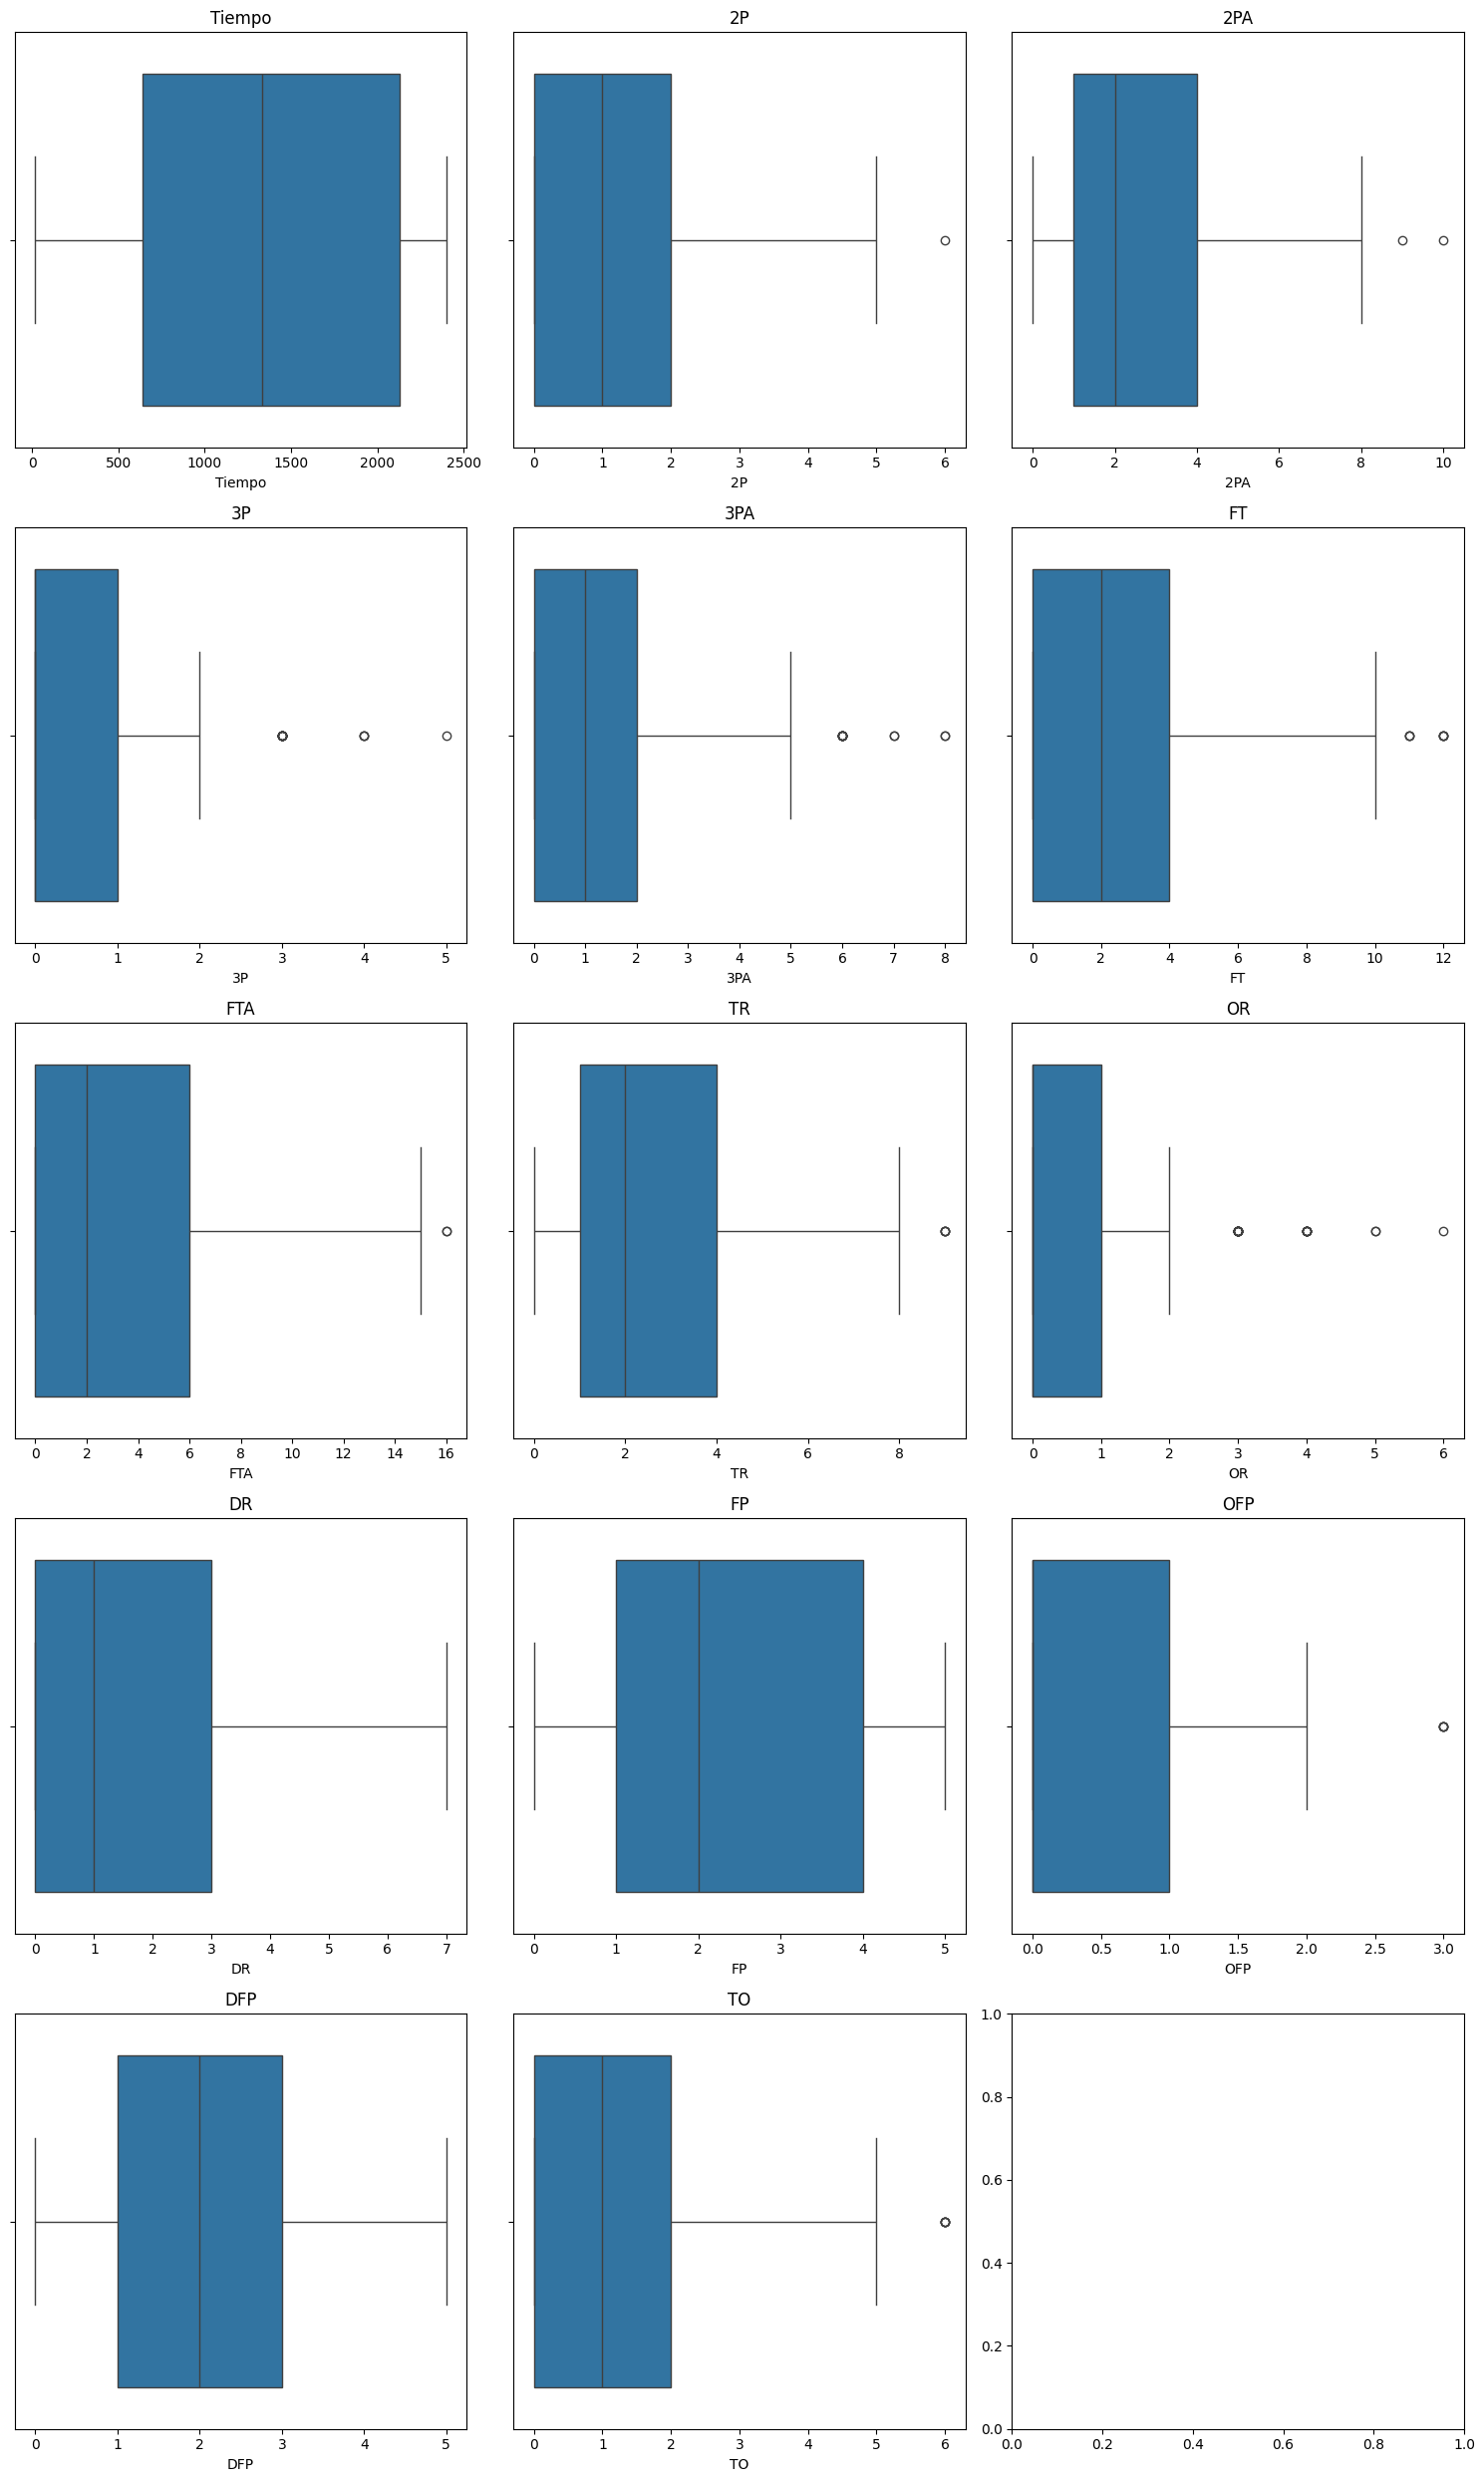

In [14]:

columnas_sin_id = ['Tiempo','2P','2PA','3P','3PA','FT','FTA','TR','OR','DR','FP','OFP','DFP','TO']

# Crear una matriz de subtrazados
filas = len(columnas_sin_id) // 3 + (1 if len(columnas_sin_id) % 3 != 0 else 0)
fig, axs = plt.subplots(filas, 3, figsize=(15, 5 * filas))
axs = axs.flatten()

# Iterar sobre las columnas y crear un diagrama de caja para cada una
for i, columna in enumerate(columnas_sin_id):
    sns.boxplot(x=temporada_completa_clean[columna], ax=axs[i])
    axs[i].set_title(columna)

# Ajustar el diseño de los subtrazados
plt.tight_layout()
plt.show()
# 

Podemos ver que en algunas de las variables podemos filtrar algunos datos adicionales además del máximo que ya habiamos decidido.

- Para la variable 2P, valores mayores que 5
- Para la variable 2PA, valores mayores que 6
- Para la variable 3P, valores mayores o iguales que 3
- Para la variable 3PA, valores mayores que 6
- Para la variable FT, valores mayores que 10
- Para la variable FTA, valores mayores que 12
- Para la variable TR, valores mayores que 8
- Para la variable OR, valores mayores que 3
- Para la variable DR, valores mayores o iguales que 6
- Para la variable OFP, valores mayores o iguales que 3
- Para la variable TO, valores mayores o iguales que 7

In [15]:
# Definir el diccionario de criterios de filtrado
criterios_filtrado = {
    '2P': temporada_completa_clean['2P'] <= 5,
    '2PA': temporada_completa_clean['2PA'] <= 6,
    '3P': temporada_completa_clean['3P'] < 3,
    '3PA': temporada_completa_clean['3PA'] <= 6,
    'FT': temporada_completa_clean['FT'] <= 10,
    'FTA': temporada_completa_clean['FTA'] <= 12,
    'TR': temporada_completa_clean['TR'] <= 8,
    'OR': temporada_completa_clean['OR'] <= 3,
    'DR': temporada_completa_clean['DR'] < 6,
    'OFP': temporada_completa_clean['OFP'] < 3,
    'TO': temporada_completa_clean['TO'] < 7
}

# Crear una máscara de filtro inicial que cumple todas las condiciones
mascara_filtro = pd.Series(True, index=temporada_completa_clean.index)
#print(mascara_filtro)
# Aplicar los criterios de filtrado al DataFrame
for columna, criterio in criterios_filtrado.items():
    mascara_filtro &= criterio
#print(mascara_filtro)
# Invertir la máscara para obtener las filas que no cumplen con los criterios
filas_que_no_cumplen = temporada_completa_clean[~mascara_filtro]


In [16]:
mascara_filas_cumplen = ~mascara_filtro

# Seleccionar las filas que no cumplen con los criterios
temporada_completa_clean_datos_no_validos = temporada_completa_clean[mascara_filas_cumplen]
# Seleccionar las filas que cumplen con los criterios
temporada_completa_clean_datos_validos = temporada_completa_clean[~mascara_filas_cumplen]



Visualizamos el data frame con las filas que hemos eliminado para ver si a primera vista vemos algún patron respecto algún partido o algún equipo que se hayan dado resultados anomalos.

In [17]:
temporada_completa_clean_datos_no_validos.describe()

,Tiempo,Tiempo_minutos,2P,2PA,2P_percentage,3P,3PA,3P_percentage,FT,FTA,...,OR_percentage,DR,DR_percentage,FP,OFP,OFP_percentage,DFP,DFP_percentage,TO,PTS
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,...,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,2186.093750,36.434896,2.359375,4.406250,52.317708,1.406250,3.328125,35.580357,4.375000,6.093750,...,36.569320,3.234375,63.430680,3.828125,0.734375,0.159443,3.125000,0.840557,1.937500,13.312500
std,316.202653,5.270044,1.483959,2.348378,27.897684,1.329981,1.984501,31.448660,3.475538,4.271421,...,30.511306,2.021646,30.511306,1.303898,0.877265,0.190024,1.253566,0.190024,1.367131,6.473082
min,1437.000000,23.950000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.333333,0.000000,3.000000
25%,2061.000000,34.350000,1.000000,3.000000,33.333333,0.000000,2.000000,0.000000,2.000000,2.000000,...,13.839286,2.000000,33.333333,3.000000,0.000000,0.000000,2.000000,0.666667,1.000000,8.000000
50%,2400.000000,40.000000,2.000000,4.000000,50.000000,1.000000,3.000000,33.333333,3.000000,5.000000,...,33.333333,3.000000,66.666667,4.000000,1.000000,0.105556,3.000000,0.894444,2.000000,12.000000
75%,2400.000000,40.000000,3.000000,6.000000,66.666667,3.000000,4.250000,50.000000,6.250000,8.250000,...,66.666667,5.250000,86.160714,5.000000,1.000000,0.333333,4.000000,1.000000,3.000000,18.250000
max,2400.000000,40.000000,6.000000,10.000000,100.000000,5.000000,8.000000,100.000000,12.000000,16.000000,...,100.000000,7.000000,100.000000,5.000000,3.000000,0.666667,5.000000,1.000000,6.000000,29.000000


Hay un dato que nos lleva a replantearnos estos valores extremos, todas las jugadores con valores extremos en alguna de las variables, han jugado mas de 20 minutos. Ademas vamos a valorar si hay algún partido en especial que tiene varios datos anomalos, y también si hay alguna jugadora que los tiene. Si asi fuera, quizá habria que replantearse no eliminar esos registros, ya que se puede deber a que es una jugadora de alto rendimiento y no un dato anomalo como tal.

In [18]:

tabla_frecuencias_match = temporada_completa_clean_datos_no_validos['partido'].value_counts()
print(tabla_frecuencias_match)
partidos_con_3_o_mas = tabla_frecuencias_match.loc[tabla_frecuencias_match >= 3].index
print(partidos_con_3_o_mas)

partido
partido27    4
partido16    4
partido2     4
partido14    4
partido13    3
partido21    3
partido19    3
partido17    3
partido15    3
partido5     3
partido4     3
partido10    2
partido11    2
partido26    2
partido9     2
partido7     2
partido29    2
partido18    2
partido3     2
partido22    2
partido23    2
partido28    1
partido1     1
partido24    1
partido12    1
partido8     1
partido6     1
partido30    1
Name: count, dtype: int64
Index(['partido27', 'partido16', 'partido2', 'partido14', 'partido13',
       'partido21', 'partido19', 'partido17', 'partido15', 'partido5',
       'partido4'],
      dtype='object', name='partido')


In [19]:
tabla_frecuencias_player = temporada_completa_clean_datos_no_validos['player'].value_counts()
print(tabla_frecuencias_player)
jugadores_con_3_o_mas = tabla_frecuencias_player.loc[tabla_frecuencias_player >= 3].index
print(jugadores_con_3_o_mas)

player
Eusebia Mariño         4
Sabina Hoz             4
Julieta Perera         4
Marisa Collado         4
Estrella Contreras     4
Alejandra Corral       3
Nilda Vega             3
Carmela Ordóñez        3
Luz Aranda             3
Beatriz Sarabia        3
Maura Espejo           2
Gema Palau             2
Angélica Vallejo       2
Elena Valle            2
María Carreras         2
Arcelia Jover          2
Bienvenida Uribe       2
Manuelita Bayón        2
Octavia Estevez        2
Encarnacion Llamas     1
Leire Villena          1
Adoración Ariño        1
Calixta Farré          1
María Pilar Collado    1
Anastasia Colomer      1
Blanca Leiva           1
Georgina Sancho        1
Aurora Suárez          1
Irma Nogueira          1
Leyre Sotelo           1
Name: count, dtype: int64
Index(['Eusebia Mariño', 'Sabina Hoz', 'Julieta Perera', 'Marisa Collado',
       'Estrella Contreras', 'Alejandra Corral', 'Nilda Vega',
       'Carmela Ordóñez', 'Luz Aranda', 'Beatriz Sarabia'],
      dtype='object

Observamos que hay partidos donde hay un mayor número de jugadores que han tenido valores extremos. También vemos que hay jugadores que tienen una mayor frecuencia de partidos donde han tenido valores extremos. 
Se decide no eliminar los partidos donde hay mas de 3 jugadores con valores extremos, así como los jugadores en los que en tres o mas partidos han tenido valores extremos.



In [20]:
# filas que tienen valores extremos pero que pertenecen a jugadoras o partidos que no queremos eliminar
jugadores_o_partidos_con_3_o_mas_filtrados = temporada_completa_clean_datos_no_validos[
    (temporada_completa_clean_datos_no_validos['player'].isin(jugadores_con_3_o_mas)) |
    (temporada_completa_clean_datos_no_validos['partido'].isin(partidos_con_3_o_mas))
]

# Añadir las filas filtradas a temporada_completa_clean_datos_validos
temporada_completa_clean_datos_validos = pd.concat([temporada_completa_clean_datos_validos, jugadores_o_partidos_con_3_o_mas_filtrados], axis=0)

# Eliminar las filas filtradas de temporada_completa_clean_datos_no_validos
temporada_completa_clean_datos_no_validos = temporada_completa_clean_datos_no_validos.copy()
temporada_completa_clean_datos_no_validos.drop(jugadores_o_partidos_con_3_o_mas_filtrados.index, inplace=True)

temporada_completa_clean_datos_no_validos

,home_team_name,away_team_name,team,player,Tiempo,Tiempo_minutos,2P,2PA,2P_percentage,3P,...,DR,DR_percentage,FP,OFP,OFP_percentage,DFP,DFP_percentage,TO,PTS,partido
9,Lobos de Albacete,Gaviotas de Coruña,Lobos de Albacete,Calixta Farré,1892,31.533333,4.0,7.0,57.142857,0.0,...,6.0,85.714286,2.0,0.0,0.000000,2.0,1.000000,0.0,11.0,partido1
51,Lobos de Albacete,Jirafas de Santa Cruz,Lobos de Albacete,Angélica Vallejo,2400,40.000000,1.0,5.0,20.000000,0.0,...,5.0,71.428571,5.0,0.0,0.000000,5.0,1.000000,3.0,14.0,partido3
61,Lobos de Albacete,Jirafas de Santa Cruz,Jirafas de Santa Cruz,Irma Nogueira,2400,40.000000,2.0,6.0,33.333333,3.0,...,1.0,25.000000,5.0,2.0,0.250000,4.0,0.750000,0.0,14.0,partido3
183,Gaviotas de Coruña,Jirafas de Santa Cruz,Gaviotas de Coruña,María Carreras,2400,40.000000,2.0,3.0,66.666667,0.0,...,6.0,85.714286,2.0,0.0,0.000000,2.0,1.000000,1.0,11.0,partido8
208,Gaviotas de Coruña,Perros de Sevilla,Gaviotas de Coruña,María Carreras,2400,40.000000,5.0,6.0,83.333333,1.0,...,3.0,60.000000,4.0,1.0,0.250000,3.0,0.750000,2.0,25.0,partido9
220,Gaviotas de Coruña,Gatos de Bilbao,Gaviotas de Coruña,Arcelia Jover,1448,24.133333,2.0,2.0,100.000000,1.0,...,6.0,75.000000,3.0,0.0,0.000000,3.0,1.000000,0.0,10.0,partido10
243,Abadejos de Palencia,Lobos de Albacete,Lobos de Albacete,Blanca Leiva,1626,27.100000,2.0,7.0,28.571429,0.0,...,1.0,33.333333,3.0,0.0,0.000000,3.0,1.000000,3.0,6.0,partido11
265,Abadejos de Palencia,Gaviotas de Coruña,Gaviotas de Coruña,Anastasia Colomer,2400,40.000000,2.0,5.0,40.000000,2.0,...,6.0,66.666667,3.0,1.0,0.333333,2.0,0.666667,2.0,15.0,partido12
427,Jirafas de Santa Cruz,Abadejos de Palencia,Abadejos de Palencia,Octavia Estevez,2400,40.000000,1.0,2.0,50.000000,0.0,...,6.0,75.000000,4.0,0.0,0.000000,4.0,1.000000,3.0,3.0,partido18
509,Perros de Sevilla,Gaviotas de Coruña,Gaviotas de Coruña,Arcelia Jover,2248,37.466667,4.0,7.0,57.142857,3.0,...,0.0,0.000000,4.0,0.0,0.000000,4.0,1.000000,1.0,22.0,partido22


In [21]:
temporada_completa_clean_datos_validos


,home_team_name,away_team_name,team,player,Tiempo,Tiempo_minutos,2P,2PA,2P_percentage,3P,...,DR,DR_percentage,FP,OFP,OFP_percentage,DFP,DFP_percentage,TO,PTS,partido
0,Lobos de Albacete,Gaviotas de Coruña,Lobos de Albacete,Adoración Ariño,2097,34.950000,1.0,3.0,33.333333,0.0,...,2.0,66.666667,5.0,1.0,0.142857,4.0,0.857143,2.0,8.0,partido1
1,Lobos de Albacete,Gaviotas de Coruña,Gaviotas de Coruña,Alejandra Corral,1897,31.616667,2.0,2.0,100.000000,0.0,...,3.0,75.000000,5.0,0.0,0.000000,5.0,1.000000,1.0,10.0,partido1
2,Lobos de Albacete,Gaviotas de Coruña,Gaviotas de Coruña,Anastasia Colomer,2400,40.000000,1.0,4.0,25.000000,0.0,...,4.0,80.000000,5.0,2.0,0.400000,3.0,0.600000,0.0,11.0,partido1
3,Lobos de Albacete,Gaviotas de Coruña,Lobos de Albacete,Angélica Vallejo,1467,24.450000,1.0,4.0,25.000000,1.0,...,1.0,50.000000,5.0,1.0,0.142857,4.0,0.857143,0.0,6.0,partido1
4,Lobos de Albacete,Gaviotas de Coruña,Lobos de Albacete,Anna Catalá,497,8.283333,0.0,0.0,0.000000,0.0,...,1.0,50.000000,2.0,1.0,0.500000,1.0,0.500000,0.0,0.0,partido1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,Gatos de Bilbao,Gaviotas de Coruña,Gaviotas de Coruña,Alejandra Corral,2400,40.000000,1.0,1.0,100.000000,1.0,...,2.0,50.000000,5.0,3.0,0.500000,2.0,0.500000,1.0,8.0,partido27
631,Gatos de Bilbao,Gaviotas de Coruña,Gatos de Bilbao,Encarnacion Llamas,2400,40.000000,2.0,2.0,100.000000,1.0,...,6.0,100.000000,5.0,1.0,0.142857,4.0,0.857143,5.0,8.0,partido27
638,Gatos de Bilbao,Gaviotas de Coruña,Gaviotas de Coruña,Julieta Perera,2150,35.833333,4.0,6.0,66.666667,3.0,...,3.0,75.000000,2.0,1.0,0.500000,1.0,0.500000,1.0,28.0,partido27
639,Gatos de Bilbao,Gaviotas de Coruña,Gatos de Bilbao,Manuelita Bayón,1477,24.616667,1.0,2.0,50.000000,1.0,...,0.0,0.000000,5.0,3.0,0.428571,3.0,0.571429,2.0,11.0,partido27


Ahora vamos a aplicar otro filtrado que considero adecuado. Se observa que hay muchas filas en nuestro data frame con un gran numero de 0's. Esto representa a jugadoras que no han aportado nada al equipo. Hay que tener en cuenta el tiempo que han jugado ya que han podido ser jugadoras que han jugado lo que se denominan 'minutos de la basura', con el resultado ya decidido, para ello vamos a poner dos criterios de filtrado. 
El primero va a ser que se haya jugado menos de 4 minutos en el partido (menos de un 10% del partido) y que ademas en esos 4 minutos no se ha valorado nada en los diferentes parametros recogidos en nuestro boxscore

In [22]:

condicion_tiempo = temporada_completa_clean_datos_validos['Tiempo'] >= 240

# Definir la condición para las columnas específicas
condicion_columnas = (temporada_completa_clean_datos_validos[['2P', '2PA', '3P', '3PA', 'FT', 'FTA', 'TR', 'OR', 'OR_percentage', 
                        'DR', 'DR_percentage', 'FP', 'OFP', 'OFP_percentage', 'DFP', 
                         'DFP_percentage', 'TO']] != 0).any(axis=1)

# Aplicar las condiciones para filtrar el DataFrame
temporada_completa_clean_datos_validos_filt_tiempo = temporada_completa_clean_datos_validos.loc[condicion_tiempo&condicion_columnas]


Volvemos a visualizar graficamente los datos filtrados con los que vamos a obtener los parametros de estadística avanzada y que serán la base de nuestro report posterior. 
De todas formas podremos recuperar cualquier dato que hayamos eliminado de forma sencilla


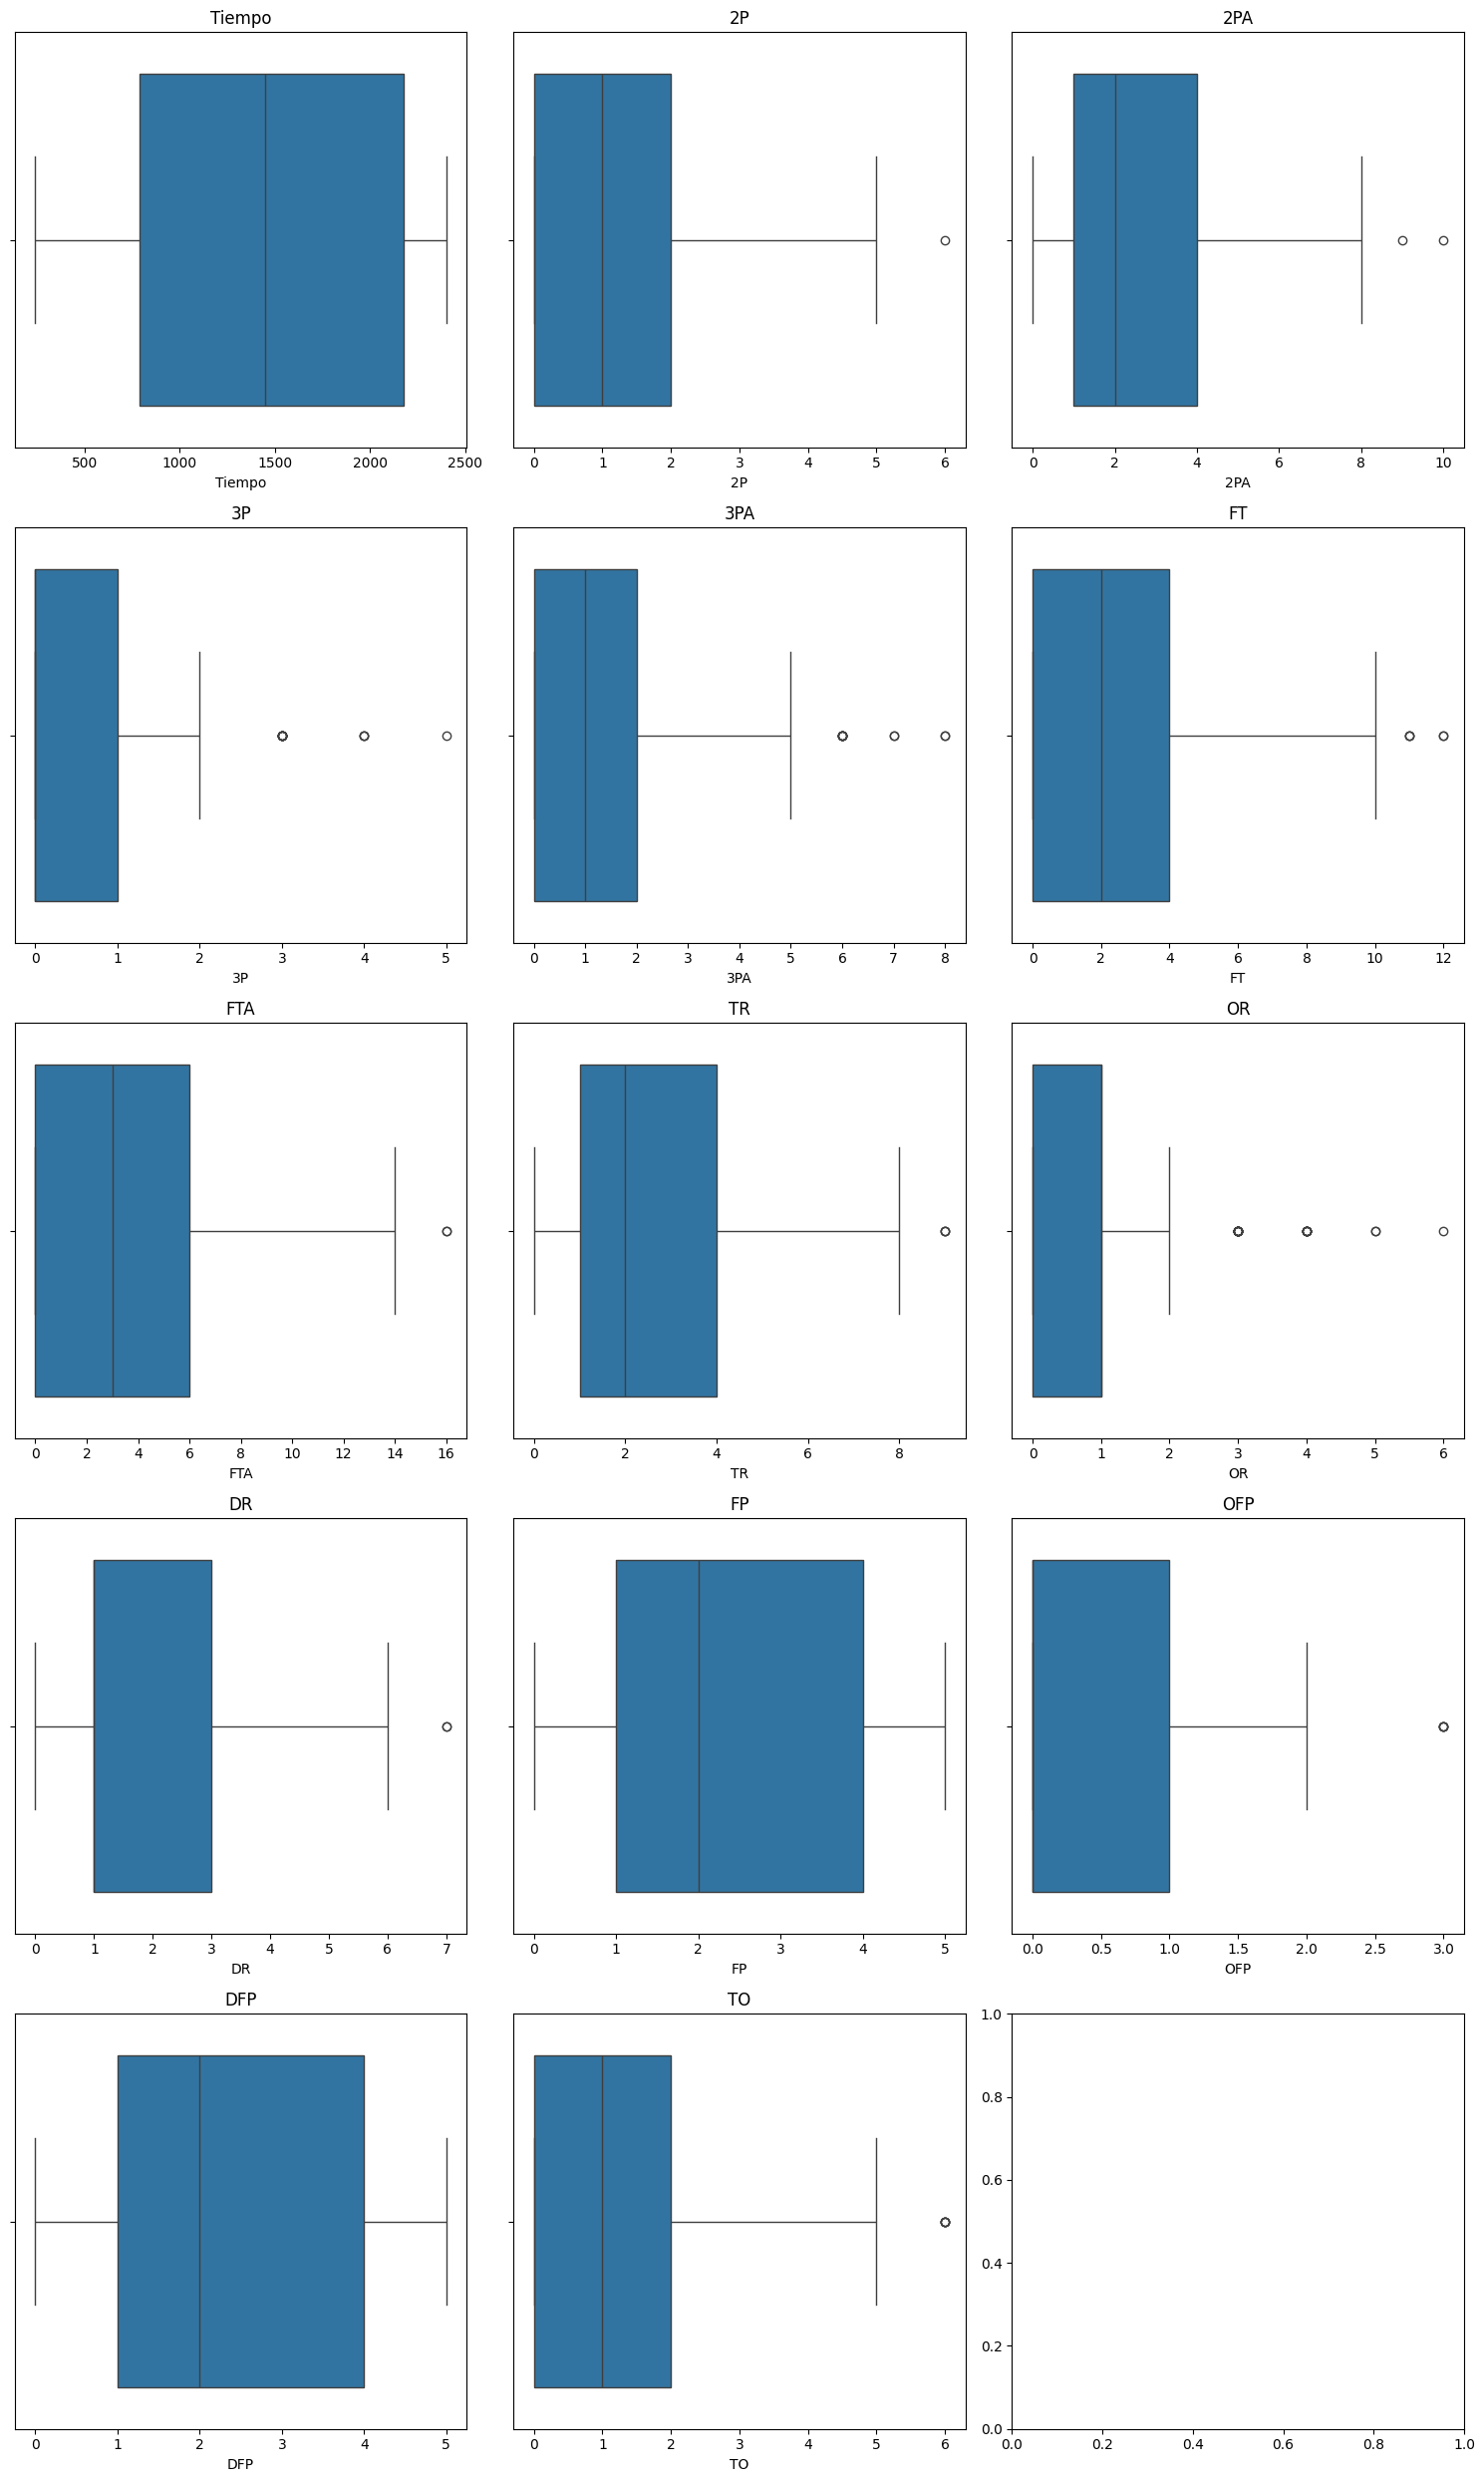

In [23]:
columnas_sin_id = ['Tiempo','2P','2PA','3P','3PA','FT','FTA','TR','OR','DR','FP','OFP','DFP','TO']

# Crear una matriz de subtrazados
filas = len(columnas_sin_id) // 3 + (1 if len(columnas_sin_id) % 3 != 0 else 0)
fig, axs = plt.subplots(filas, 3, figsize=(15, 5 * filas))
axs = axs.flatten()

# Iterar sobre las columnas y crear un diagrama de caja para cada una
for i, columna in enumerate(columnas_sin_id):
    sns.boxplot(x=temporada_completa_clean_datos_validos_filt_tiempo[columna], ax=axs[i])
    axs[i].set_title(columna)

# Ajustar el diseño de los subtrazados
plt.tight_layout()
plt.show()
# 

**-Realizando primeramente una extracción de la lista de acciones posibles, crear un csv con los datos en “sucio” que tome los datos de los partidos y determine los campos necesarios para el cálculo de las las estadísticas que forman parte de los “4 factores de Oliver”. Realizar el ejercicio a nivel jugador y equipo.**


Lo primero que haremos es definir una serie de funciones generales para calcular los 4 factores de Oliver, así como otros indicadores interesantes a la hora de reportar la información de un equipo.

Deberiamos definir funciones para 

* Posesiones
* Jugadas
* Effective Field Goal Percentage
* True Shooting Percentage
* Valoración
* Métrica +/-
* Player Efficiency Rating
* USG Percentage

Antes tenemos que hacer una transformación, para cada partido de liga y para cada equipo vamos a calcular los estadisticos globales del equipo de manera que tengamos un nuevo data.frame en el que para cada partido habrá dos filas, una para cada equipo en la que tendremos la suma de todas las variables crudas, y recalcularemos los porcentajes


In [24]:
temporada_completa_clean_datos_validos_filt_tiempo

,home_team_name,away_team_name,team,player,Tiempo,Tiempo_minutos,2P,2PA,2P_percentage,3P,...,DR,DR_percentage,FP,OFP,OFP_percentage,DFP,DFP_percentage,TO,PTS,partido
0,Lobos de Albacete,Gaviotas de Coruña,Lobos de Albacete,Adoración Ariño,2097,34.950000,1.0,3.0,33.333333,0.0,...,2.0,66.666667,5.0,1.0,0.142857,4.0,0.857143,2.0,8.0,partido1
1,Lobos de Albacete,Gaviotas de Coruña,Gaviotas de Coruña,Alejandra Corral,1897,31.616667,2.0,2.0,100.000000,0.0,...,3.0,75.000000,5.0,0.0,0.000000,5.0,1.000000,1.0,10.0,partido1
2,Lobos de Albacete,Gaviotas de Coruña,Gaviotas de Coruña,Anastasia Colomer,2400,40.000000,1.0,4.0,25.000000,0.0,...,4.0,80.000000,5.0,2.0,0.400000,3.0,0.600000,0.0,11.0,partido1
3,Lobos de Albacete,Gaviotas de Coruña,Lobos de Albacete,Angélica Vallejo,1467,24.450000,1.0,4.0,25.000000,1.0,...,1.0,50.000000,5.0,1.0,0.142857,4.0,0.857143,0.0,6.0,partido1
4,Lobos de Albacete,Gaviotas de Coruña,Lobos de Albacete,Anna Catalá,497,8.283333,0.0,0.0,0.000000,0.0,...,1.0,50.000000,2.0,1.0,0.500000,1.0,0.500000,0.0,0.0,partido1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,Gatos de Bilbao,Gaviotas de Coruña,Gaviotas de Coruña,Alejandra Corral,2400,40.000000,1.0,1.0,100.000000,1.0,...,2.0,50.000000,5.0,3.0,0.500000,2.0,0.500000,1.0,8.0,partido27
631,Gatos de Bilbao,Gaviotas de Coruña,Gatos de Bilbao,Encarnacion Llamas,2400,40.000000,2.0,2.0,100.000000,1.0,...,6.0,100.000000,5.0,1.0,0.142857,4.0,0.857143,5.0,8.0,partido27
638,Gatos de Bilbao,Gaviotas de Coruña,Gaviotas de Coruña,Julieta Perera,2150,35.833333,4.0,6.0,66.666667,3.0,...,3.0,75.000000,2.0,1.0,0.500000,1.0,0.500000,1.0,28.0,partido27
639,Gatos de Bilbao,Gaviotas de Coruña,Gatos de Bilbao,Manuelita Bayón,1477,24.616667,1.0,2.0,50.000000,1.0,...,0.0,0.000000,5.0,3.0,0.428571,3.0,0.571429,2.0,11.0,partido27


Antes de calcular los estadísticos avanzados, vamos a calcular lo siguiente:
 
* Suma de los Estadísticos básicos agrupados a  **nivel de equipo** y **nivel de partido** 
* Suma de todos los estadísticos básicos para toda la temporada a **nivel de equipo**.
* Suma de todos los estadísticos básicos para toda la temporada a **nivel de jugador**. Calcularemos adicionalmente, el número de partidos que ha participado un jugador. 





In [25]:
#temporada_completa_clean_datos_validos_filt_tiempo
temporada_completa_clean_datos_validos_filt_tiempo_first = temporada_completa_clean_datos_validos_filt_tiempo.copy()
temporada_completa_clean_datos_validos_filt_tiempo_grouped_partido_team = temporada_completa_clean_datos_validos_filt_tiempo_first.groupby(["partido", "team"]).agg({
    "Tiempo": "sum",
    "Tiempo_minutos": "sum",
    "2P": "sum",
    "2PA": "sum",
    "3P": "sum",
    "3PA": "sum",
    "FT": "sum",
    "FTA": "sum",
    "TR": "sum",
    "OR": "sum",
    "DR": "sum",
    "FP": "sum",
    "OFP": "sum",
    "DFP": "sum",
    "TO": "sum",
    "PTS": "sum"
})

# Calcular las nuevas columnas
temporada_completa_clean_datos_validos_filt_tiempo_grouped_partido_team["OR_percentage"] = temporada_completa_clean_datos_validos_filt_tiempo_grouped_partido_team["OR"] / temporada_completa_clean_datos_validos_filt_tiempo_grouped_partido_team["TR"] * 100
temporada_completa_clean_datos_validos_filt_tiempo_grouped_partido_team["DR_percentage"] = temporada_completa_clean_datos_validos_filt_tiempo_grouped_partido_team["DR"] / temporada_completa_clean_datos_validos_filt_tiempo_grouped_partido_team["TR"] * 100
temporada_completa_clean_datos_validos_filt_tiempo_grouped_partido_team["OFP_percentage"] = temporada_completa_clean_datos_validos_filt_tiempo_grouped_partido_team["OFP"] / temporada_completa_clean_datos_validos_filt_tiempo_grouped_partido_team["FP"] * 100
temporada_completa_clean_datos_validos_filt_tiempo_grouped_partido_team["DFP_percentage"] = temporada_completa_clean_datos_validos_filt_tiempo_grouped_partido_team["DFP"] / temporada_completa_clean_datos_validos_filt_tiempo_grouped_partido_team["FP"] * 100
temporada_completa_clean_datos_validos_filt_tiempo_grouped_partido_team.reset_index()


,partido,team,Tiempo,Tiempo_minutos,2P,2PA,3P,3PA,FT,FTA,...,DR,FP,OFP,DFP,TO,PTS,OR_percentage,DR_percentage,OFP_percentage,DFP_percentage
0,partido1,Gaviotas de Coruña,12000,200.000000,6.0,16.0,2.0,10.0,30.0,37.0,...,15.0,19.0,5.0,14.0,13.0,48.0,25.000000,75.000000,26.315789,73.684211
1,partido1,Lobos de Albacete,9862,164.366667,9.0,19.0,3.0,11.0,12.0,21.0,...,12.0,21.0,5.0,16.0,7.0,39.0,36.842105,63.157895,23.809524,76.190476
2,partido10,Gatos de Bilbao,11795,196.583333,12.0,25.0,4.0,9.0,23.0,31.0,...,14.0,26.0,6.0,20.0,11.0,59.0,30.000000,70.000000,23.076923,76.923077
3,partido10,Gaviotas de Coruña,10552,175.866667,13.0,19.0,3.0,12.0,19.0,32.0,...,12.0,20.0,5.0,16.0,6.0,54.0,20.000000,80.000000,25.000000,80.000000
4,partido11,Abadejos de Palencia,11784,196.400000,4.0,12.0,5.0,14.0,33.0,45.0,...,16.0,21.0,5.0,16.0,7.0,56.0,36.000000,64.000000,23.809524,76.190476
5,partido11,Lobos de Albacete,10136,168.933333,8.0,14.0,4.0,13.0,16.0,24.0,...,14.0,30.0,3.0,27.0,5.0,44.0,39.130435,60.869565,10.000000,90.000000
6,partido12,Abadejos de Palencia,11826,197.100000,11.0,23.0,4.0,10.0,19.0,24.0,...,17.0,23.0,3.0,20.0,9.0,53.0,10.526316,89.473684,13.043478,86.956522
7,partido12,Gaviotas de Coruña,9600,160.000000,6.0,21.0,2.0,9.0,9.0,15.0,...,14.0,11.0,0.0,11.0,8.0,27.0,36.363636,63.636364,0.000000,100.000000
8,partido13,Abadejos de Palencia,11962,199.366667,13.0,24.0,8.0,13.0,17.0,27.0,...,12.0,25.0,3.0,22.0,15.0,67.0,42.857143,57.142857,12.000000,88.000000
9,partido13,Jirafas de Santa Cruz,11883,198.050000,15.0,23.0,8.0,18.0,21.0,28.0,...,12.0,20.0,5.0,15.0,7.0,75.0,42.857143,57.142857,25.000000,75.000000


In [26]:
temporada_completa_clean_datos_validos_filt_tiempo_second = temporada_completa_clean_datos_validos_filt_tiempo.copy()
temporada_completa_clean_datos_validos_filt_tiempo_grouped_team = temporada_completa_clean_datos_validos_filt_tiempo_second.groupby(["team"]).agg({
    "Tiempo": "sum",
    "Tiempo_minutos": "sum",
    "2P": "sum",
    "2PA": "sum",
    "3P": "sum",
    "3PA": "sum",
    "FT": "sum",
    "FTA": "sum",
    "TR": "sum",
    "OR": "sum",
    "DR": "sum",
    "FP": "sum",
    "OFP": "sum",
    "DFP": "sum",
    "TO": "sum",
    "PTS": "sum"
})

# Calcular las nuevas columnas
temporada_completa_clean_datos_validos_filt_tiempo_grouped_team["OR_percentage"] = temporada_completa_clean_datos_validos_filt_tiempo_grouped_team["OR"] / temporada_completa_clean_datos_validos_filt_tiempo_grouped_team["TR"] * 100
temporada_completa_clean_datos_validos_filt_tiempo_grouped_team["DR_percentage"] = temporada_completa_clean_datos_validos_filt_tiempo_grouped_team["DR"] / temporada_completa_clean_datos_validos_filt_tiempo_grouped_team["TR"] * 100
temporada_completa_clean_datos_validos_filt_tiempo_grouped_team["OFP_percentage"] = temporada_completa_clean_datos_validos_filt_tiempo_grouped_team["OFP"] / temporada_completa_clean_datos_validos_filt_tiempo_grouped_team["FP"] * 100
temporada_completa_clean_datos_validos_filt_tiempo_grouped_team["DFP_percentage"] = temporada_completa_clean_datos_validos_filt_tiempo_grouped_team["DFP"] / temporada_completa_clean_datos_validos_filt_tiempo_grouped_team["FP"] * 100
temporada_completa_clean_datos_validos_filt_tiempo_grouped_team.reset_index()


,team,Tiempo,Tiempo_minutos,2P,2PA,3P,3PA,FT,FTA,TR,...,DR,FP,OFP,DFP,TO,PTS,OR_percentage,DR_percentage,OFP_percentage,DFP_percentage
0,Abadejos de Palencia,116596,1943.266667,97.0,194.0,52.0,146.0,237.0,312.0,219.0,...,144.0,211.0,33.0,178.0,93.0,587.0,34.246575,65.753425,15.639810,84.360190
1,Gatos de Bilbao,116757,1945.950000,109.0,204.0,46.0,130.0,217.0,276.0,202.0,...,144.0,234.0,55.0,182.0,101.0,573.0,28.712871,71.287129,23.504274,77.777778
2,Gaviotas de Coruña,108558,1809.300000,90.0,179.0,45.0,130.0,192.0,267.0,200.0,...,142.0,175.0,33.0,144.0,97.0,507.0,29.000000,71.000000,18.857143,82.285714
3,Jirafas de Santa Cruz,113538,1892.300000,116.0,221.0,50.0,109.0,210.0,297.0,198.0,...,141.0,206.0,28.0,178.0,108.0,592.0,28.787879,71.212121,13.592233,86.407767
4,Lobos de Albacete,110913,1848.550000,85.0,170.0,59.0,141.0,241.0,316.0,200.0,...,135.0,224.0,36.0,189.0,93.0,588.0,32.500000,67.500000,16.071429,84.375000
5,Perros de Sevilla,114130,1902.166667,111.0,195.0,48.0,132.0,215.0,283.0,193.0,...,136.0,211.0,39.0,172.0,104.0,581.0,29.533679,70.466321,18.483412,81.516588


In [27]:
temporada_completa_clean_datos_validos_filt_tiempo_third = temporada_completa_clean_datos_validos_filt_tiempo.copy()

# Agrupar por jugador y equipo, y contar cuántas veces aparece cada jugador
temporada_completa_clean_datos_validos_filt_tiempo_third['player_appearances'] = temporada_completa_clean_datos_validos_filt_tiempo_third.groupby(["player", "team"])["Tiempo"].transform("count")

# Resetear el índice si es necesario
temporada_completa_clean_datos_validos_filt_tiempo_third.reset_index(drop=True, inplace=True)

# Agrupar por jugador y equipo nuevamente y realizar las agregaciones totales
temporada_completa_clean_datos_validos_filt_tiempo_grouped_player = temporada_completa_clean_datos_validos_filt_tiempo_third.groupby(["player", "team"]).agg({
    "Tiempo": "sum",
    "Tiempo_minutos": "sum",
    "2P": "sum",
    "2PA": "sum",
    "3P": "sum",
    "3PA": "sum",
    "FT": "sum",
    "FTA": "sum",
    "TR": "sum",
    "OR": "sum",
    "DR": "sum",
    "FP": "sum",
    "OFP": "sum",
    "DFP": "sum",
    "TO": "sum",
    "PTS": "sum",
    "player_appearances": "first"  # Mantenemos la columna de team utilizando first
})

# Calcular las nuevas columnas
temporada_completa_clean_datos_validos_filt_tiempo_grouped_player["OR_percentage"] = temporada_completa_clean_datos_validos_filt_tiempo_grouped_player["OR"] / temporada_completa_clean_datos_validos_filt_tiempo_grouped_player["TR"] * 100
temporada_completa_clean_datos_validos_filt_tiempo_grouped_player["DR_percentage"] = temporada_completa_clean_datos_validos_filt_tiempo_grouped_player["DR"] / temporada_completa_clean_datos_validos_filt_tiempo_grouped_player["TR"] * 100
temporada_completa_clean_datos_validos_filt_tiempo_grouped_player["OFP_percentage"] = temporada_completa_clean_datos_validos_filt_tiempo_grouped_player["OFP"] / temporada_completa_clean_datos_validos_filt_tiempo_grouped_player["FP"] * 100
temporada_completa_clean_datos_validos_filt_tiempo_grouped_player["DFP_percentage"] = temporada_completa_clean_datos_validos_filt_tiempo_grouped_player["DFP"] / temporada_completa_clean_datos_validos_filt_tiempo_grouped_player["FP"] * 100
temporada_completa_clean_datos_validos_filt_tiempo_grouped_player.reset_index(inplace=True)  # Resetear el índice si es necesario



Definimos ya las funciones que vamos a necesitar para calcular:
* Número de posesiones (estadisticas de jugador y equipo)
* Número de jugadas  (estadisticas de jugador y equipo), 
* EFG percentage  (estadisticas de jugador y equipo), 
* True Shooting Percentage  (estadisticas de jugador y equipo)
* TO percentage (Oliver Factor) Perdidas por numero de jugadas  (estadisticas de jugador y equipo)
* Usage Rate (estadisticas de jugador)
* ORP Offensive Rebounding Percentage (Porcentaje de rebotes ofensivos sobre el total de tiros no encestados propios, estadisticas de equipo)
* DRP Deffensive Rebounding Percentage (Porcentaje de rebotes defensivos sobre el total de tiros no encestados por el oponente, estadisticas equipo)
* OER Indicador ofensivo que son puntos por posesión


In [28]:
def calcularPosesiones(TWO_PA, THREE_PA, FTA, OR, TO):
    posesiones = float(TWO_PA) + float(THREE_PA) + 0.44 * float(FTA) - float(OR) + float(TO)
    return posesiones

def calcularJugadas(TWO_PA, THREE_PA, FTA, TO):
    jugadas = float(TWO_PA) + float(THREE_PA) + 0.44 * float(FTA)  + float(TO)
    return(jugadas)

def calcularEffectiveFieldGoalPercentage(TWO_PM, THREE_PM,TWO_PA,THREE_PA):
    if (TWO_PA==0 and THREE_PA==0):
        efgPercentage=0
    else:
        efgPercentage = (float(TWO_PM)+(1.5*float(THREE_PM)))/(float(TWO_PA)+float(THREE_PA))*100
    return(efgPercentage)

def calcularTrueShootingPercentage(PTS,TWO_PA,THREE_PA,FTA):
    if (TWO_PA==0 and THREE_PA==0 and FTA==0):
        tsPercentage=0
    else:
        tsPercentage=float(PTS)/(2*(float(TWO_PA)+float(THREE_PA)+0.44*float(FTA)))*100
    return(tsPercentage)

def calcularTO_oliver_Percentage(TO,TWO_PA,THREE_PA,FTA):
    
    if (TWO_PA==0 and THREE_PA==0 and FTA==0 and TO==0):
        toPercentageOliver=0
    else:
        toPercentageOliver=float(TO)/(float(TWO_PA)+float(THREE_PA)+0.44*float(FTA)+float(TO))*100
    return(toPercentageOliver)

def calc_usage_rate(PLAY_p, PLAY_t, min_p, min_t):
    return 100*(PLAY_p/PLAY_t)*(min_t/(5*min_p))

def calc_offensive_efficiency(TWO_PM, THREE_PM, TWO_PA, THREE_PA, OR, TO):
    denominator = float(TWO_PA) + float(THREE_PA) - float(OR) + float(TO)
    if denominator == 0:
        OE=0
    else:
        OE= (float(TWO_PM) + float(THREE_PM)) / denominator
    return(OE)
    
def calc_ORPercentaje(teamOR,oppDR):
    if (oppDR==0 and teamOR==0):
        ORP=0
    else:
        ORP= float(teamOR) / (float(teamOR)+float(oppDR))
    return(ORP)

def calc_DRP(teamDR,oppOR):
    if (teamDR==0 and oppOR==0):
        ORP=0
    else:
        ORP= float(teamDR) / (float(teamDR)+float(oppOR))
    return(ORP)

def calc_OER(PTS,POS):
    if (POS==0):
        OER=0
    else:
        OER= float(PTS) / (float(POS))
    return(OER)

# PARA FACILITAR LA APLICACION DE LAS FUNCIONES RENOMBRAMOS LOS DATA.FRAMES
datos_players = temporada_completa_clean_datos_validos_filt_tiempo_grouped_player.copy()
datos_teams = temporada_completa_clean_datos_validos_filt_tiempo_grouped_team.copy()
datos_games = temporada_completa_clean_datos_validos_filt_tiempo_grouped_partido_team.copy()
temporada_completa_def = temporada_completa_clean_datos_validos_filt_tiempo.copy()

# GUARDAMOS LOS FICHEROS EN CSV

datos_players.to_csv("datos_players.csv")
datos_teams.to_csv("datos_teams.csv")
datos_games.to_csv("datos_games.csv")
temporada_completa_def.to_csv("temporada_completa_def.csv")

# CALCULAMOS POSESIONES
datos_players['POS'] = datos_players.apply(lambda row: calcularPosesiones(row['2PA'], row['3PA'], row['FTA'], row['OR'], row['TO']), axis=1)  
datos_teams['POS'] = datos_teams.apply(lambda row: calcularPosesiones(row['2PA'], row['3PA'], row['FTA'], row['OR'], row['TO']), axis=1)                             
datos_games['POS'] = datos_games.apply(lambda row: calcularPosesiones(row['2PA'], row['3PA'], row['FTA'], row['OR'], row['TO']), axis=1)  
temporada_completa_def['POS'] = temporada_completa_def.apply(lambda row: calcularPosesiones(row['2PA'], row['3PA'], row['FTA'], row['OR'], row['TO']), axis=1)  

# CALCULAMOS JUGADAS
datos_players['PLAYS'] = datos_players.apply(lambda row: calcularJugadas(row['2PA'], row['3PA'], row['FTA'],  row['TO']), axis=1)  
datos_teams['PLAYS'] = datos_teams.apply(lambda row: calcularJugadas(row['2PA'], row['3PA'], row['FTA'],  row['TO']), axis=1)                             
datos_games['PLAYS'] = datos_games.apply(lambda row: calcularJugadas(row['2PA'], row['3PA'], row['FTA'], row['TO']), axis=1)  
temporada_completa_def['PLAYS'] = temporada_completa_def.apply(lambda row: calcularJugadas(row['2PA'], row['3PA'], row['FTA'], row['TO']), axis=1)  

# CALCULAMOS EFG
datos_players['EFG'] = datos_players.apply(lambda row: calcularEffectiveFieldGoalPercentage(row['2P'], row['3P'], row['2PA'],  row['3PA']), axis=1)  
datos_teams['EFG'] = datos_teams.apply(lambda row: calcularEffectiveFieldGoalPercentage(row['2P'], row['3P'], row['2PA'],  row['3PA']), axis=1)                             
datos_games['EFG'] = datos_games.apply(lambda row: calcularEffectiveFieldGoalPercentage(row['2P'], row['3P'], row['2PA'], row['3PA']), axis=1) 
temporada_completa_def['EFG'] = temporada_completa_def.apply(lambda row: calcularEffectiveFieldGoalPercentage(row['2P'], row['3P'], row['2PA'], row['3PA']), axis=1) 

# CALCULAMOS TS
datos_players['TS'] = datos_players.apply(lambda row: calcularTrueShootingPercentage(row['PTS'], row['2PA'], row['3PA'],  row['FTA']), axis=1)  
datos_teams['TS'] = datos_teams.apply(lambda row: calcularTrueShootingPercentage(row['PTS'], row['2PA'], row['3PA'],  row['FTA']), axis=1)                             
datos_games['TS'] = datos_games.apply(lambda row: calcularTrueShootingPercentage(row['PTS'], row['2PA'], row['3PA'], row['FTA']), axis=1) 
temporada_completa_def['TS'] = temporada_completa_def.apply(lambda row: calcularTrueShootingPercentage(row['PTS'], row['2PA'], row['3PA'], row['FTA']), axis=1) 

# TO_oliver_Percentage Calculamos el factor de oliver relacionado con las perdidas

datos_players['TO_Percentage'] = datos_players.apply(lambda row: calcularTO_oliver_Percentage(row['TO'], row['2PA'], row['3PA'],  row['FTA']), axis=1)  
datos_teams['TO_Percentage'] = datos_teams.apply(lambda row: calcularTO_oliver_Percentage(row['TO'], row['2PA'], row['3PA'],  row['FTA']), axis=1)                             
datos_games['TO_Percentage'] = datos_games.apply(lambda row: calcularTO_oliver_Percentage(row['TO'], row['2PA'], row['3PA'], row['FTA']), axis=1) 
temporada_completa_def['TO_Percentage'] = temporada_completa_def.apply(lambda row: calcularTO_oliver_Percentage(row['TO'], row['2PA'], row['3PA'], row['FTA']), axis=1) 

# Calculamos Offensive offensive_efficiency
datos_players['OE'] = datos_players.apply(lambda row: calc_offensive_efficiency(row['2P'], row['3P'], row['2PA'],  row['3PA'],row['OR'],row['TO']), axis=1)  
datos_teams['OE'] = datos_teams.apply(lambda row: calc_offensive_efficiency(row['2P'], row['3P'], row['2PA'],  row['3PA'],row['OR'],row['TO']), axis=1)                             
datos_games['OE'] = datos_games.apply(lambda row: calc_offensive_efficiency(row['2P'], row['3P'], row['2PA'],  row['3PA'],row['OR'],row['TO']), axis=1) 
temporada_completa_def['OE'] = temporada_completa_def.apply(lambda row: calc_offensive_efficiency(row['2P'], row['3P'], row['2PA'],  row['3PA'],row['OR'],row['TO']), axis=1) 

# Calculamos Offensive offensive_efficiency (Dividimos puntos entre posesiones)
datos_players['OER'] = datos_players.apply(lambda row: calc_OER(row['PTS'], row['POS']), axis=1)  
datos_teams['OER'] = datos_teams.apply(lambda row: calc_OER(row['PTS'], row['POS']), axis=1)                             
datos_games['OER'] = datos_games.apply(lambda row: calc_OER(row['PTS'], row['POS']), axis=1) 
temporada_completa_def['OER'] = temporada_completa_def.apply(lambda row: calc_OER(row['PTS'], row['POS']), axis=1) 


# Para calcular la tasa de uso efectivo en el campo vamos a calcularlo de dos formas. Una utilizando los datos globales de toda la temporada y tambien lo vamos a calcular
# partido a partido
for index, row in datos_players.iterrows():
    # Obtener el nombre del equipo de la jugadora actual
    equipo = row['team']
    # Extraer los datos del equipo correspondiente del DataFrame datos_team
    equipo_data = datos_teams.loc[equipo]
    # Calcular el uso (usage rate) utilizando los datos del equipo y de la jugadora
    usage_rate = calc_usage_rate(row['PLAYS'], equipo_data['PLAYS'], row['Tiempo_minutos'], equipo_data['Tiempo_minutos'])
    # Almacenar el resultado en una nueva columna en el DataFrame de jugadores
    datos_players.at[index, 'Usage_rate'] = usage_rate

for index, row in temporada_completa_def.iterrows():
    # Obtener el nombre del equipo y del partido de la fila actual
    equipo = row['team']
    partido = row['partido']  # El índice ya es el nombre del partido
    # Extraer los datos correspondientes del primer DataFrame utilizando el nombre del equipo y del partido
    equipo_data = datos_games.loc[partido, equipo]
    # Calcular el valor deseado utilizando los datos del equipo y del partido
    usage_rate = calc_usage_rate(row['PLAYS'], equipo_data['PLAYS'], row['Tiempo_minutos'], equipo_data['Tiempo_minutos'])
    # Almacenar el resultado en una nueva columna en el segundo DataFrame
    temporada_completa_def.at[index, 'Usage_rate'] = usage_rate

for partido, row in datos_games.iterrows():
    equipo1, equipo2 = partido[1], None
    # Encontrar el equipo oponente
    for index, equipo in datos_games.index:
        if index == partido[0] and equipo != equipo1:
            equipo2 = equipo
            break
    # Obtener los datos del equipo oponente
    opp_DR = datos_games.loc[(partido[0], equipo2), 'DR']
    # Calcular el porcentaje de rebotes ofensivos para el primer equipo y agregarlo a una nueva columna
    datos_games.loc[(partido[0], equipo1), 'OR_PercentageOLIVER'] = calc_ORPercentaje(row['OR'], opp_DR)

for partido, row in datos_games.iterrows():
    equipo1, equipo2 = partido[1], None
    # Encontrar el equipo oponente
    for index, equipo in datos_games.index:
        if index == partido[0] and equipo != equipo1:
            equipo2 = equipo
            break
    # Obtener los datos del equipo oponente
    opp_OR = datos_games.loc[(partido[0], equipo2), 'OR']
    # Calcular el porcentaje de rebotes ofensivos para el primer equipo y agregarlo a una nueva columna
    datos_games.loc[(partido[0], equipo1), 'DR_PercentageOLIVER'] = calc_ORPercentaje(row['DR'], opp_OR)



**-Crear una tabla que calcule las estadísticas de EFG%, TS% y Usage Rate de cada jugador. Ordenar los jugadores según una de estas estadísticas. ¿Qué diferencias podemos ver entre ellas? ¿Qué conclusiones podemos sacar de la diferencia entre estas estadísticas? Ponderar estas variables con el tiempo en pista, ¿seguimos obteniendo los mismos resultados? Comenta y justifica la respuesta. Puedes apoyar tu discusión con una representación gráfica de los datos.**


Escribo una función que para un indicador me haga un equivalente ponderado a lo que ha jugado un jugador en el partido. Es decir, si un jugador ha jugado el 20% de todo el tiempo de partido, se pondere por ese tiempo para que el indicador tome mayor valor si ha jugado mucho en el partido.



In [29]:
def calcular_indicador_ponderado(temporada, games, variable_a_ponderar):
    resultado = []
    
    for index, fila in temporada.iterrows():
        partido = fila['partido']
        equipo = fila['team']
        tiempo_jugador = fila['Tiempo_minutos']
        
        # Buscar el tiempo total jugado por el equipo en el partido correspondiente
        try:
            tiempo_equipo = games.loc[partido, equipo]['Tiempo_minutos']
        except KeyError:
            # Si no se encuentra el partido o el equipo en el segundo DataFrame, asignamos un valor predeterminado
            tiempo_equipo = 0
        
        # Calcular el indicador multiplicado por el cociente de los minutos del jugador y los minutos del equipo
        indicador = fila[variable_a_ponderar] * (tiempo_jugador / tiempo_equipo)
        resultado.append(indicador)
    
    return resultado

# Uso de la función con las columnas 'EFG' y 'TS' del primer DataFrame y 'Tiempo_minutos' del segundo DataFrame
temporada_completa_def['EFG_ponderado'] = calcular_indicador_ponderado(temporada_completa_def, datos_games, 'EFG')
temporada_completa_def['TS_ponderado'] = calcular_indicador_ponderado(temporada_completa_def, datos_games, 'TS')



In [30]:
player_EFG = temporada_completa_def.groupby('player')['EFG'].describe().sort_values(by='mean',ascending=False)
player_EFG

#aux = temporada_completa_def[temporada_completa_def['player'] == 'Paloma Cabañas']
#player_EFG


,count,mean,std,min,25%,50%,75%,max
player,,,,,,,,
Maricela Varela,4.0,87.500000,62.915287,0.000000,75.000000,100.000000,112.500,150.0
Calixta Farré,9.0,71.468254,46.437118,0.000000,35.714286,83.333333,100.000,150.0
Amor Angulo,3.0,69.444444,33.678766,33.333333,54.166667,75.000000,87.500,100.0
Leyre Ponce,7.0,66.785714,53.555156,0.000000,31.250000,75.000000,90.000,150.0
Reyes Flor,5.0,66.666667,34.736108,33.333333,50.000000,62.500000,62.500,125.0
...,...,...,...,...,...,...,...,...
Serafina Rius,4.0,12.500000,25.000000,0.000000,0.000000,0.000000,12.500,50.0
María Hervás,4.0,9.375000,18.750000,0.000000,0.000000,0.000000,9.375,37.5
Javiera Barco,4.0,6.250000,12.500000,0.000000,0.000000,0.000000,6.250,25.0


Vemos que las cinco jugadoras con mayor EFG son Maricela Varlea, Calixta Farré, Amor Angulo, Leyre Ponce y Reyes Flor y las cinco jugadoras con menos son Serafina Rius, María Hervás, Javiera Barco, Anna Rocamora, Ágata Ibañez

In [31]:

player_EFG_ponderado = temporada_completa_def.groupby('player')['EFG_ponderado'].describe().sort_values(by='mean',ascending=False)
player_EFG_ponderado

,count,mean,std,min,25%,50%,75%,max
player,,,,,,,,
Nilda Vega,10.0,11.676102,5.024053,2.814286,10.412675,12.212823,15.106224,17.148660
Alejandra Corral,10.0,11.454031,4.150972,5.041698,9.214637,11.184885,15.060937,17.104529
Beatriz Sarabia,10.0,11.385538,7.858240,0.000000,6.284556,12.666667,17.491541,22.873602
Georgina Sancho,10.0,11.312098,7.279331,0.000000,8.407476,10.117321,14.164708,25.935852
Gema Palau,10.0,11.275426,4.867697,3.439578,7.889867,11.948865,13.965184,18.379713
...,...,...,...,...,...,...,...,...
Josefa Andres,6.0,1.288198,2.048554,0.000000,0.000000,0.000000,2.350017,4.595833
Serafina Rius,4.0,0.565625,1.131250,0.000000,0.000000,0.000000,0.565625,2.262500
Javiera Barco,4.0,0.471768,0.943536,0.000000,0.000000,0.000000,0.471768,1.887072


Vamos a evaluar el EFG ponderado por el tiempo de partido jugado en cada partido. En este caso tiene mas peso los resultados de jugadoras que han permanecido mas tiempo en cancha. Observamos que el listado varia, sobre todo en el top 5 de jugadoras que con mayor eficiencia. En el caso de las jugadoras con peor EFG no hay practicamente variaciones. 

Vamos a estudiar la relación entre el valor de EFG y EFG ponderado a través del gráfico de dispersión. Observamos una correlación moderada (r=0.62)

In [32]:
temporada_completa_def

,home_team_name,away_team_name,team,player,Tiempo,Tiempo_minutos,2P,2PA,2P_percentage,3P,...,POS,PLAYS,EFG,TS,TO_Percentage,OE,OER,Usage_rate,EFG_ponderado,TS_ponderado
0,Lobos de Albacete,Gaviotas de Coruña,Lobos de Albacete,Adoración Ariño,2097,34.950000,1.0,3.0,33.333333,0.0,...,8.64,9.64,20.000000,52.356021,20.746888,0.166667,0.925926,19.609015,4.252687,11.132689
1,Lobos de Albacete,Gaviotas de Coruña,Gaviotas de Coruña,Alejandra Corral,1897,31.616667,2.0,2.0,100.000000,0.0,...,5.08,6.08,100.000000,98.425197,16.447368,1.000000,1.968504,13.914880,15.808333,15.559383
2,Lobos de Albacete,Gaviotas de Coruña,Gaviotas de Coruña,Anastasia Colomer,2400,40.000000,1.0,4.0,25.000000,0.0,...,9.28,10.28,20.000000,53.501946,0.000000,0.250000,1.185345,18.596237,4.000000,10.700389
3,Lobos de Albacete,Gaviotas de Coruña,Lobos de Albacete,Angélica Vallejo,1467,24.450000,1.0,4.0,25.000000,1.0,...,8.64,9.64,35.714286,31.120332,0.000000,0.333333,0.694444,28.030064,5.312600,4.629236
4,Lobos de Albacete,Gaviotas de Coruña,Lobos de Albacete,Anna Catalá,497,8.283333,0.0,0.0,0.000000,0.0,...,2.00,3.00,0.000000,0.000000,0.000000,0.000000,0.000000,25.747913,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,Gatos de Bilbao,Gaviotas de Coruña,Gaviotas de Coruña,Alejandra Corral,2400,40.000000,1.0,1.0,100.000000,1.0,...,5.76,7.76,50.000000,59.171598,12.886598,0.500000,1.388889,12.914987,10.027576,11.866954
631,Gatos de Bilbao,Gaviotas de Coruña,Gatos de Bilbao,Encarnacion Llamas,2400,40.000000,2.0,2.0,100.000000,1.0,...,10.88,10.88,70.000000,68.027211,45.955882,0.300000,0.735294,19.662512,14.033915,13.638402
638,Gatos de Bilbao,Gaviotas de Coruña,Gaviotas de Coruña,Julieta Perera,2150,35.833333,4.0,6.0,66.666667,3.0,...,16.04,17.04,94.444444,87.281796,5.868545,0.777778,1.745636,31.657354,16.967958,15.681111
639,Gatos de Bilbao,Gaviotas de Coruña,Gatos de Bilbao,Manuelita Bayón,1477,24.616667,1.0,2.0,50.000000,1.0,...,9.52,10.52,50.000000,64.553991,19.011407,0.333333,1.155462,30.892752,6.169075,7.964769


In [33]:
# merged_df es un data frame en el que almaceno a nivel de jugador su media de EFG, EFG_ponderado, TS y TS_ponderado para poder hacer gráficos de dispersión de forma mas sencilla

merged_df = temporada_completa_def.groupby('player')[['EFG', 'EFG_ponderado','TS','TS_ponderado']].mean().reset_index()
merged_df

,player,EFG,EFG_ponderado,TS,TS_ponderado
0,Adelina Zaragoza,56.944444,3.107423,59.888781,3.010100
1,Adoración Ariño,56.062049,9.144520,65.065793,10.710601
2,Alejandra Corral,63.634740,11.454031,65.512424,11.827735
3,Alondra Prieto,52.976190,2.471528,57.503458,2.962736
4,Amor Angulo,69.444444,6.405474,71.326165,6.580004
...,...,...,...,...,...
67,Vilma Benavent,44.166667,4.774772,46.486724,4.519512
68,Ximena Pera,22.142857,1.955017,25.462821,2.343543
69,Zaira Izaguirre,43.750000,3.623832,78.771952,5.243738
70,Ágata Ibañez,0.000000,0.000000,28.409091,0.609937


In [34]:

# Renombra las columnas para que coincidan con los nombres solicitados
merged_df = merged_df.rename(columns={'EFG': 'mean_EFG', 'EFG_ponderado': 'mean_EFG_ponderado','TS':'mean_TS','TS_ponderado': 'mean_TS_ponderado'})


Vamos a examinar cómo se relacionan el Effective Field Goal Percentage (EFG) y el EFG ponderado a través de un gráfico de dispersión. Observamos una correlación moderada entre ambos (r=0.71). En los gráficos siguientes, mostramos la línea de regresión, la cual nos ayuda a entender cuánto se desvían los puntos reales de nuestra variable en el eje vertical respecto al valor predicho por esta línea. Notamos que cuando el EFG es bajo, los datos se ajustan bien al EFG ponderado, lo que sugiere que los minutos jugados tienen poco efecto en este caso. Sin embargo, cuando el EFG es alto, los datos tienden a alejarse de la línea de regresión. Esto parece indicar que valores muy altos de EFG subestiman la eficacia del jugador en comparación con el EFG ponderado, que tiene en cuenta los minutos jugados.

Text(0, 10, 'Correlation coefficient: 0.71')

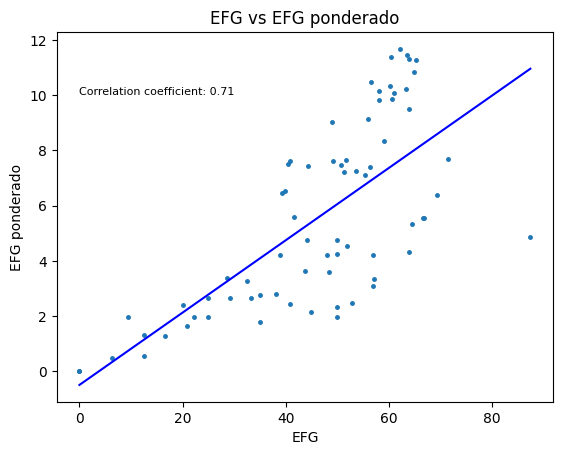

In [35]:

# Ajustar una línea de regresión
regression_line = np.polyfit(merged_df['mean_EFG'], merged_df['mean_EFG_ponderado'], 1)

# Calcular los valores de y para la línea de regresión
x_values = np.linspace(merged_df['mean_EFG'].min(), merged_df['mean_EFG'].max(), 100)
y_values = np.polyval(regression_line, x_values)

# Crear el gráfico de dispersión
plt.figure()
plt.title('EFG vs EFG ponderado')
plt.xlabel('EFG')
plt.ylabel('EFG ponderado')

# Graficar los puntos
plt.plot(merged_df['mean_EFG'], merged_df['mean_EFG_ponderado'], marker='.', markersize=5., linewidth=0)

# Dibujar la línea de regresión
plt.plot(x_values, y_values, linestyle='-', color='blue')

# Dibujar la diagonal
#plt.plot([0, 20], [0, 20], linestyle='--', color='red')
correlation_coefficient, _ = pearsonr(merged_df['mean_EFG'], merged_df['mean_EFG_ponderado'])

# Mostrar el coeficiente de correlación en el gráfico
plt.text(0, 10, f'Correlation coefficient: {correlation_coefficient:.2f}', fontsize=8)

Vemos que las cinco jugadoras con mayor TS son Maricela Varlea, Calixta Farré, Amor Angulo, Leyre Ponce y Ester Prats, es decir practicamente no ha cambiado el top5 de jugadoras que obtuvimos al estudiar el EFG

In [36]:
player_TS = temporada_completa_def.groupby('player')['TS'].describe().sort_values(by='mean',ascending=False)
player_TS



,count,mean,std,min,25%,50%,75%,max
player,,,,,,,,
Maricela Varela,4.0,87.500000,62.915287,0.000000,75.000000,100.000000,112.500000,150.000000
Calixta Farré,9.0,81.027849,38.047537,25.773196,49.603175,86.538462,100.000000,150.000000
Leyre Ponce,7.0,79.997003,41.426173,0.000000,72.079987,79.787234,103.360735,129.310345
Zaira Izaguirre,4.0,78.771952,25.891213,51.020408,69.005102,75.215517,84.982367,113.636364
Ester Prats,6.0,77.905573,44.987667,0.000000,60.648148,93.565204,108.861727,116.666667
...,...,...,...,...,...,...,...,...
Ágata Ibañez,2.0,28.409091,40.176522,0.000000,14.204545,28.409091,42.613636,56.818182
Nayara Ribas,4.0,28.030882,33.119051,0.000000,0.000000,23.734177,51.765059,64.655172
Ximena Pera,7.0,25.462821,28.473632,0.000000,0.000000,21.551724,42.006803,72.674419


Observamos que al ponderar por el tiempo en cancha el top 5 de jugadoras con mejor TS es similar al obtenido con el del EFG ponderado por el tiempo.

In [37]:
player_TS_ponderado = temporada_completa_def.groupby('player')['TS_ponderado'].describe().sort_values(by='mean',ascending=False)
player_TS_ponderado

,count,mean,std,min,25%,50%,75%,max
player,,,,,,,,
Beatriz Sarabia,10.0,13.479694,5.209017,5.566394,10.717946,14.166085,16.306921,22.965464
Gema Palau,10.0,12.720810,3.875016,6.778887,10.328133,13.098036,14.209868,19.384854
Nilda Vega,10.0,12.470603,4.623799,3.873698,9.619597,14.068399,15.423802,17.742491
Georgina Sancho,10.0,11.887526,5.280654,5.248768,8.072796,10.731288,14.329900,22.073066
Alejandra Corral,10.0,11.827735,4.081450,5.041698,9.643126,12.217178,14.958701,17.104529
...,...,...,...,...,...,...,...,...
Mirta Huerta,5.0,2.315859,1.617391,0.000000,1.718750,2.174559,3.670037,4.015950
Anna Catalá,2.0,1.981156,2.801778,0.000000,0.990578,1.981156,2.971734,3.962312
Serafina Rius,4.0,1.393961,1.665798,0.000000,0.000000,1.131250,2.525211,3.313346


Estudiamos de forma analoga los valores de TS con TS ponderado por tiempo. Observamos una correlación moderada (r = 0.52). Al igual que veiamos en la relación entre el EFG y el EFG ponderado, se repite esa tendencia de que en valores altos de TS este subestima el valor del TS respecto a cuando ponderamos por el tiempo

Text(15, 12, 'Correlation coefficient: 0.52')

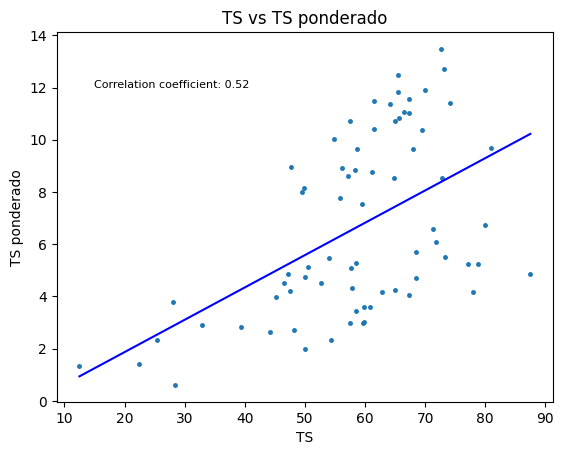

In [38]:

# Ajustar una línea de regresión
regression_line = np.polyfit(merged_df['mean_TS'], merged_df['mean_TS_ponderado'], 1)

# Calcular los valores de y para la línea de regresión
x_values = np.linspace(merged_df['mean_TS'].min(), merged_df['mean_TS'].max(), 100)
y_values = np.polyval(regression_line, x_values)

# Crear el gráfico de dispersión
plt.figure()
plt.title('TS vs TS ponderado')
plt.xlabel('TS')
plt.ylabel('TS ponderado')

# Graficar los puntos
plt.plot(merged_df['mean_TS'], merged_df['mean_TS_ponderado'], marker='.', markersize=5., linewidth=0)

# Dibujar la línea de regresión
plt.plot(x_values, y_values, linestyle='-', color='blue')

# Dibujar la diagonal
#plt.plot([0, 20], [0, 20], linestyle='--', color='red')
correlation_coefficient, _ = pearsonr(merged_df['mean_TS'], merged_df['mean_TS_ponderado'])
# Mostrar el coeficiente de correlación en el gráfico
plt.text(15, 12, f'Correlation coefficient: {correlation_coefficient:.2f}', fontsize=8)


Cuando evaluamos el TS crudo, sin ponderar, observamos que casi coincide la lista de jugadoras en el top5.

Al evaluar el TS ponderado, los resultados que obtenemos coinciden practicamente con el top5 del EFG ponderado

Para intentar entender el resultado de porque cambia ligeramente, tendremos que ver como se calculan ambos indicadores, en el EFG no tenemos en cuenta los tiros libres lanzados mientras que en el TS si que vamos a tener en cuenta esta jugada. 

De todas formas, el analisis que estamos haciendo hasta ahora, solo nos estamos fijando en el top 5, y esto hace que se escapen ciertos matices en el resultado. La mejor forma de ver si hay una concordancia entre ambas listas sería:

* Calcular el coeficiente de correlación
* Visualizar el diagrama de dispersión entre los dos paramétros


In [39]:

player_EFG = temporada_completa_def.groupby('player')['EFG'].describe().reset_index()
player_EFG_ponderado = temporada_completa_def.groupby('player')['EFG_ponderado'].describe().reset_index()
player_TS = temporada_completa_def.groupby('player')['TS'].describe().reset_index()
player_TS_ponderado = temporada_completa_def.groupby('player')['TS_ponderado'].describe().reset_index()
player_usage_rate = temporada_completa_def.groupby('player')['Usage_rate'].describe().reset_index()
# Unir player_EFG y player_EFG_ponderado por el campo 'player'
player_EFG_mean = player_EFG[['player', 'mean']]
player_EFG_ponderado_mean = player_EFG_ponderado[['player', 'mean']]
player_TS_mean = player_TS[['player', 'mean']]
player_TS_ponderado_mean = player_TS_ponderado[['player', 'mean']]
player_usage_rate_mean = player_usage_rate[['player', 'mean']]


# Unir los dataframes por el campo 'player'
merged_df = player_EFG_mean.merge(player_EFG_ponderado_mean, on='player', suffixes=('_EFG', '_EFG_ponderado')) \
                           .merge(player_TS_mean, on='player', suffixes=('_TS', '_TS_ponderado')) \
                           .merge(player_TS_ponderado_mean, on='player', suffixes=('_TS', '_TS_ponderado')) \
                           .merge(player_usage_rate_mean, on='player', suffixes=('_usage', '_usage'))

# Renombrar la última columna
merged_df = merged_df.rename(columns={'mean': 'mean_usage'})

merged_df


,player,mean_EFG,mean_EFG_ponderado,mean_TS,mean_TS_ponderado,mean_usage
0,Adelina Zaragoza,56.944444,3.107423,59.888781,3.010100,18.816488
1,Adoración Ariño,56.062049,9.144520,65.065793,10.710601,20.865333
2,Alejandra Corral,63.634740,11.454031,65.512424,11.827735,18.958829
3,Alondra Prieto,52.976190,2.471528,57.503458,2.962736,22.677723
4,Amor Angulo,69.444444,6.405474,71.326165,6.580004,22.492647
...,...,...,...,...,...,...
67,Vilma Benavent,44.166667,4.774772,46.486724,4.519512,20.603152
68,Ximena Pera,22.142857,1.955017,25.462821,2.343543,18.472331
69,Zaira Izaguirre,43.750000,3.623832,78.771952,5.243738,24.337070
70,Ágata Ibañez,0.000000,0.000000,28.409091,0.609937,14.178523


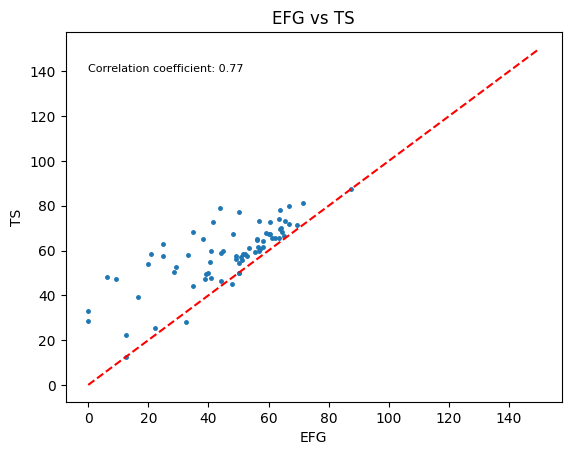

In [40]:

# Crear el gráfico de dispersión
plt.figure()
plt.title('EFG vs TS')
plt.xlabel('EFG')
plt.ylabel('TS')

# Graficar los puntos
plt.plot(merged_df['mean_EFG'], merged_df['mean_TS'], marker='.', markersize=5., linewidth=0)

# Dibujar la diagonal
plt.plot([0, 150], [0, 150], linestyle='--', color='red')

# Etiquetar los puntos que cumplen con las condiciones
#for index, row in merged_df.iterrows():
#   if row['mean_EFG'] < 30 and row['mean_TS'] > 59:
#        plt.text(row['mean_EFG'], row['mean_TS'], row['player'], fontsize=8, verticalalignment='bottom')
correlation_coefficient, _ = pearsonr(merged_df['mean_EFG'], merged_df['mean_TS'])

# Mostrar el coeficiente de correlación en el gráfico
plt.text(0, 140, f'Correlation coefficient: {correlation_coefficient:.2f}', fontsize=8)

# Mostrar el gráfico
plt.show()

Observamos que hay una correlacion bastante alta, r=0.77, entre ambos parametros. No hay jugadoras en las que tengan un valor muy alto en un indicador y muy bajo en el otro.

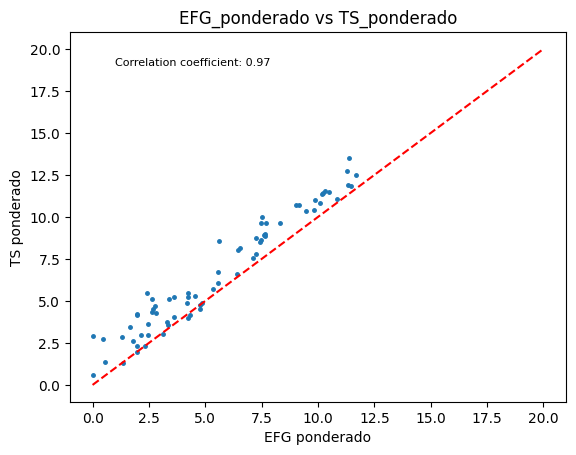

In [41]:
# Crear el gráfico de dispersión
plt.figure()
plt.title('EFG_ponderado vs TS_ponderado')
plt.xlabel('EFG ponderado')
plt.ylabel('TS ponderado')

# Graficar los puntos
plt.plot(merged_df['mean_EFG_ponderado'], merged_df['mean_TS_ponderado'], marker='.', markersize=5., linewidth=0)

# Dibujar la diagonal
plt.plot([0, 20], [0, 20], linestyle='--', color='red')
correlation_coefficient, _ = pearsonr(merged_df['mean_EFG_ponderado'], merged_df['mean_TS_ponderado'])

# Mostrar el coeficiente de correlación en el gráfico
plt.text(1, 19, f'Correlation coefficient: {correlation_coefficient:.2f}', fontsize=8)

# Etiquetar los puntos que cumplen con las condiciones
#for index, row in merged_df.iterrows():
 #   if row['mean_EFG'] < 30 and row['mean_TS'] > 59:
 #       plt.text(row['mean_EFG'], row['mean_TS'], row['player'], fontsize=8, verticalalignment='bottom')

# Mostrar el gráfico
plt.show()

Como podemos ver al comparar ambas gráficas, se observa que ambas tienen una alta relación lineal aunque al ponderar por el tiempo mejora la correlación (0.97 vs 0.77). Ambos indicadores nos sirven en esta liga para determinar que jugadoras son mas efectivas en el Tiro. Tambien vemos que al ponderar por el tiempo en juego el añadir los tiros libres no aporta mucha información ya que ambos parametros correlacionan de forma muy alta.

Ahora evaluaremos el volumen de jugadas que termina un jugador respecto a las de todo el equipo, ponderandolo por el tiempo de juego del jugador. De esta manera vemos que jugadoras tienen mayor impacto en el juego. Las jugadoras con mayor impacto son Ester Prats, Concepción Acedo, Evangelina Calatayud, Inés Diaz, Julieta Perera. Compararemos este indicador con el TS ponderado.

In [42]:
player_usage_rate = temporada_completa_def.groupby('player')['Usage_rate'].describe().sort_values(by='mean',ascending=False)
player_usage_rate


,count,mean,std,min,25%,50%,75%,max
player,,,,,,,,
Ester Prats,6.0,30.380361,19.301174,9.698038,16.951740,27.556274,38.472473,61.943477
Concepción Acedo,4.0,29.808900,15.819241,6.323397,27.978677,36.133776,37.963998,40.644650
Evangelina Calatayud,4.0,28.607313,3.590083,25.302826,26.551244,27.756889,29.812958,33.612646
Inés Diaz,8.0,25.782032,11.267434,5.117943,22.621750,26.199096,33.037624,39.228271
Julieta Perera,10.0,25.622206,11.042638,13.835762,19.356775,23.396622,28.644593,52.872874
...,...,...,...,...,...,...,...,...
Elvira Rodríguez,5.0,12.617541,7.968776,0.000000,11.594576,12.640386,18.706684,20.146059
Rita Castro,4.0,11.865622,5.552338,3.567066,11.371657,14.426350,14.920315,15.042721
Selena Cárdenas,7.0,11.091517,8.711271,0.000000,4.642231,11.036435,17.632755,22.054210


In [43]:
merged_df

,player,mean_EFG,mean_EFG_ponderado,mean_TS,mean_TS_ponderado,mean_usage
0,Adelina Zaragoza,56.944444,3.107423,59.888781,3.010100,18.816488
1,Adoración Ariño,56.062049,9.144520,65.065793,10.710601,20.865333
2,Alejandra Corral,63.634740,11.454031,65.512424,11.827735,18.958829
3,Alondra Prieto,52.976190,2.471528,57.503458,2.962736,22.677723
4,Amor Angulo,69.444444,6.405474,71.326165,6.580004,22.492647
...,...,...,...,...,...,...
67,Vilma Benavent,44.166667,4.774772,46.486724,4.519512,20.603152
68,Ximena Pera,22.142857,1.955017,25.462821,2.343543,18.472331
69,Zaira Izaguirre,43.750000,3.623832,78.771952,5.243738,24.337070
70,Ágata Ibañez,0.000000,0.000000,28.409091,0.609937,14.178523


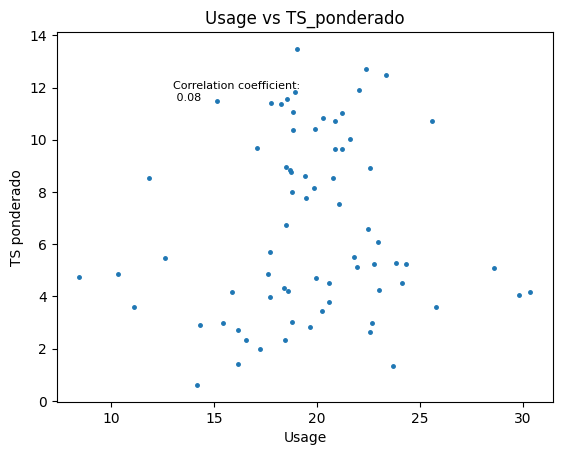

In [44]:
# Crear el gráfico de dispersión entre usage_rate y TS ponderado por tiempo
plt.figure()
plt.title('Usage vs TS_ponderado')
plt.xlabel('Usage')
plt.ylabel('TS ponderado')

# Graficar los puntos
plt.plot(merged_df['mean_usage'], merged_df['mean_TS_ponderado'], marker='.', markersize=5., linewidth=0)

# Dibujar la diagonal
# plt.plot([0, 20], [0, 20], linestyle='--', color='red')
correlation_coefficient, _ = pearsonr(merged_df['mean_usage'], merged_df['mean_TS_ponderado'])

# Mostrar el coeficiente de correlación en el gráfico
plt.text(13, 11.5, f'Correlation coefficient:\n {correlation_coefficient:.2f}', fontsize=8)

# Etiquetar los puntos que cumplen con las condiciones
#for index, row in merged_df.iterrows():
 #  if row['mean_usage'] > 27.5 and row['mean_TS_ponderado'] < 5:
#        plt.text(row['mean_usage'], row['mean_TS_ponderado'], row['player'], fontsize=8, verticalalignment='bottom')

# Mostrar el gráfico
plt.show()

Observamos que hay correlacion nula entre ambos parametros, es decir que no hay relación lineal.

In [45]:
print(temporada_completa_def['Usage_rate'].mean)

<bound method Series.mean of 0      19.609015
1      13.914880
2      18.596237
3      28.030064
4      25.747913
         ...    
624    12.914987
631    19.662512
638    31.657354
639    30.892752
661    27.167948
Name: Usage_rate, Length: 474, dtype: float64>


**-Crear una serie de gráficos que representen las relaciones entre (EFG% , tiempo) y (puntos, FGA). Realiza algún tipo de hipótesis sobre la relación de dos variables y represéntalas gráficamente. ¿Ha validado o descartado tu hipótesis este estudio?**


Dos hipotesis que podríamos plantear son las siguientes:

* En un sistema no programado como este deberíamos esperar que jugadoras con alto número de minutos jugando tendrían que tener niveles de eficiencia en el tiro de campo mayores que jugadoras que juegan poco, que se entiende que no tienen tanto nivel. Vamos a ver si esta hipotesis se cumple en nuestros datos de forma gráficas a través de dos gráficos, en uno representaremos los totales de la temporada para cada jugadora en cuanto a número de minutos y en cuanto a EFG, y en otro gráfico representaremos las medias por partido.


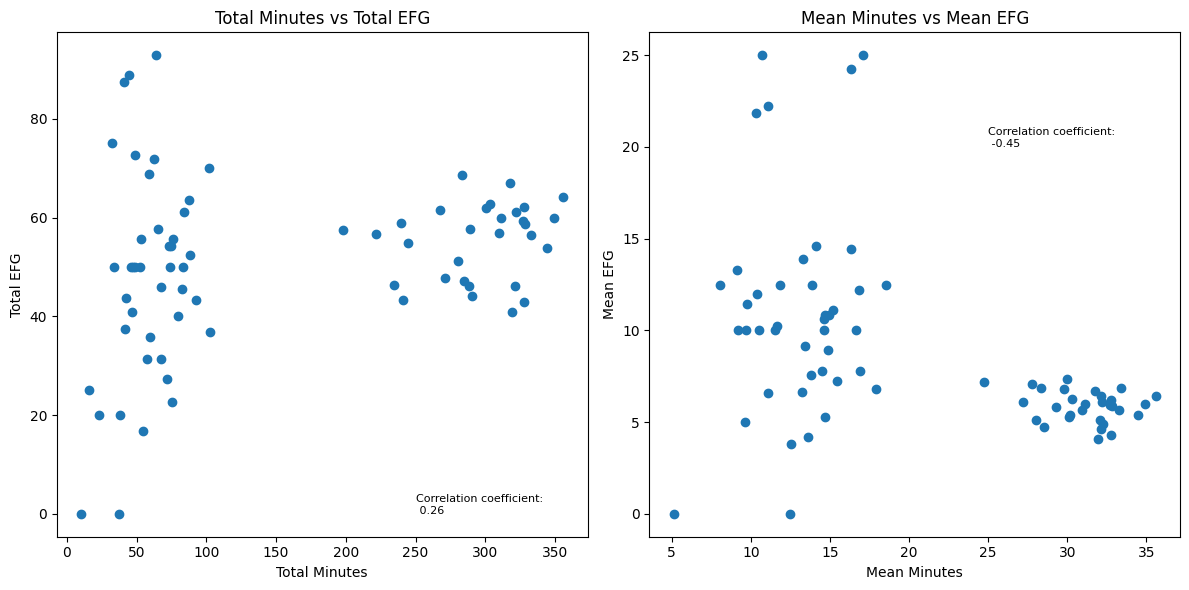

In [46]:

# Datos del primer gráfico
x1 = datos_players['Tiempo_minutos']
y1 = datos_players['EFG']
correlation_coefficient1, _ = pearsonr(x1, y1)

# Datos del segundo gráfico
media_minutos = datos_players['Tiempo_minutos'] / datos_players['player_appearances']
media_efg = datos_players['EFG'] / datos_players['player_appearances']
correlation_coefficient2, _ = pearsonr(media_minutos, media_efg)

# Crear la figura y los subplots
plt.figure(figsize=(12, 6))

# Primer gráfico de dispersión
plt.subplot(1, 2, 1)
plt.scatter(x1, y1)
plt.title('Total Minutes vs Total EFG')
plt.xlabel('Total Minutes')
plt.ylabel('Total EFG')
plt.text(250, 0, f'Correlation coefficient:\n {correlation_coefficient1:.2f}', fontsize=8)

# Segundo gráfico de dispersión
plt.subplot(1, 2, 2)
plt.scatter(media_minutos, media_efg)
plt.title('Mean Minutes vs Mean EFG')
plt.xlabel('Mean Minutes')
plt.ylabel('Mean EFG')
plt.text(25, 20, f'Correlation coefficient:\n {correlation_coefficient2:.2f}', fontsize=8)

# Mostrar la figura
plt.tight_layout()
plt.show()

Observamos claramente dos tipos de jugadores en cuanto al numero de minutos, los que juegan menos de un total de 175 minutos en la temporada y los que juegan mas de ese tiempo. Esto lo podríamos ver mejor en un gráfico de densidad

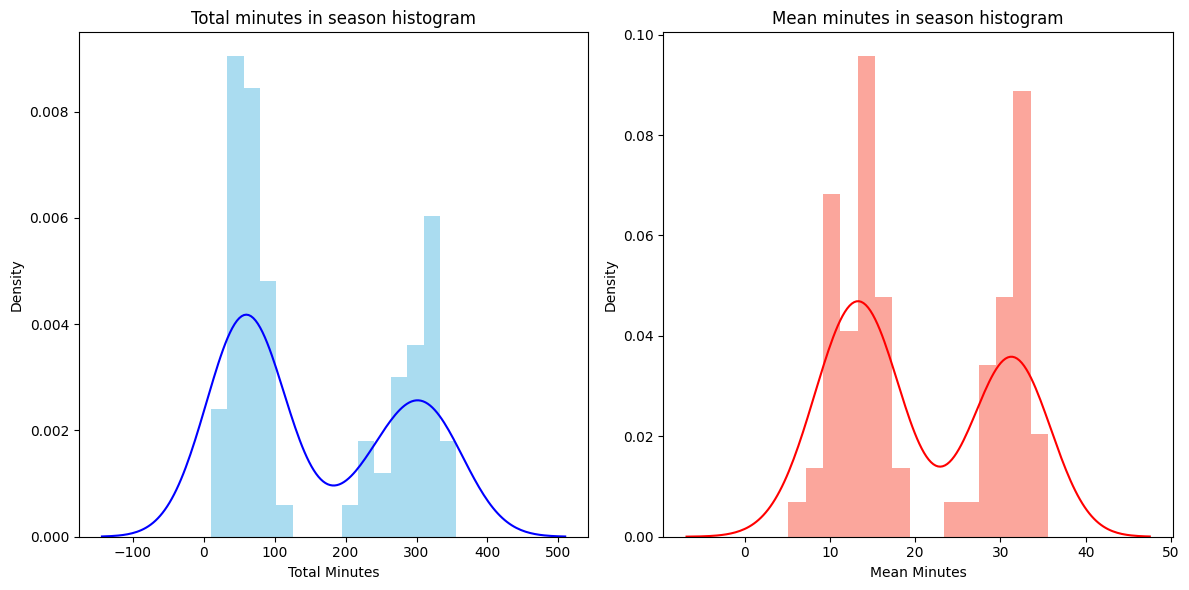

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Histograma y KDE del total de minutos
axs[0].hist(datos_players['Tiempo_minutos'], density=True, bins=15, color='skyblue', alpha=0.7)
sns.kdeplot(datos_players['Tiempo_minutos'], color='blue', ax=axs[0])
axs[0].set_title('Total minutes in season histogram')
axs[0].set_xlabel('Total Minutes')
axs[0].set_ylabel('Density')

# Histograma y KDE de los minutos promedio
axs[1].hist(media_minutos, density=True, bins=15, color='salmon', alpha=0.7)
sns.kdeplot(media_minutos, color='red', ax=axs[1])
axs[1].set_title('Mean minutes in season histogram')
axs[1].set_xlabel('Mean Minutes')
axs[1].set_ylabel('Density')

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

Vamos a repetir el análisis previo diferenciando los dos subgrupos en cuanto al tiempo en minutos, estableciendo como corte un total de 175 minutos en el total de la temporada y una media de 23

In [48]:
datos_players.columns


Index(['player', 'team', 'Tiempo', 'Tiempo_minutos', '2P', '2PA', '3P', '3PA',
       'FT', 'FTA', 'TR', 'OR', 'DR', 'FP', 'OFP', 'DFP', 'TO', 'PTS',
       'player_appearances', 'OR_percentage', 'DR_percentage',
       'OFP_percentage', 'DFP_percentage', 'POS', 'PLAYS', 'EFG', 'TS',
       'TO_Percentage', 'OE', 'OER', 'Usage_rate'],
      dtype='object')

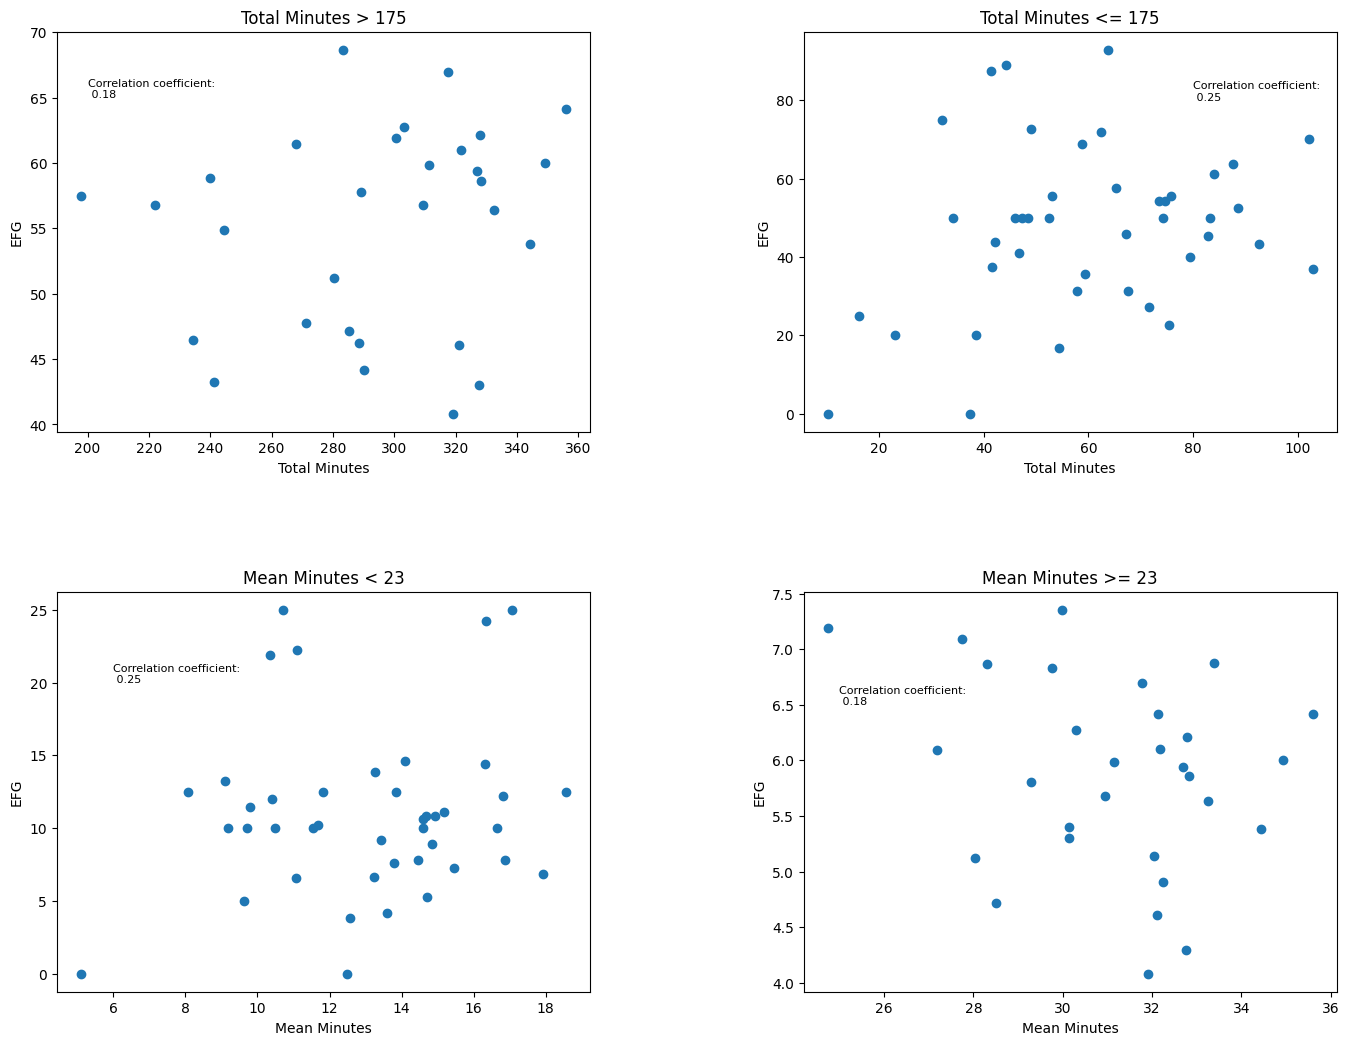

In [49]:
# Filtrar los datos en cuatro grupos
grupo1 = datos_players[datos_players['Tiempo_minutos'] > 175]
grupo2 = datos_players[datos_players['Tiempo_minutos'] <= 175]
grupo3 = datos_players[media_minutos < 23]
grupo4 = datos_players[media_minutos >= 23]

# Calcular los coeficientes de correlación para cada grupo
correlation_coefficient1, _ = pearsonr(grupo1['Tiempo_minutos'], grupo1['EFG'])
correlation_coefficient2, _ = pearsonr(grupo2['Tiempo_minutos'], grupo2['EFG'])
correlation_coefficient3, _ = pearsonr(grupo3['Tiempo_minutos'], grupo3['EFG'])
correlation_coefficient4, _ = pearsonr(grupo4['Tiempo_minutos'], grupo4['EFG'])

# Crear la figura y los subgráficos
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Primer gráfico de dispersión
axs[0, 0].scatter(grupo1['Tiempo_minutos'], grupo1['EFG'])
axs[0, 0].set_title('Total Minutes > 175')
axs[0, 0].set_xlabel('Total Minutes')
axs[0, 0].set_ylabel('EFG')
axs[0, 0].text(200, 65, f'Correlation coefficient:\n {correlation_coefficient1:.2f}', fontsize=8)

# Segundo gráfico de dispersión
axs[0, 1].scatter(grupo2['Tiempo_minutos'], grupo2['EFG'])
axs[0, 1].set_title('Total Minutes <= 175')
axs[0, 1].set_xlabel('Total Minutes')
axs[0, 1].set_ylabel('EFG')
axs[0, 1].text(80, 80, f'Correlation coefficient:\n {correlation_coefficient2:.2f}', fontsize=8)

# Tercer gráfico de dispersión
axs[1, 0].scatter(grupo3['Tiempo_minutos']/grupo3['player_appearances'], grupo3['EFG']/grupo3['player_appearances'])
axs[1, 0].set_title('Mean Minutes < 23')
axs[1, 0].set_xlabel('Mean Minutes')
axs[1, 0].set_ylabel('EFG')
axs[1, 0].text(6, 20, f'Correlation coefficient:\n {correlation_coefficient3:.2f}', fontsize=8)

# Cuarto gráfico de dispersión
axs[1, 1].scatter(grupo4['Tiempo_minutos']/grupo4['player_appearances'], grupo4['EFG']/grupo4['player_appearances'])
axs[1, 1].set_title('Mean Minutes >= 23')
axs[1, 1].set_xlabel('Mean Minutes')
axs[1, 1].set_ylabel('EFG')
axs[1, 1].text(25, 6.5, f'Correlation coefficient:\n {correlation_coefficient4:.2f}', fontsize=8)

# Ajustar el espacio entre los subgráficos
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

# Mostrar la figura
plt.show()

Al estratificar observamos correlaciones entre bajas y moderadas, en los cuatro grupos, en todos casos positivas.

En cuanto a la relación entre los puntos y el FGA, a priori la hipotesis que tiene mayor fuerza es que jugadores que intenten muchos tiros de campo deberian meter mas puntos. Vamos a ver si los gráficos nos ayudan a validar o rechazar esta hipótesis. Con todos los jugadores de la liga. Como en el caso anterior estudiaremos tanto los totales, como la media por partidos.

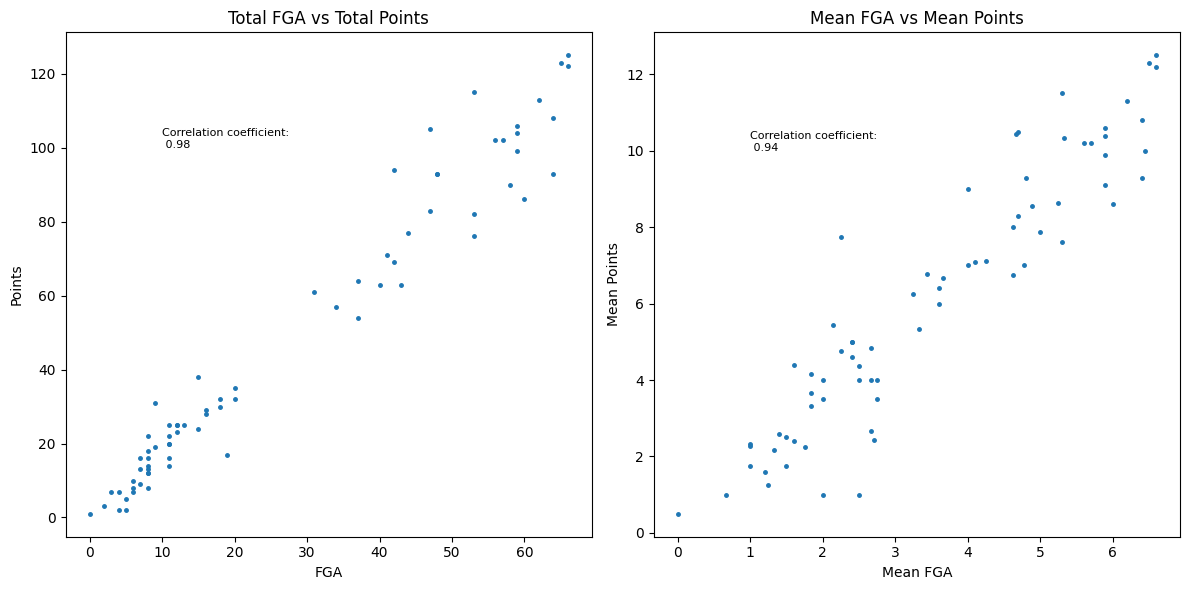

In [50]:
# Crear el gráfico de dispersión entre los puntos y el FGA

total_fga = datos_players['2PA']+datos_players['3PA']
total_points = datos_players['PTS']
numero_partidos = datos_players['player_appearances']
mean_fga = total_fga / numero_partidos
mean_points = total_points / numero_partidos

# Crear la figura y los subgráficos
plt.figure(figsize=(12, 6))

# Primer gráfico de dispersión
plt.subplot(1, 2, 1)
plt.title('Total FGA vs Total Points')
plt.xlabel('FGA')
plt.ylabel('Points')

# Graficar los puntos
plt.plot(total_fga, total_points, marker='.', markersize=5., linewidth=0)

# Calcular el coeficiente de correlación
correlation_coefficient, _ = pearsonr(total_fga, total_points)

# Mostrar el coeficiente de correlación en el gráfico
plt.text(10, 100, f'Correlation coefficient:\n {correlation_coefficient:.2f}', fontsize=8)

# Segundo gráfico de dispersión
plt.subplot(1, 2, 2)
plt.title('Mean FGA vs Mean Points')
plt.xlabel('Mean FGA')
plt.ylabel('Mean Points')

# Graficar los puntos
plt.plot(mean_fga, mean_points, marker='.', markersize=5., linewidth=0)

# Calcular el coeficiente de correlación
correlation_coefficient, _ = pearsonr(mean_fga, mean_points)

# Mostrar el coeficiente de correlación en el gráfico
plt.text(1, 10, f'Correlation coefficient:\n {correlation_coefficient:.2f}', fontsize=8)

# Ajustar el diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

En este caso si que obtenemos resultados totalmente que validan nuestra hipotesis, y los jugadores que mas tiros de campo intentan son los que luego meten mas puntos.

**-Utilizando cualquiera de las herramientas aprendidas en la sección de representación gráfica, crear algún tipo de gráfico que represente la distribución de EFG% para un equipo determinado. ¿Cual es el valor medio y desviación típica de esta variable? ¿Que tipo de distribución representa? ¿Existe algún dato anómalo? Crea una función que determine qué jugadores están por encima o por debajo de esta media.**



Evaluaremos a los **Gatos de Bilbao**

Lo primero de todo decidir que datos vamos a gráficar ya que aqui tenemos varias estrategias. Como el objetivo es estudiar la distribución del EFG% de un equipo, vamos a calcular la media de cada uno de los jugadores en los partidos que han jugado, ya que todos los jugadores no han jugado todos los partidos posibles. Extraeremos los datos

In [51]:
# Definimos el código de forma que se pueda automatizar por si en el futuro queremos analizar datos de otro equipo 

equipo_a_estudiar = 'Gatos de Bilbao'
temporada_completa_equipo_estudiar = temporada_completa_def[temporada_completa_def['team']==equipo_a_estudiar]


A partir de aqui podemos calcular la media y la desviación tipica de todas las medidas que tenemos del EFG% a lo largo de la temporada. Tenemos 81 mediciones 

In [52]:
print(f"La media de los {equipo_a_estudiar} es de {round(temporada_completa_equipo_estudiar.describe()['EFG']['mean'],2)}")
print(f"La desviación tipica de los {equipo_a_estudiar} es de {round(temporada_completa_equipo_estudiar.describe()['EFG']['std'],2)}")
media_efg_equipo_a_estudiar = temporada_completa_equipo_estudiar.describe()['EFG']['mean']

La media de los Gatos de Bilbao es de 47.24
La desviación tipica de los Gatos de Bilbao es de 38.25


Vamos a utilizar ahora los datos de EFG calculado en el total de la temporada para cada jugador. Es el EFG calculado con los datos del total de tiros de 2, tiros de 3...
Y a partir de los datos de cada jugador, calcularemos la media del equipo

In [53]:
jugadores_equipo_a_estudiar = datos_players[datos_players['team']==equipo_a_estudiar]
jugadores_equipo_a_estudiar['EFG'].describe()

count    12.000000
mean     51.159993
std      19.261030
min      20.000000
25%      44.583333
50%      52.083333
75%      57.651817
max      92.857143
Name: EFG, dtype: float64

En este caso obtenemos una media de 51.15 y una desviación típica de 19.26, que difiere ligeramente respecto a la calculada con todas los EFG individuales de cada jugador en cada partido

Vamos a calcular la media de cada jugador de su EFG a lo largo de la temporada.

In [54]:
temporada_completa_equipo_estudiar
player_equipo_a_estudiar_efg_mean = temporada_completa_equipo_estudiar.groupby('player')['EFG'].mean()

# Crea un nuevo DataFrame con los resultados
player_equipo_a_estudiar_efg_mean = pd.DataFrame(player_equipo_a_estudiar_efg_mean).reset_index()
player_equipo_a_estudiar_efg_mean


,player,EFG
0,Aurora Suárez,56.555556
1,Clotilde Cruz,48.000000
2,Encarnacion Llamas,56.305556
3,Eusebia Mariño,39.901515
4,Fabiana Zaragoza,35.000000
5,Georgina Sancho,64.027597
6,Gloria Arribas,35.000000
7,Josefa Andres,16.666667
8,Manuelita Bayón,59.126984
9,Selena Cárdenas,57.142857


In [55]:
player_equipo_a_estudiar_efg_mean.describe()

,EFG
count,12.000000
mean,43.664728
std,16.636777
min,12.500000
25%,35.000000
50%,45.875000
75%,56.702381
max,64.027597


Si nos fijamos a partir de las medias de cada jugador, podriamos calcular la media del equipo como la media de medias. Y en este caso obtendriamos una media de 43.66 con una desviación típica de 16.63. Un debate interesante sería decidir cual de las tres estrategias para calcular la media y la desviación tipica es la mas interesante.

* A partir de todas las mediciones posibles es decir a partir de las mediciones individuales de los jugadores en las diez jornadas
* Calculando el EFG a partir de los totales de tiros de dos intentandos, tiros de tres intentados, tiros de dos acertados y tiros de tres acertados, y ese EFG dividido por el número de jugadores
* Calculando la media de cada jugador del EFG a lo largo de la temporada, es decir cada jugador como la suma de los EFG individuales dividido entre el número de partidos, y luego calculando la media de los once jugadores del equipo

Para este ejercicio nos vamos a quedar con esta ultima estrategia teniendo en cuenta los EFG individuales según el numero de partidos y luego calculando la media de los once jugadores.

La distribución que representa es dificil de especificar, aunque en el histogra se ve que la parte central dos picos de densidad, podríamos decir que subyace una distribución uniforme.


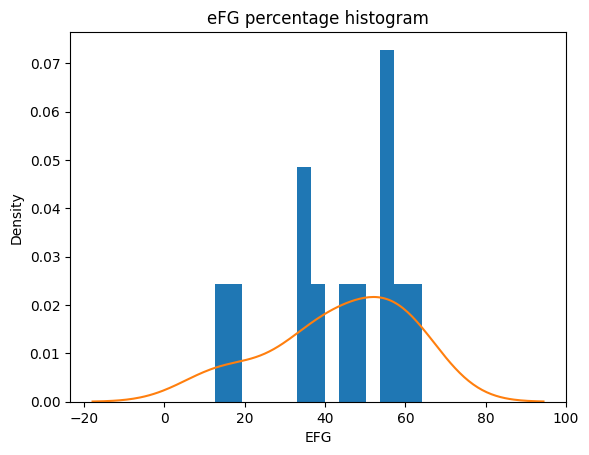

In [56]:
plt.hist(player_equipo_a_estudiar_efg_mean['EFG'], density=True, bins=15)
plt.title('eFG percentage histogram')
sns.kdeplot(player_equipo_a_estudiar_efg_mean['EFG']);

Haremos tambien el boxplot para evaluar si hay datos anomalos y si nos puede despejar alguna duda de la distribución.

<Axes: ylabel='EFG'>

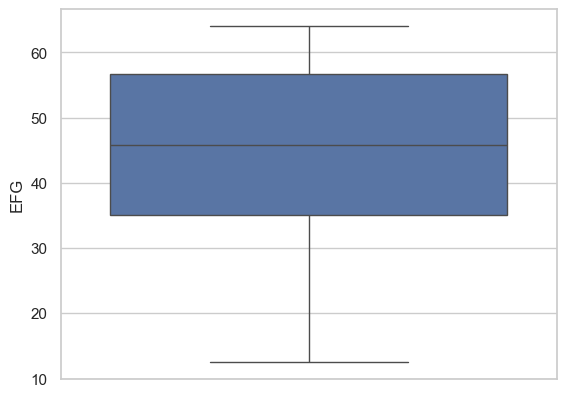

In [57]:
sns.set(style='whitegrid')
sns.boxplot(player_equipo_a_estudiar_efg_mean['EFG'])

En el gráfico anterior podemos observar que no hay anomalos. Ahora vamos a definir una función que nos determine que jugadores están por encima o por debajo de la media

In [58]:
# Defino una función muy genérica para poder usarla a la hora de generar el informe sobre los equipos
def comparadorParametro(datos_jugadores, parametro, valor, nombre_nueva_columna):
    # Crea una nueva columna que contiene la comparación
    datos_jugadores[nombre_nueva_columna] = datos_jugadores[parametro].apply(
        lambda x: f"Superior a {round(valor,2)}" if x > valor else f"Inferior a {round(valor,2)}"
    )
    return datos_jugadores
player_equipo_a_estudiar_efg_mean
media_equipo_a_estudiar = player_equipo_a_estudiar_efg_mean['EFG'].mean()

player_equipo_a_estudiar_efg_mean=comparadorParametro(player_equipo_a_estudiar_efg_mean,'EFG',media_equipo_a_estudiar,'Comparador_EFG')

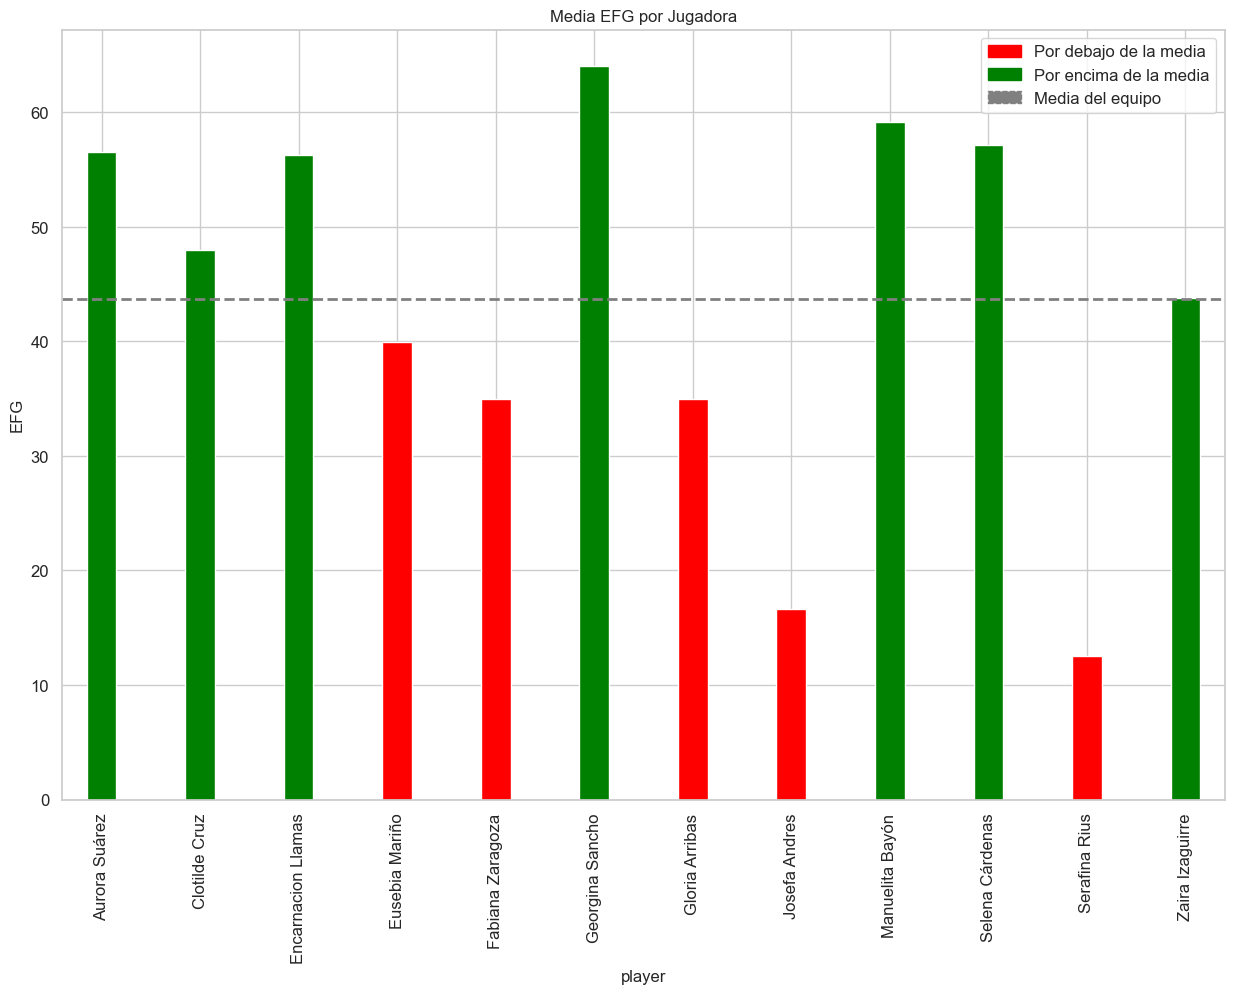

In [59]:

media = player_equipo_a_estudiar_efg_mean['EFG'].mean()

# Crear una lista de colores basada en si cada jugadora está por encima o por debajo de la media
colores = ['green' if valor > media else 'red' for valor in player_equipo_a_estudiar_efg_mean['EFG']]

# Crear el gráfico de barras
ax = player_equipo_a_estudiar_efg_mean.plot(x='player', y='EFG', kind='bar', width=0.3, color=colores,
                                  title="Media EFG", figsize=(15, 10), legend=True, fontsize=12)

# Mostrar la línea horizontal en la media
plt.axhline(y=media, color='gray', linestyle='--', linewidth=2, label='Media')

# Crear una leyenda personalizada
import matplotlib.patches as mpatches
handles = [mpatches.Patch(color='red', label='Por debajo de la media'),
           mpatches.Patch(color='green', label='Por encima de la media'),
           mpatches.Patch(color='gray', linestyle='--', label='Media del equipo')]
plt.legend(handles=handles, fontsize=12)

# Añadir etiqueta al eje y
plt.ylabel('EFG')

# Añadir título al gráfico
plt.title('Media EFG por Jugadora')

# Mostrar el gráfico
plt.show()


# Resultados adicionales para informe

## Haremos un informe para el equipo Gatos de Bilbao

In [60]:
equipo_de_interes= 'Gatos de Bilbao'

### Jugadoras

In [61]:
equipos_liga
jugadoras_ciervos = [jugador['name'] for equipo in equipos_liga
 if equipo['team_name'] == equipo_de_interes for jugador in equipo['players']]

pd.DataFrame(jugadoras_ciervos).to_excel("nombres_jugadoras.xlsx")

### Resultados

In [62]:
partidos_liga
datos_partidos = []

for partido in partidos_liga:
    home_team = partido['home_team']['team_name']
    away_team = partido['away_team']['team_name']
    home_team_points = partido['home_team_points']
    away_team_points = partido['away_team_points']
    
    datos_partidos.append({'home_team': home_team, 'away_team': away_team, 'home_team_points': home_team_points, 'away_team_points': away_team_points})

# Crear DataFrame con los datos de los partidos
df_partidos = pd.DataFrame(datos_partidos)
df_partidos
mask = (df_partidos['home_team'] == equipo_de_interes) | (df_partidos['away_team'] == equipo_de_interes)

# Aplicar la máscara booleana para obtener el DataFrame filtrado
df_partidos_nuestro_equipo = df_partidos[mask]
df_partidos_nuestro_equipo['local_visitante'] = ''

# Comparar las puntuaciones y registrar el resultado
for idx, row in df_partidos_nuestro_equipo.iterrows():
    if row['home_team'] == equipo_de_interes:
        df_partidos_nuestro_equipo.loc[idx, 'local_visitante'] = 'Local'
        if row['home_team_points'] > row['away_team_points']:
            df_partidos_nuestro_equipo.loc[idx, 'resultado'] = 'Ganado'
        elif row['home_team_points'] < row['away_team_points']:
            df_partidos_nuestro_equipo.loc[idx, 'resultado'] = 'Perdido'
        else:
            df_partidos_nuestro_equipo.loc[idx, 'resultado'] = 'Empate'
    elif row['away_team'] == equipo_de_interes:
        df_partidos_nuestro_equipo.loc[idx, 'local_visitante'] = 'Visitante'
        if row['away_team_points'] > row['home_team_points']:
            df_partidos_nuestro_equipo.loc[idx, 'resultado'] = 'Ganado'
        elif row['away_team_points'] < row['home_team_points']:
            df_partidos_nuestro_equipo.loc[idx, 'resultado'] = 'Perdido'
        else:
            df_partidos_nuestro_equipo.loc[idx, 'resultado'] = 'Empate'

# Calcular la diferencia de puntos
df_partidos_nuestro_equipo['diferencia_puntos'] = df_partidos_nuestro_equipo.apply(lambda x: x['home_team_points'] - x['away_team_points'] if x['home_team'] == equipo_de_interes else x['away_team_points'] - x['home_team_points'], axis=1)

df_partidos_nuestro_equipo.to_excel("resultados_nuestro_equipo.xlsx")
df_partidos_nuestro_equipo


/var/folders/cc/jt7_p8z15p77b7wxd10qfc100000gn/T/ipykernel_23456/4167285504.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_partidos_nuestro_equipo['local_visitante'] = ''
/var/folders/cc/jt7_p8z15p77b7wxd10qfc100000gn/T/ipykernel_23456/4167285504.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_partidos_nuestro_equipo.loc[idx, 'resultado'] = 'Perdido'
/var/folders/cc/jt7_p8z15p77b7wxd10qfc100000gn/T/ipykernel_23456/4167285504.py:41: SettingWithCopyWarning: 
A value is trying to be set on a c

,home_team,away_team,home_team_points,away_team_points,local_visitante,resultado,diferencia_puntos
4,Lobos de Albacete,Gatos de Bilbao,64,56,Visitante,Perdido,-8
9,Gaviotas de Coruña,Gatos de Bilbao,64,59,Visitante,Perdido,-5
14,Abadejos de Palencia,Gatos de Bilbao,66,54,Visitante,Perdido,-12
19,Jirafas de Santa Cruz,Gatos de Bilbao,60,55,Visitante,Perdido,-5
24,Perros de Sevilla,Gatos de Bilbao,52,53,Visitante,Ganado,1
25,Gatos de Bilbao,Lobos de Albacete,64,62,Local,Ganado,2
26,Gatos de Bilbao,Gaviotas de Coruña,50,73,Local,Perdido,-23
27,Gatos de Bilbao,Abadejos de Palencia,72,73,Local,Perdido,-1
28,Gatos de Bilbao,Jirafas de Santa Cruz,72,71,Local,Ganado,1
29,Gatos de Bilbao,Perros de Sevilla,50,53,Local,Perdido,-3


### Clasificación

In [63]:
clasificacion_liga
df_puntuaciones = pd.DataFrame(list(clasificacion_liga
.items()), columns=['equipo', 'puntuacion'])
df_puntuaciones.to_excel('Clasificacion_Liga.xlsx')


### Estadística - Equipo

In [64]:
datos_teams['Puntos_por_partido']=datos_teams['PTS'] / 10
datos_teams['Puntos_por_tiro'] = datos_teams['PTS'] / (datos_teams['3PA']+datos_teams['2PA']+datos_teams['FTA'])


In [65]:
# Defino una función genérica para que me devuelva los graficos de los indicadores por equipo
def generarGraficoEquipo(datos_teams, team_name, indicador_name):
    df_sorted = datos_teams.sort_values(by=indicador_name, ascending=False)
    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    # Crear las barras para todos los equipos
    plt.barh(df_sorted.index, df_sorted[indicador_name], color='skyblue')
    # Resaltar la barra del equipo especificado en team_name en rojo
    plt.barh(team_name, df_sorted.loc[team_name, indicador_name], color='red')
    plt.xlabel(indicador_name.replace("_"," "))
    plt.ylabel('Equipo')
    plt.title(f"{indicador_name.replace("_"," ")} por Partido por Equipo")
    plt.gca().invert_yaxis()  # Invertir el eje y para que los equipos con mayor puntuación estén arriba
    plt.show()

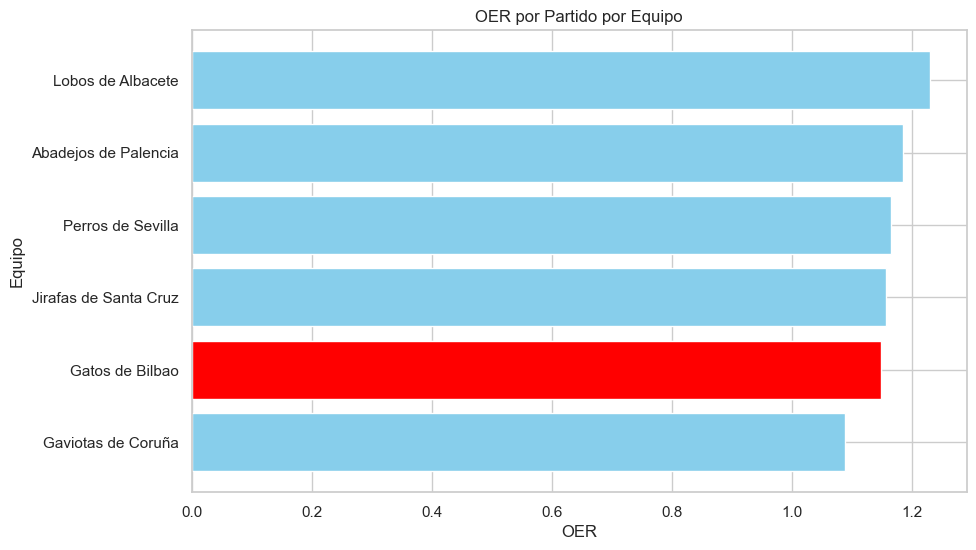

In [66]:
generarGraficoEquipo(datos_teams,equipo_de_interes,'OER')

In [67]:
datos_teams.sort_values(by='OER')

,Tiempo,Tiempo_minutos,2P,2PA,3P,3PA,FT,FTA,TR,OR,...,DFP_percentage,POS,PLAYS,EFG,TS,TO_Percentage,OE,OER,Puntos_por_partido,Puntos_por_tiro
team,,,,,,,,,,,,,,,,,,,,,
Gaviotas de Coruña,108558,1809.300000,90.0,179.0,45.0,130.0,192.0,267.0,200.0,58.0,...,82.285714,465.48,523.48,50.970874,59.440068,18.529839,0.387931,1.089198,50.7,0.880208
Gatos de Bilbao,116757,1945.950000,109.0,204.0,46.0,130.0,217.0,276.0,202.0,58.0,...,77.777778,498.44,556.44,53.293413,62.906201,18.151103,0.411141,1.149587,57.3,0.939344
Jirafas de Santa Cruz,113538,1892.300000,116.0,221.0,50.0,109.0,210.0,297.0,198.0,57.0,...,86.407767,511.68,568.68,57.878788,64.252844,18.991348,0.435696,1.156973,59.2,0.944179
Perros de Sevilla,114130,1902.166667,111.0,195.0,48.0,132.0,215.0,283.0,193.0,57.0,...,81.516588,498.52,555.52,55.963303,64.338235,18.721198,0.425134,1.165450,58.1,0.952459
Abadejos de Palencia,116596,1943.266667,97.0,194.0,52.0,146.0,237.0,312.0,219.0,75.0,...,84.360190,495.28,570.28,51.470588,61.494301,16.307779,0.416201,1.185188,58.7,0.900307
Lobos de Albacete,110913,1848.550000,85.0,170.0,59.0,141.0,241.0,316.0,200.0,65.0,...,84.375000,478.04,543.04,55.787781,65.327526,17.125810,0.424779,1.230023,58.8,0.937799


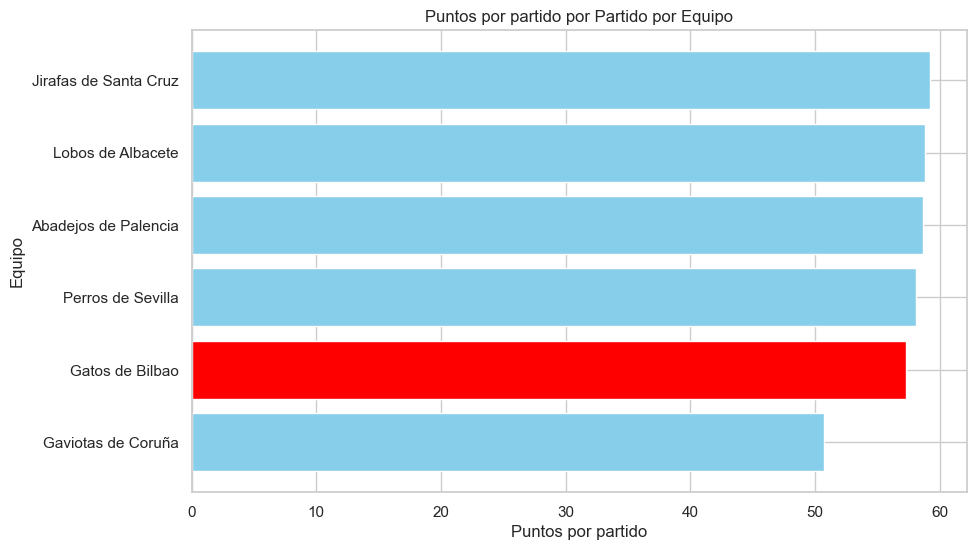

In [68]:
generarGraficoEquipo(datos_teams,equipo_de_interes,'Puntos_por_partido')

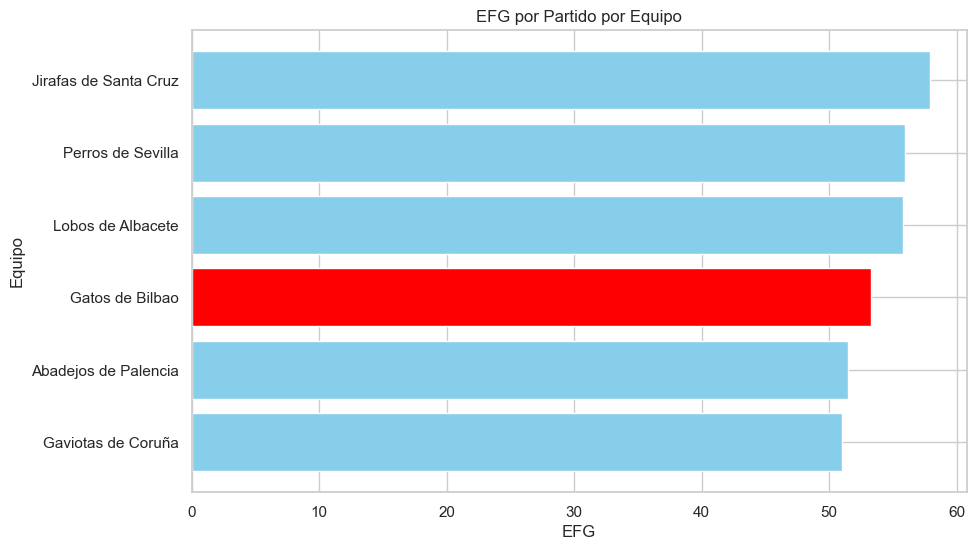

In [69]:
generarGraficoEquipo(datos_teams,equipo_de_interes,'EFG')

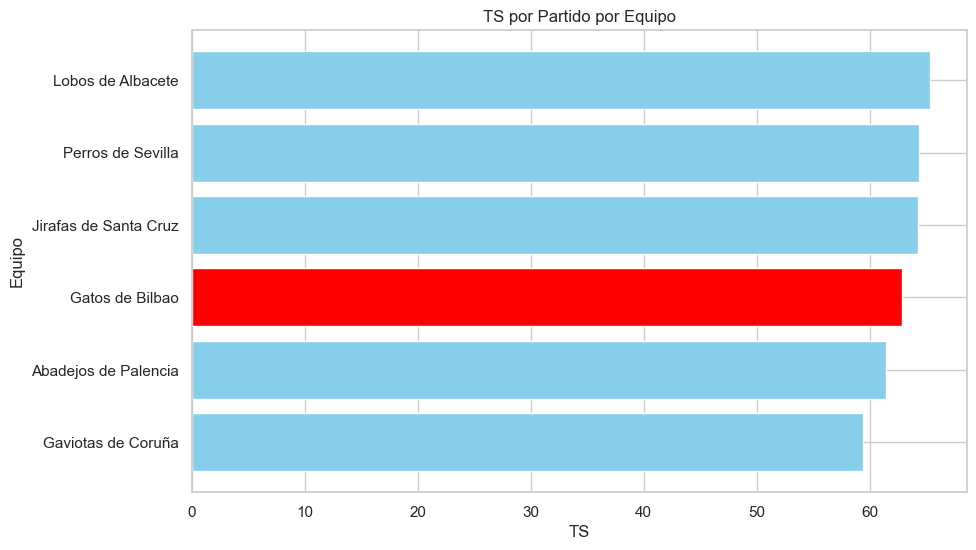

In [70]:
generarGraficoEquipo(datos_teams,equipo_de_interes,'TS')

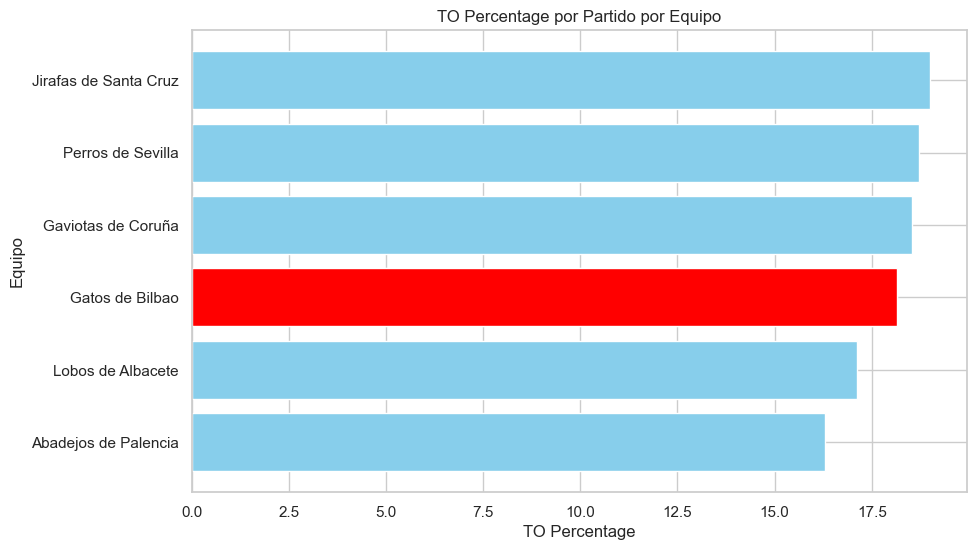

In [71]:
generarGraficoEquipo(datos_teams,equipo_de_interes,'TO_Percentage')

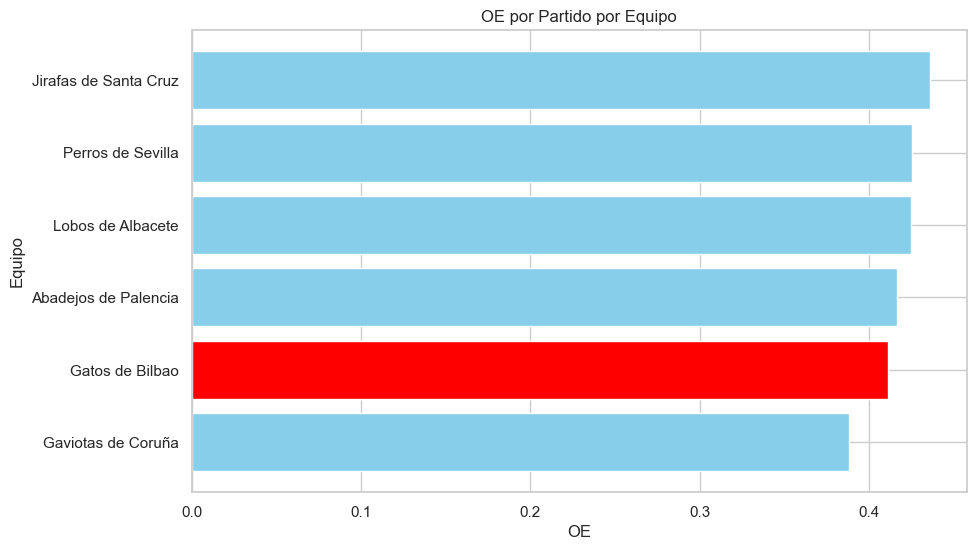

In [72]:
generarGraficoEquipo(datos_teams,equipo_de_interes,'OE')

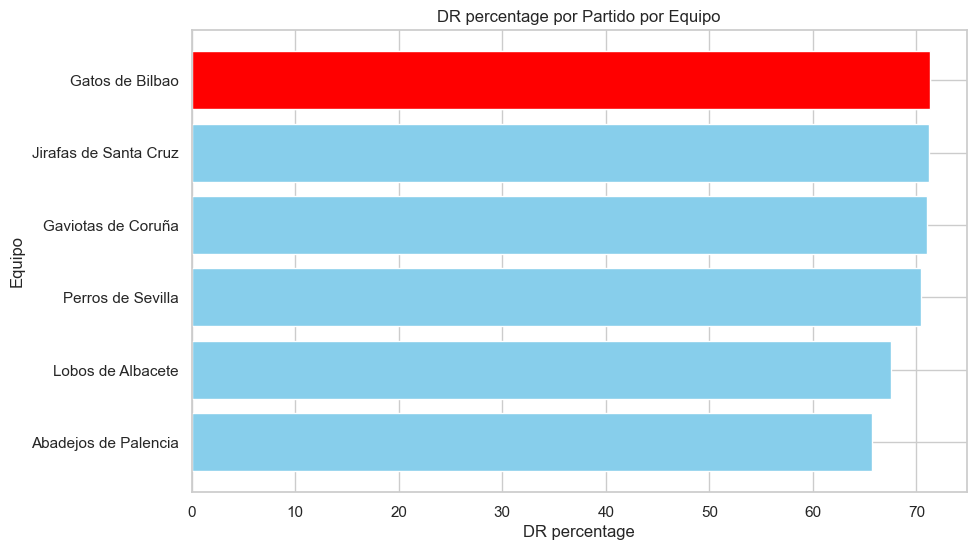

In [73]:
generarGraficoEquipo(datos_teams,equipo_de_interes,'DR_percentage')

In [74]:
datos_teams.sort_values(by='OR_percentage')['OR_percentage']


team
Gatos de Bilbao          28.712871
Jirafas de Santa Cruz    28.787879
Gaviotas de Coruña       29.000000
Perros de Sevilla        29.533679
Lobos de Albacete        32.500000
Abadejos de Palencia     34.246575
Name: OR_percentage, dtype: float64

In [75]:
datos_games_aux = datos_games.reset_index()
datos_games_aux

,partido,team,Tiempo,Tiempo_minutos,2P,2PA,3P,3PA,FT,FTA,...,DFP_percentage,POS,PLAYS,EFG,TS,TO_Percentage,OE,OER,OR_PercentageOLIVER,DR_PercentageOLIVER
0,partido1,Gaviotas de Coruña,12000,200.000000,6.0,16.0,2.0,10.0,30.0,37.0,...,73.684211,50.28,55.28,34.615385,56.764428,23.516643,0.235294,0.954654,0.294118,0.681818
1,partido1,Lobos de Albacete,9862,164.366667,9.0,19.0,3.0,11.0,12.0,21.0,...,76.190476,39.24,46.24,45.000000,49.694190,15.138408,0.400000,0.993884,0.318182,0.705882
2,partido10,Gatos de Bilbao,11795,196.583333,12.0,25.0,4.0,9.0,23.0,31.0,...,76.923077,52.64,58.64,52.941176,61.922754,18.758527,0.410256,1.120821,0.333333,0.823529
3,partido10,Gaviotas de Coruña,10552,175.866667,13.0,19.0,3.0,12.0,19.0,32.0,...,80.000000,48.08,51.08,56.451613,59.893523,11.746280,0.470588,1.123128,0.176471,0.666667
4,partido11,Abadejos de Palencia,11784,196.400000,4.0,12.0,5.0,14.0,33.0,45.0,...,76.190476,43.80,52.80,44.230769,61.135371,13.257576,0.375000,1.278539,0.391304,0.640000
5,partido11,Lobos de Albacete,10136,168.933333,8.0,14.0,4.0,13.0,16.0,24.0,...,90.000000,33.56,42.56,51.851852,58.572950,11.748120,0.521739,1.311085,0.360000,0.608696
6,partido12,Abadejos de Palencia,11826,197.100000,11.0,23.0,4.0,10.0,19.0,24.0,...,86.956522,50.56,52.56,51.515152,60.835629,17.123288,0.375000,1.048259,0.125000,0.680000
7,partido12,Gaviotas de Coruña,9600,160.000000,6.0,21.0,2.0,9.0,9.0,15.0,...,100.000000,36.60,44.60,30.000000,36.885246,17.937220,0.266667,0.737705,0.320000,0.875000
8,partido13,Abadejos de Palencia,11962,199.366667,13.0,24.0,8.0,13.0,17.0,27.0,...,88.000000,54.88,63.88,67.567568,68.535188,23.481528,0.488372,1.220845,0.428571,0.571429
9,partido13,Jirafas de Santa Cruz,11883,198.050000,15.0,23.0,8.0,18.0,21.0,28.0,...,75.000000,51.32,60.32,65.853659,70.330083,11.604775,0.589744,1.461419,0.428571,0.571429


In [76]:
partidos_gatos_bilbao = datos_games_aux[datos_games_aux['team'] == 'Gatos de Bilbao']['partido'].unique()
#partidos_gatos_bilbao
# Seleccionar los partidos completos en los que juega 'Gatos de Bilbao'
partidos_gatos_bilbao_data = datos_games_aux[datos_games_aux['partido'].isin(partidos_gatos_bilbao)]#
#partidos_gatos_bilbao_data
gatos_bilbao_data = pd.DataFrame(partidos_gatos_bilbao_data[partidos_gatos_bilbao_data['team'] == 'Gatos de Bilbao'][['partido','TR']]).reset_index()
gatos_bilbao_data

# Crear un DataFrame solo con los datos del otro equipo en los partidos seleccionados
otro_equipo_data = pd.DataFrame(partidos_gatos_bilbao_data[partidos_gatos_bilbao_data['team'] != 'Gatos de Bilbao'][['partido','TR']]).reset_index()
otro_equipo_data
data_completa_TR = pd.merge(gatos_bilbao_data, otro_equipo_data, on='partido', suffixes=('_Gatos_de_Bilbao', '_otro_equipo'))
data_completa_TR[['partido','TR_Gatos_de_Bilbao','TR_otro_equipo']]
# Comparar el número de TR entre 'Gatos de Bilbao' y el otro equipo para cada partido
#comparacion_TR = gatos_bilbao_data['TR'] > otro_equipo_data.groupby('partido')['TR'].transform('max')



,partido,TR_Gatos_de_Bilbao,TR_otro_equipo
0,partido10,20.0,15.0
1,partido15,23.0,24.0
2,partido20,19.0,18.0
3,partido25,22.0,18.0
4,partido26,22.0,15.0
5,partido27,19.0,20.0
6,partido28,22.0,25.0
7,partido29,20.0,11.0
8,partido30,15.0,17.0
9,partido5,20.0,21.0


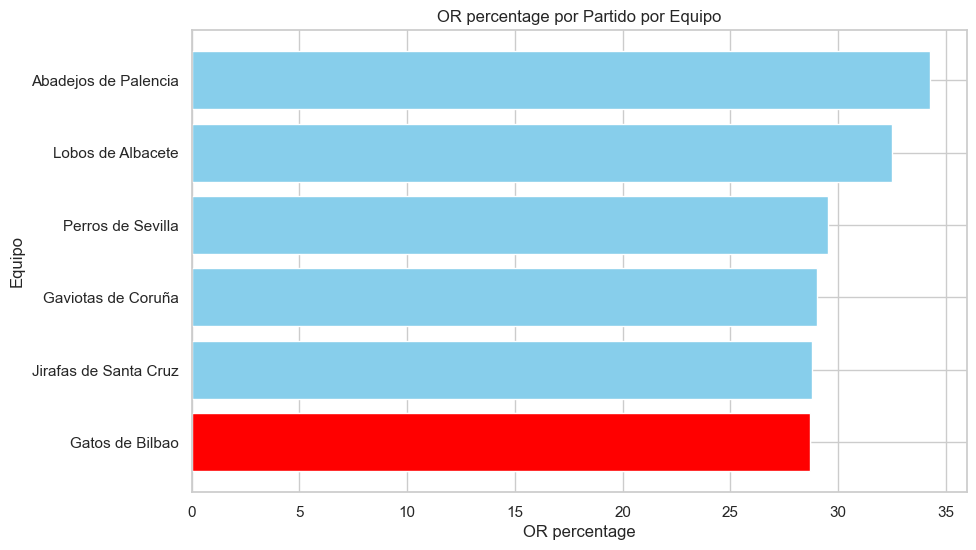

In [77]:
generarGraficoEquipo(datos_teams,equipo_de_interes,'OR_percentage')

In [78]:
datos_teams['FT_percentage'] = datos_teams['FT'] / datos_teams['FTA'] * 100
datos_teams.sort_values(by='FT_percentage')

,Tiempo,Tiempo_minutos,2P,2PA,3P,3PA,FT,FTA,TR,OR,...,POS,PLAYS,EFG,TS,TO_Percentage,OE,OER,Puntos_por_partido,Puntos_por_tiro,FT_percentage
team,,,,,,,,,,,,,,,,,,,,,
Jirafas de Santa Cruz,113538,1892.300000,116.0,221.0,50.0,109.0,210.0,297.0,198.0,57.0,...,511.68,568.68,57.878788,64.252844,18.991348,0.435696,1.156973,59.2,0.944179,70.707071
Gaviotas de Coruña,108558,1809.300000,90.0,179.0,45.0,130.0,192.0,267.0,200.0,58.0,...,465.48,523.48,50.970874,59.440068,18.529839,0.387931,1.089198,50.7,0.880208,71.910112
Abadejos de Palencia,116596,1943.266667,97.0,194.0,52.0,146.0,237.0,312.0,219.0,75.0,...,495.28,570.28,51.470588,61.494301,16.307779,0.416201,1.185188,58.7,0.900307,75.961538
Perros de Sevilla,114130,1902.166667,111.0,195.0,48.0,132.0,215.0,283.0,193.0,57.0,...,498.52,555.52,55.963303,64.338235,18.721198,0.425134,1.165450,58.1,0.952459,75.971731
Lobos de Albacete,110913,1848.550000,85.0,170.0,59.0,141.0,241.0,316.0,200.0,65.0,...,478.04,543.04,55.787781,65.327526,17.125810,0.424779,1.230023,58.8,0.937799,76.265823
Gatos de Bilbao,116757,1945.950000,109.0,204.0,46.0,130.0,217.0,276.0,202.0,58.0,...,498.44,556.44,53.293413,62.906201,18.151103,0.411141,1.149587,57.3,0.939344,78.623188


In [79]:
datos_teams['3P_percentage'] = datos_teams['3P'] / datos_teams['3PA'] * 100
datos_teams.sort_values(by='3P_percentage')

,Tiempo,Tiempo_minutos,2P,2PA,3P,3PA,FT,FTA,TR,OR,...,PLAYS,EFG,TS,TO_Percentage,OE,OER,Puntos_por_partido,Puntos_por_tiro,FT_percentage,3P_percentage
team,,,,,,,,,,,,,,,,,,,,,
Gaviotas de Coruña,108558,1809.300000,90.0,179.0,45.0,130.0,192.0,267.0,200.0,58.0,...,523.48,50.970874,59.440068,18.529839,0.387931,1.089198,50.7,0.880208,71.910112,34.615385
Gatos de Bilbao,116757,1945.950000,109.0,204.0,46.0,130.0,217.0,276.0,202.0,58.0,...,556.44,53.293413,62.906201,18.151103,0.411141,1.149587,57.3,0.939344,78.623188,35.384615
Abadejos de Palencia,116596,1943.266667,97.0,194.0,52.0,146.0,237.0,312.0,219.0,75.0,...,570.28,51.470588,61.494301,16.307779,0.416201,1.185188,58.7,0.900307,75.961538,35.616438
Perros de Sevilla,114130,1902.166667,111.0,195.0,48.0,132.0,215.0,283.0,193.0,57.0,...,555.52,55.963303,64.338235,18.721198,0.425134,1.165450,58.1,0.952459,75.971731,36.363636
Lobos de Albacete,110913,1848.550000,85.0,170.0,59.0,141.0,241.0,316.0,200.0,65.0,...,543.04,55.787781,65.327526,17.125810,0.424779,1.230023,58.8,0.937799,76.265823,41.843972
Jirafas de Santa Cruz,113538,1892.300000,116.0,221.0,50.0,109.0,210.0,297.0,198.0,57.0,...,568.68,57.878788,64.252844,18.991348,0.435696,1.156973,59.2,0.944179,70.707071,45.871560


Quiero estudiar si nuestros datos muestran una relación natural como sería que a mayor número de rebotes ofensivos, hay un mayor número de puntos anotados.

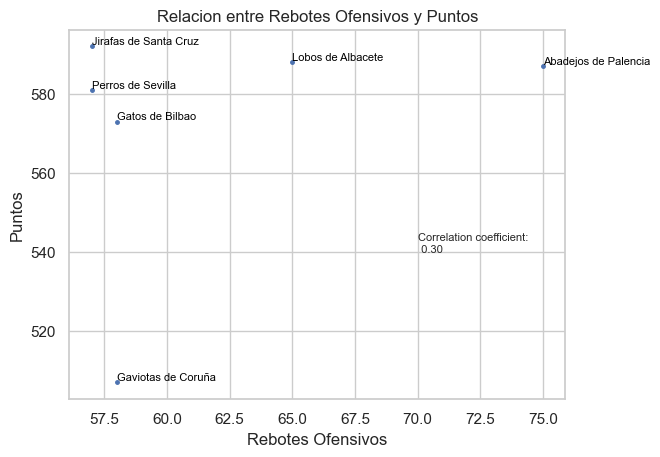

In [80]:
# Crear el gráfico de dispersión ENTRE LAS VARIABLES REBOTES OFENSIVO Y PUNTOS
plt.figure()
plt.title('Relacion entre Rebotes Ofensivos y Puntos')
plt.xlabel('Rebotes Ofensivos')
plt.ylabel('Puntos')

# Graficar los puntos
plt.plot(datos_teams['OR'], datos_teams['PTS'], marker='.', markersize=5., linewidth=0)

# Dibujar la diagonal
# plt.plot([0, 20], [0, 20], linestyle='--', color='red')
correlation_coefficient, _ = pearsonr(datos_teams['OR'], datos_teams['PTS'])

# Mostrar el coeficiente de correlación en el gráfico
plt.text(70, 540, f'Correlation coefficient:\n {correlation_coefficient:.2f}', fontsize=8)

# Etiquetar los puntos que cumplen con las condiciones
for index, row in datos_teams.iterrows():
    color = 'red' if index == 'Ciervos de Palencia' else 'black'
    plt.text(row['OR'], row['PTS'], index, fontsize=8, verticalalignment='bottom', color=color)

# Mostrar el gráfico
plt.show()

In [81]:
datos_players_aux = comparadorParametro(datos_players,'EFG',datos_players['EFG'].mean(),'Comparador_EFG')
datos_players_aux

,player,team,Tiempo,Tiempo_minutos,2P,2PA,3P,3PA,FT,FTA,...,DFP_percentage,POS,PLAYS,EFG,TS,TO_Percentage,OE,OER,Usage_rate,Comparador_EFG
0,Adelina Zaragoza,Jirafas de Santa Cruz,3522,58.700000,4.0,6.0,1.0,2.0,2.0,5.0,...,100.000000,12.20,13.20,68.750000,63.725490,22.727273,0.500000,1.065574,14.965384,Superior a 50.71
1,Adoración Ariño,Lobos de Albacete,18568,309.466667,20.0,37.0,9.0,22.0,39.0,47.0,...,87.500000,83.68,91.68,56.779661,66.516064,13.089005,0.460317,1.266730,20.169267,Superior a 50.71
2,Alejandra Corral,Gaviotas de Coruña,19307,321.783333,24.0,33.0,8.0,26.0,27.0,38.0,...,80.000000,75.72,88.72,61.016949,65.372425,14.652840,0.542373,1.307448,19.058928,Superior a 50.71
3,Alondra Prieto,Perros de Sevilla,2801,46.683333,3.0,6.0,1.0,5.0,5.0,6.0,...,50.000000,16.64,18.64,40.909091,51.319648,26.824034,0.285714,0.841346,27.344055,Inferior a 50.71
4,Amor Angulo,Jirafas de Santa Cruz,2944,49.066667,5.0,8.0,2.0,3.0,4.0,5.0,...,100.000000,16.20,16.20,72.727273,75.757576,18.518519,0.500000,1.234568,21.972551,Superior a 50.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Vilma Benavent,Lobos de Albacete,4480,74.666667,2.0,7.0,3.0,5.0,10.0,13.0,...,85.714286,19.72,21.72,54.166667,64.898420,18.416206,0.357143,1.166329,19.804434,Superior a 50.71
68,Ximena Pera,Gaviotas de Coruña,6172,102.866667,4.0,11.0,2.0,8.0,3.0,7.0,...,100.000000,26.08,27.08,36.842105,38.496377,18.463811,0.260870,0.651840,18.197615,Inferior a 50.71
69,Zaira Izaguirre,Gatos de Bilbao,3185,53.083333,2.0,3.0,2.0,6.0,9.0,11.0,...,77.777778,14.84,17.84,55.555556,68.641618,22.421525,0.400000,1.280323,23.506068,Superior a 50.71
70,Ágata Ibañez,Abadejos de Palencia,613,10.216667,0.0,0.0,0.0,0.0,1.0,2.0,...,100.000000,0.88,1.88,0.000000,56.818182,53.191489,0.000000,1.136364,12.540732,Inferior a 50.71


In [82]:
# Definimos una funcion genérica para hacer gráficos de barras, en el que los inputs son
# un data frame, el parametro que analizamos, y un variable categorica que nos indica si un jugador esta por encima o por debajo de la media del parametro. Esta parte la hacemos con una 
# función definida previamente como comparadorParametro
# devuelve un grafico de barras para cada equipo, con las jugadoras ordenadas de menor a mayor, con diferente color si estan por encima o por debajo de la media, y la media del parametro se muestra como 
# una linea horizontal

def graficoBarrasJugadoresPorEquipo(datos_players_aux,parametro_analizar,variableComparacion):
    # Ordenar los datos por equipo y luego por EFG
    datos_players_aux = datos_players_aux.sort_values(by=['team', parametro_analizar])
    media = datos_players_aux[parametro_analizar].mean()
    # Obtener las categorías únicas de la variable Comparador_EFG
    categorias_comparador = datos_players_aux[variableComparacion].unique()

    # Definir los colores para cada categoría de Comparador_EFG
    color_dict = {categoria: 'red' if categoria == categorias_comparador[0] else 'green' for categoria in categorias_comparador}

    # Dividir los datos en grupos según el equipo
    grupos_por_equipo = datos_players_aux.groupby('team')

    # Calcular el número de equipos
    num_equipos = len(grupos_por_equipo)

    # Crear subgráficos para cada equipo
    fig, axs = plt.subplots(2, 3, figsize=(18, 12), sharey=True)

    # Título común para todos los subgráficos
    fig.suptitle(f"Media {parametro_analizar} por Jugadora")

    # Crear una leyenda personalizada fuera del bucle
    handles = [mpatches.Patch(color=color_dict[categoria], label=categoria) for categoria in categorias_comparador]
    handles.append(mpatches.Patch(color='gray', linestyle='--', label='Media de todos los jugadores'))
    fig.legend(handles=handles, fontsize=12, loc='upper right')

    # Iterar sobre los grupos y dibujar un gráfico para cada uno
    for i, (equipo, datos_equipo) in enumerate(grupos_por_equipo):
        fila = i // 3
        columna = i % 3
        ax = axs[fila, columna]
        # Crear el gráfico de barras para el equipo actual
        ax.bar(datos_equipo['player'], datos_equipo[parametro_analizar], color=[color_dict[c] for c in datos_equipo[variableComparacion]])
        # Mostrar la línea horizontal en la media
        ax.axhline(y=media, color='gray', linestyle='--', linewidth=2, label='Media')
        # Añadir etiqueta al eje y (solo en el primer subgráfico de cada fila)
        if columna == 0:
            ax.set_ylabel(parametro_analizar)
        # Resaltar los nombres de las jugadoras de tu equipo pintándolos de rojo en el eje horizontal
        for label, es_mi_equipo, _ in zip(ax.xaxis.get_ticklabels(), datos_equipo['team'] == equipo, datos_equipo['team']):
            if es_mi_equipo:
                label.set_color('red')
                label.set_text(label.get_text() + '\n' + equipo)
                label.set_verticalalignment('top')  # Alinea el texto hacia arriba
        # Ajustes adicionales
        ax.set_title(f'Equipo: {equipo}')
    #ax.legend(handles=handles)
        ax.tick_params(axis='x', rotation=90)

    # Mostrar los subgráficos
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()


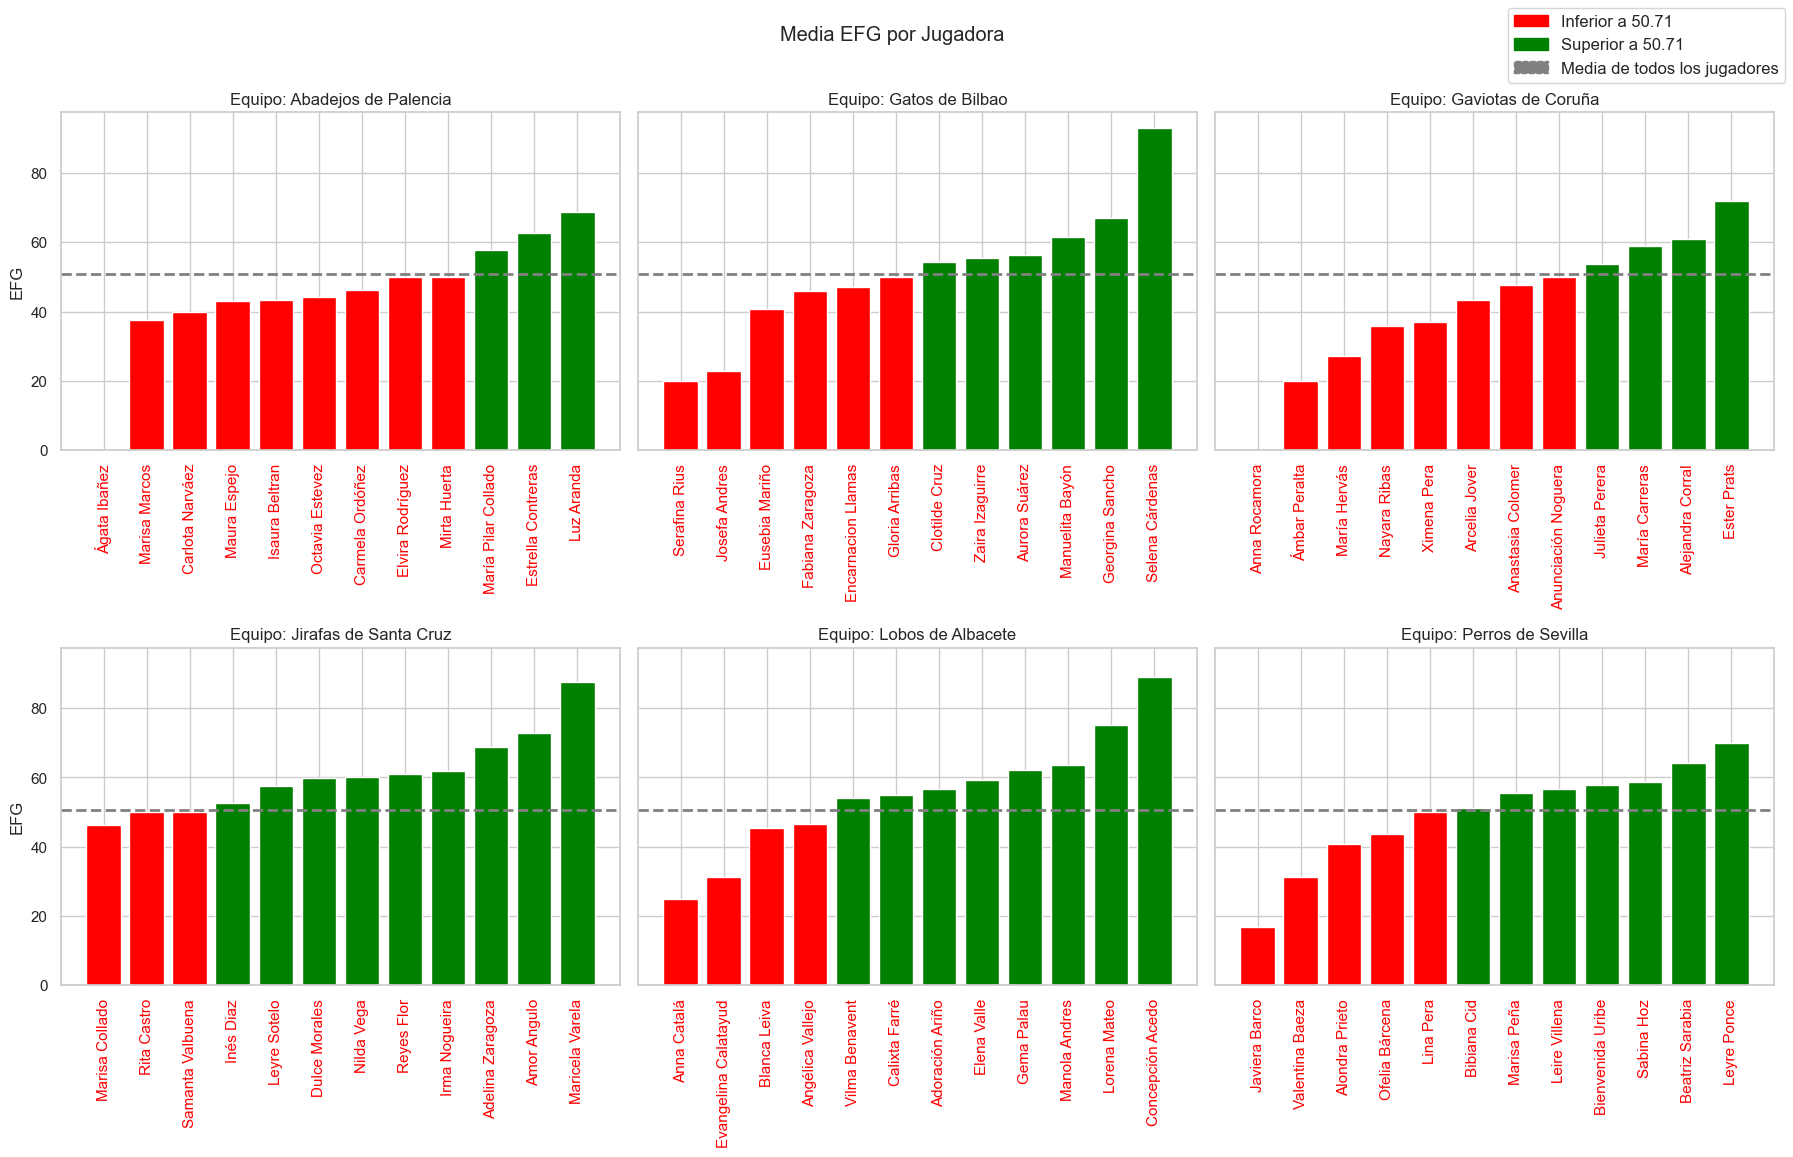

In [83]:
graficoBarrasJugadoresPorEquipo(datos_players_aux,'EFG','Comparador_EFG')

In [84]:
datos_players_aux = datos_players_aux.sort_values(by=['EFG'],ascending=False)
datos_players_aux

,player,team,Tiempo,Tiempo_minutos,2P,2PA,3P,3PA,FT,FTA,...,DFP_percentage,POS,PLAYS,EFG,TS,TO_Percentage,OE,OER,Usage_rate,Comparador_EFG
64,Selena Cárdenas,Gatos de Bilbao,3825,63.750000,2.0,4.0,3.0,3.0,3.0,3.0,...,50.000000,12.32,12.32,92.857143,96.153846,32.467532,0.454545,1.298701,13.516799,Superior a 50.71
20,Concepción Acedo,Lobos de Albacete,2661,44.350000,5.0,5.0,2.0,4.0,15.0,19.0,...,88.888889,18.36,20.36,88.888889,89.285714,14.734774,0.700000,1.688453,31.254570,Superior a 50.71
47,Maricela Varela,Jirafas de Santa Cruz,2482,41.366667,2.0,3.0,1.0,1.0,0.0,0.0,...,60.000000,2.00,6.00,87.500000,87.500000,33.333333,1.500000,3.500000,9.652788,Superior a 50.71
43,Lorena Mateo,Lobos de Albacete,1926,32.100000,0.0,1.0,1.0,1.0,0.0,0.0,...,75.000000,2.00,3.00,75.000000,75.000000,33.333333,0.500000,1.500000,6.362761,Superior a 50.71
4,Amor Angulo,Jirafas de Santa Cruz,2944,49.066667,5.0,8.0,2.0,3.0,4.0,5.0,...,100.000000,16.20,16.20,72.727273,75.757576,18.518519,0.500000,1.234568,21.972551,Superior a 50.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,Ámbar Peralta,Gaviotas de Coruña,1384,23.066667,1.0,4.0,0.0,1.0,0.0,0.0,...,100.000000,7.00,8.00,20.000000,20.000000,37.500000,0.142857,0.285714,23.974283,Inferior a 50.71
65,Serafina Rius,Gatos de Bilbao,2310,38.500000,1.0,3.0,0.0,2.0,3.0,4.0,...,55.555556,8.76,9.76,20.000000,36.982249,30.737705,0.142857,0.570776,17.730967,Inferior a 50.71
36,Javiera Barco,Perros de Sevilla,3266,54.433333,1.0,4.0,0.0,2.0,5.0,6.0,...,57.142857,12.64,12.64,16.666667,40.509259,31.645570,0.100000,0.553797,15.902339,Inferior a 50.71
8,Anna Rocamora,Gaviotas de Coruña,2245,37.416667,0.0,0.0,0.0,3.0,7.0,10.0,...,85.714286,10.40,10.40,0.000000,47.297297,28.846154,0.000000,0.673077,19.213599,Inferior a 50.71


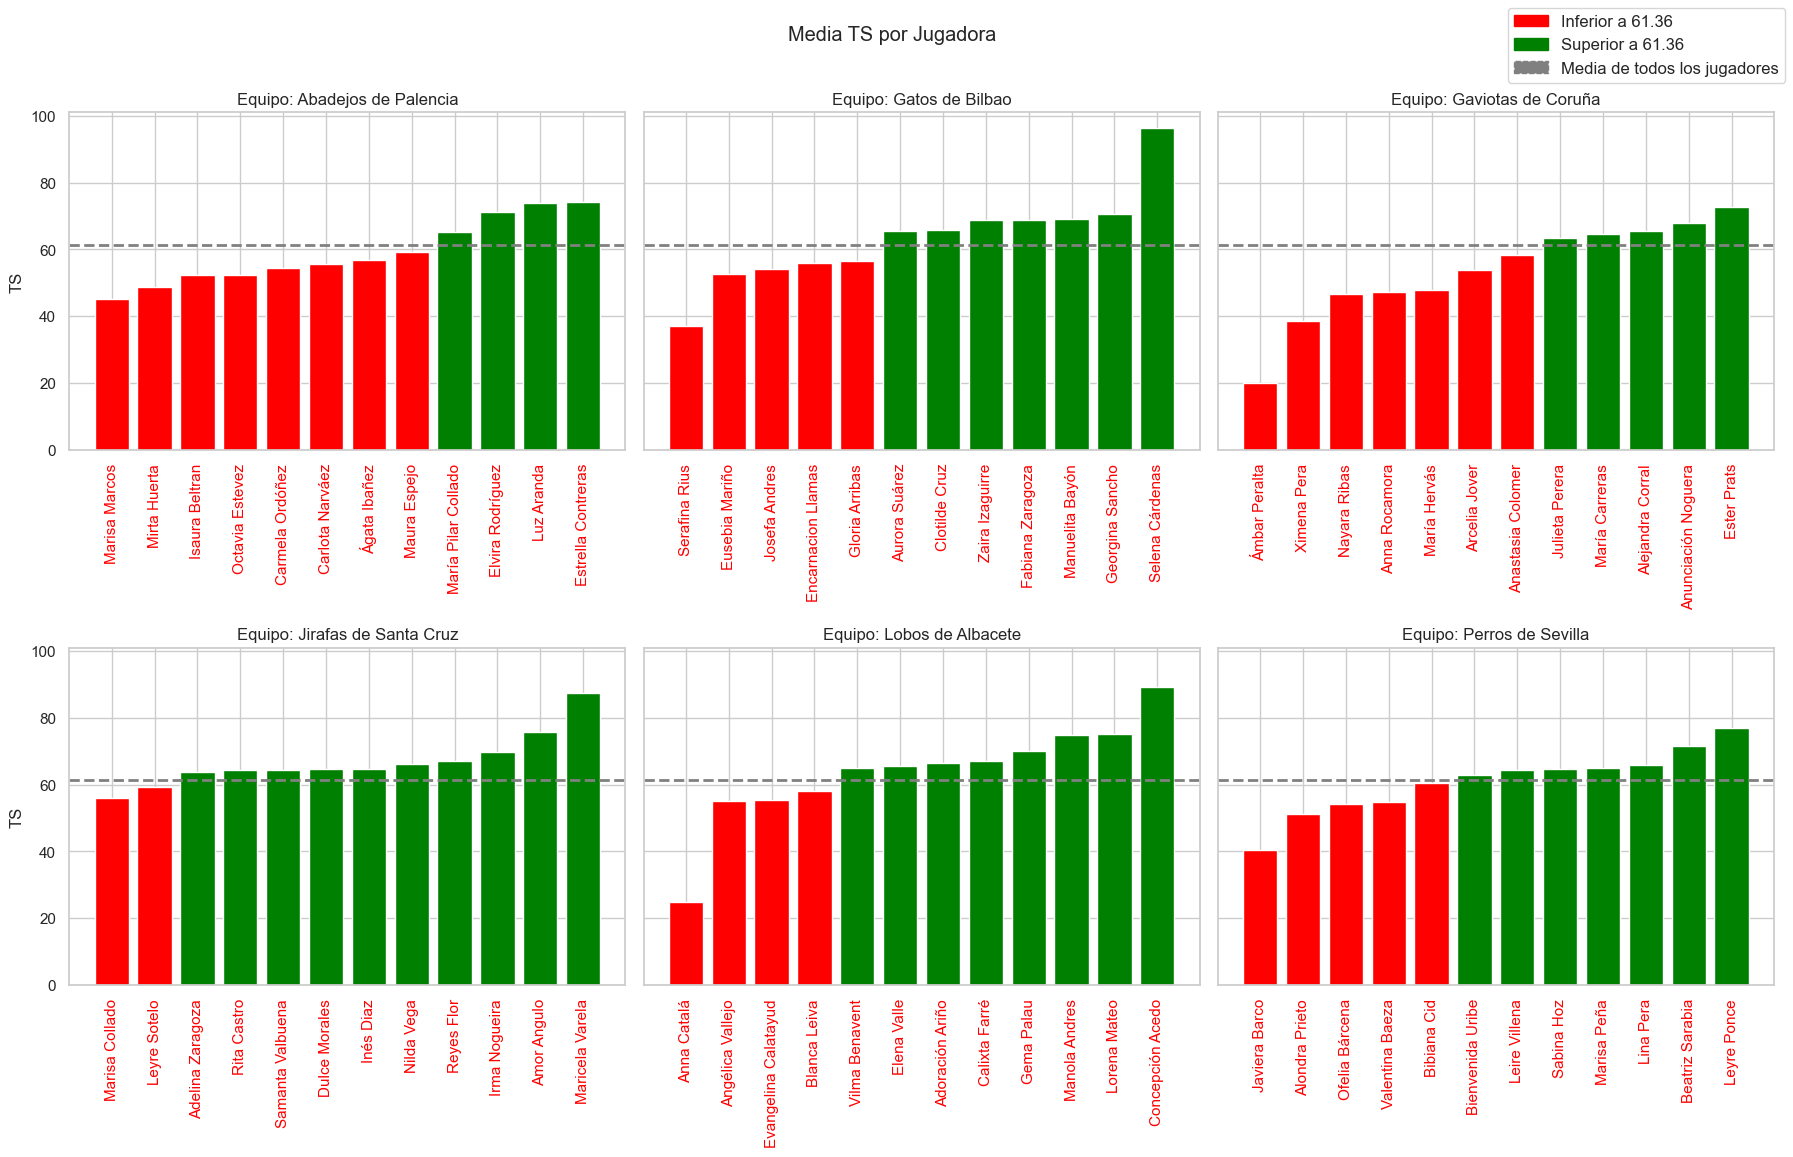

In [85]:
datos_players_aux = comparadorParametro(datos_players,'TS',datos_players['TS'].mean(),'Comparador_TS')
graficoBarrasJugadoresPorEquipo(datos_players_aux,'TS','Comparador_TS')

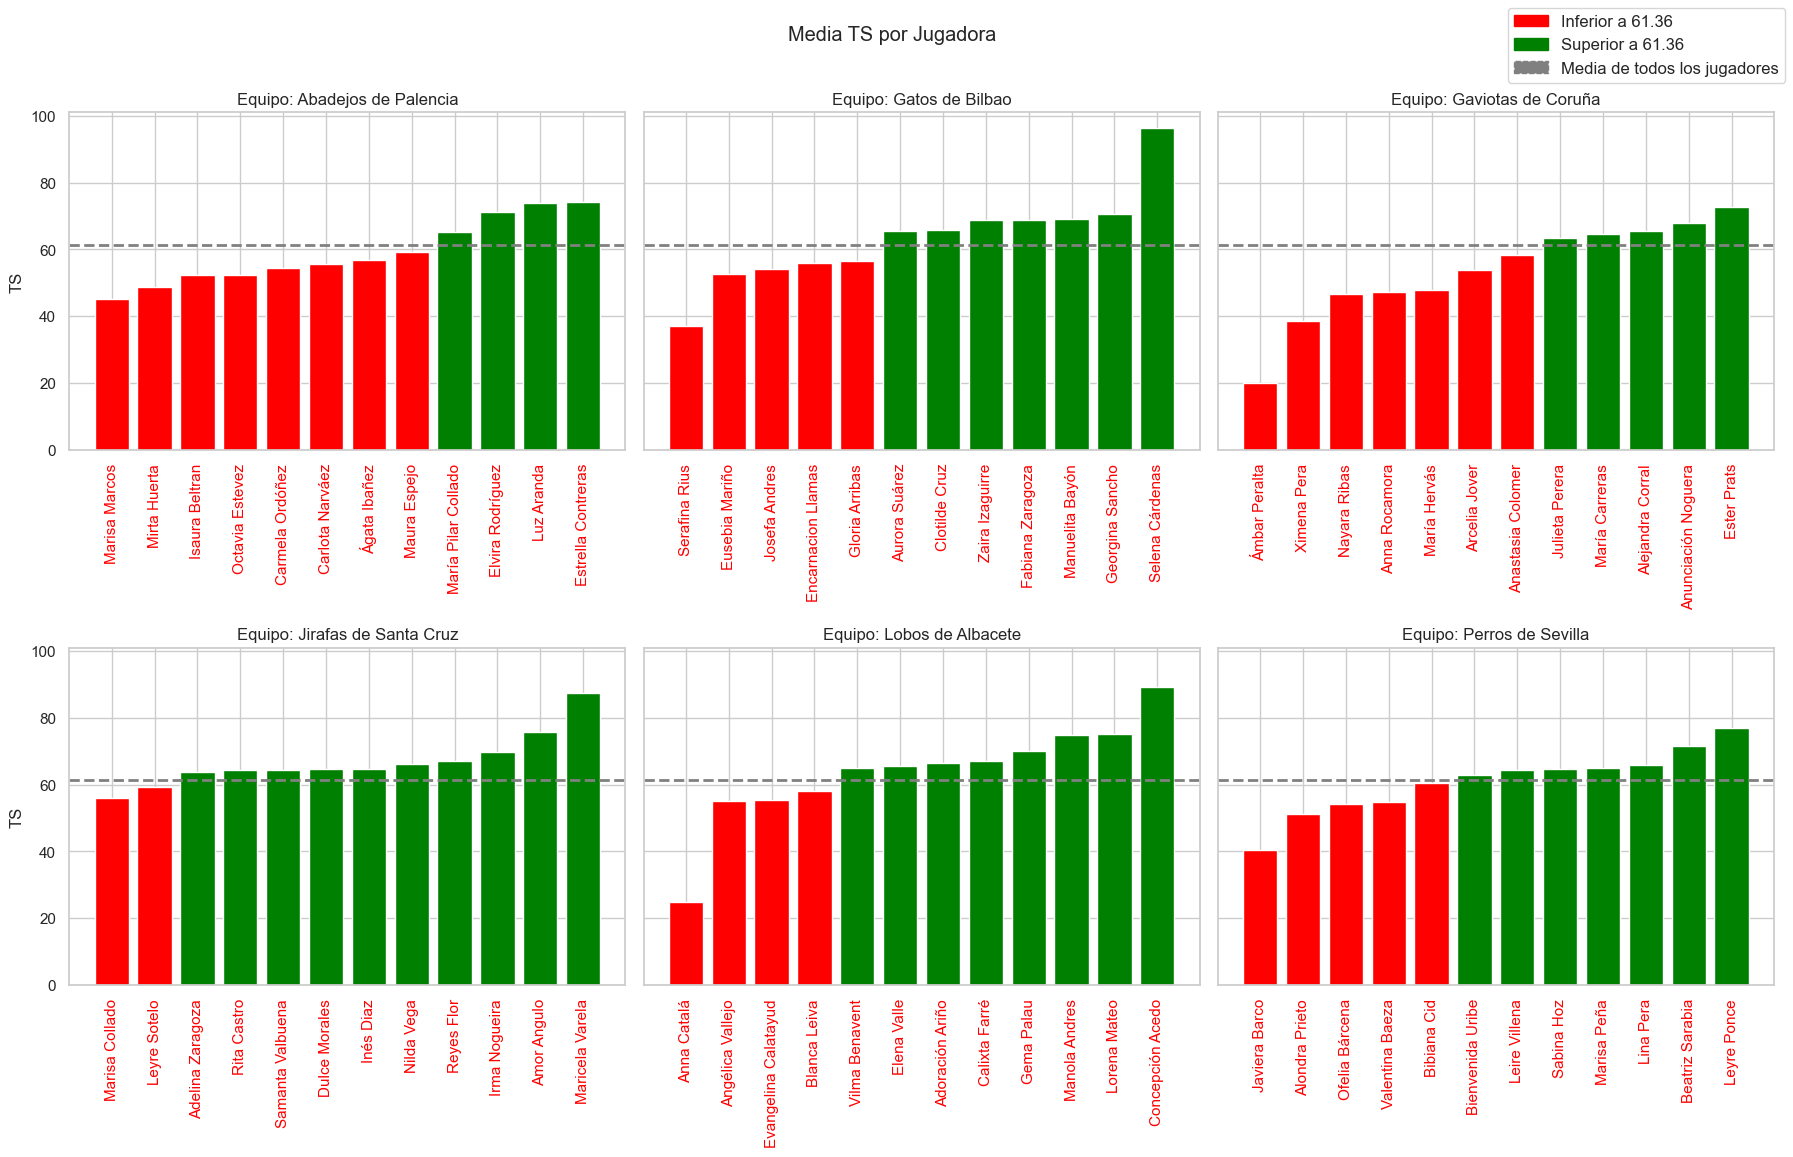

In [86]:
datos_players_aux = comparadorParametro(datos_players,'TS',datos_players['TS'].mean(),'Comparador_TS')
graficoBarrasJugadoresPorEquipo(datos_players_aux,'TS','Comparador_TS')

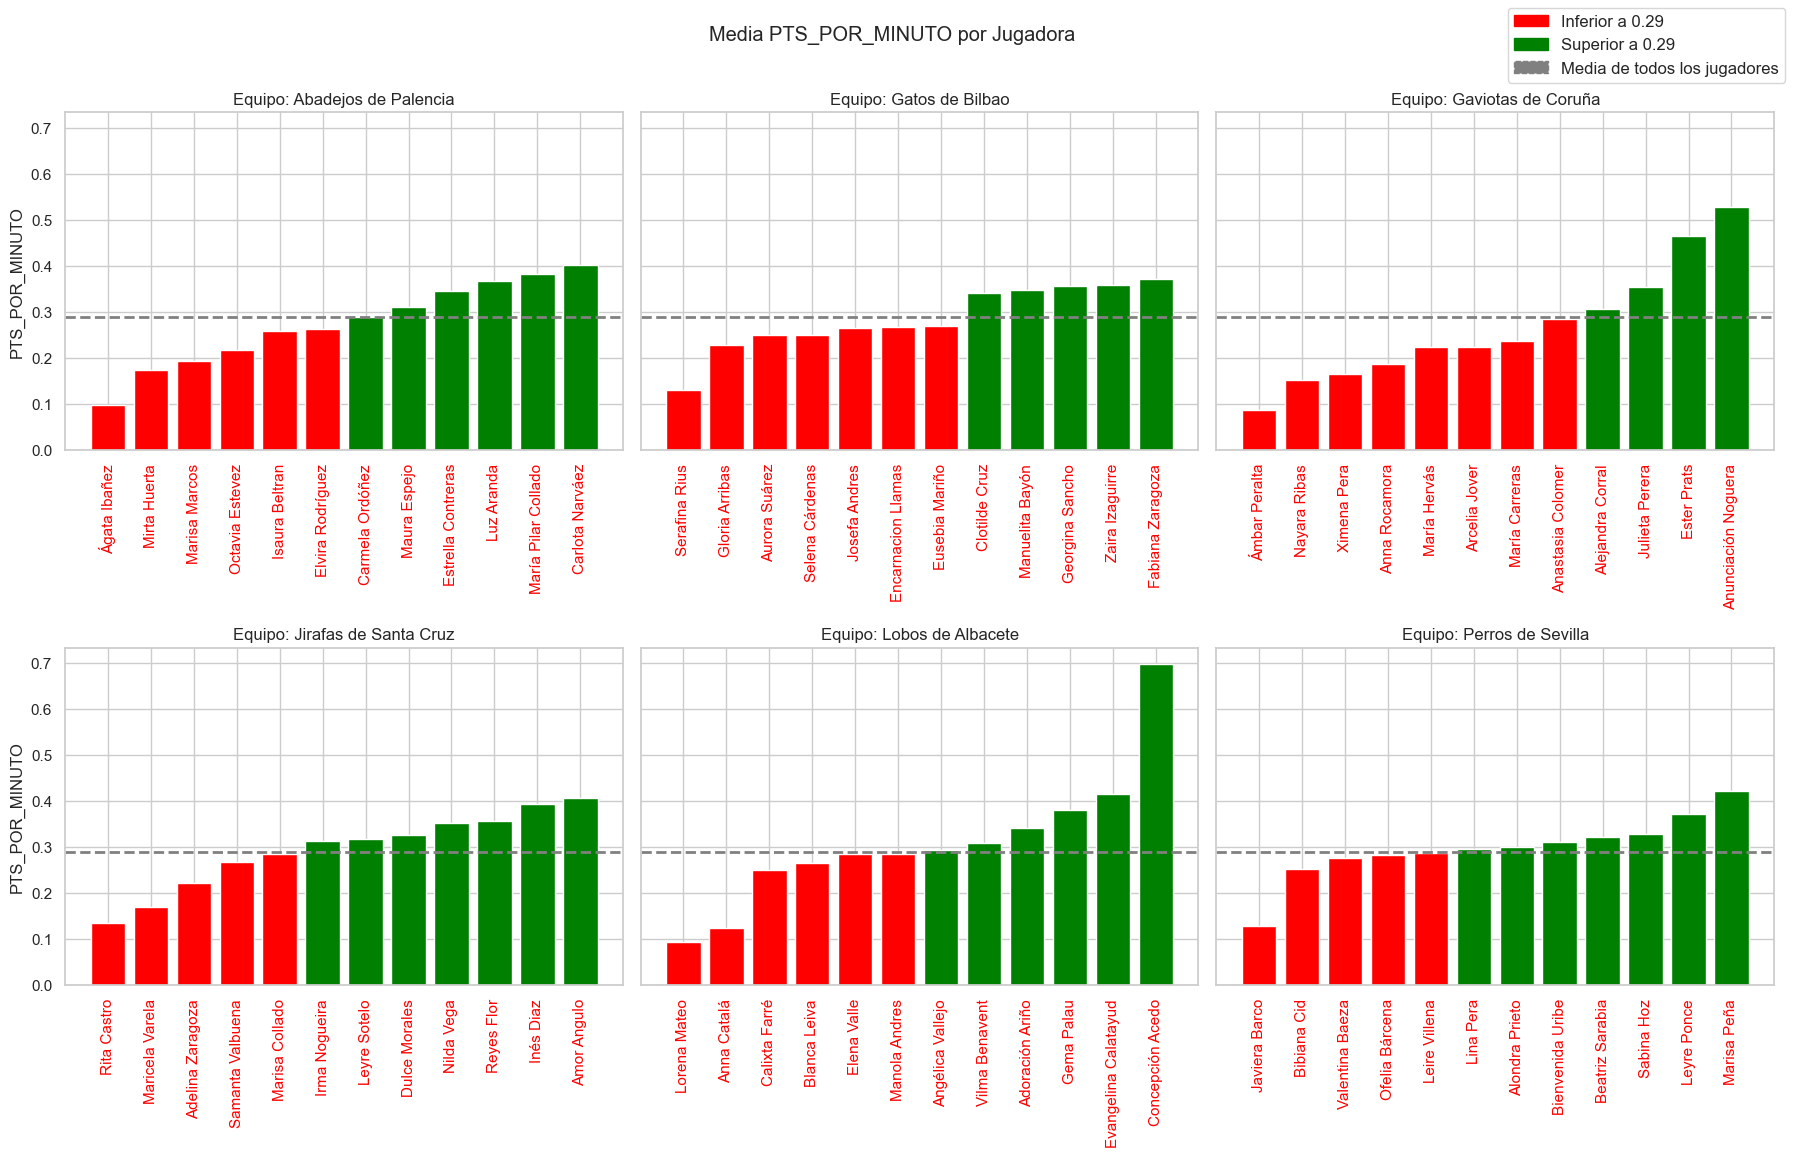

In [87]:
datos_players['PTS_POR_MINUTO'] = datos_players['PTS'] / datos_players['Tiempo_minutos']
datos_players_aux = comparadorParametro(datos_players,'PTS_POR_MINUTO',datos_players['PTS_POR_MINUTO'].mean(),'Comparador_PTS_POR_MINUTO')
graficoBarrasJugadoresPorEquipo(datos_players_aux,'PTS_POR_MINUTO','Comparador_PTS_POR_MINUTO')

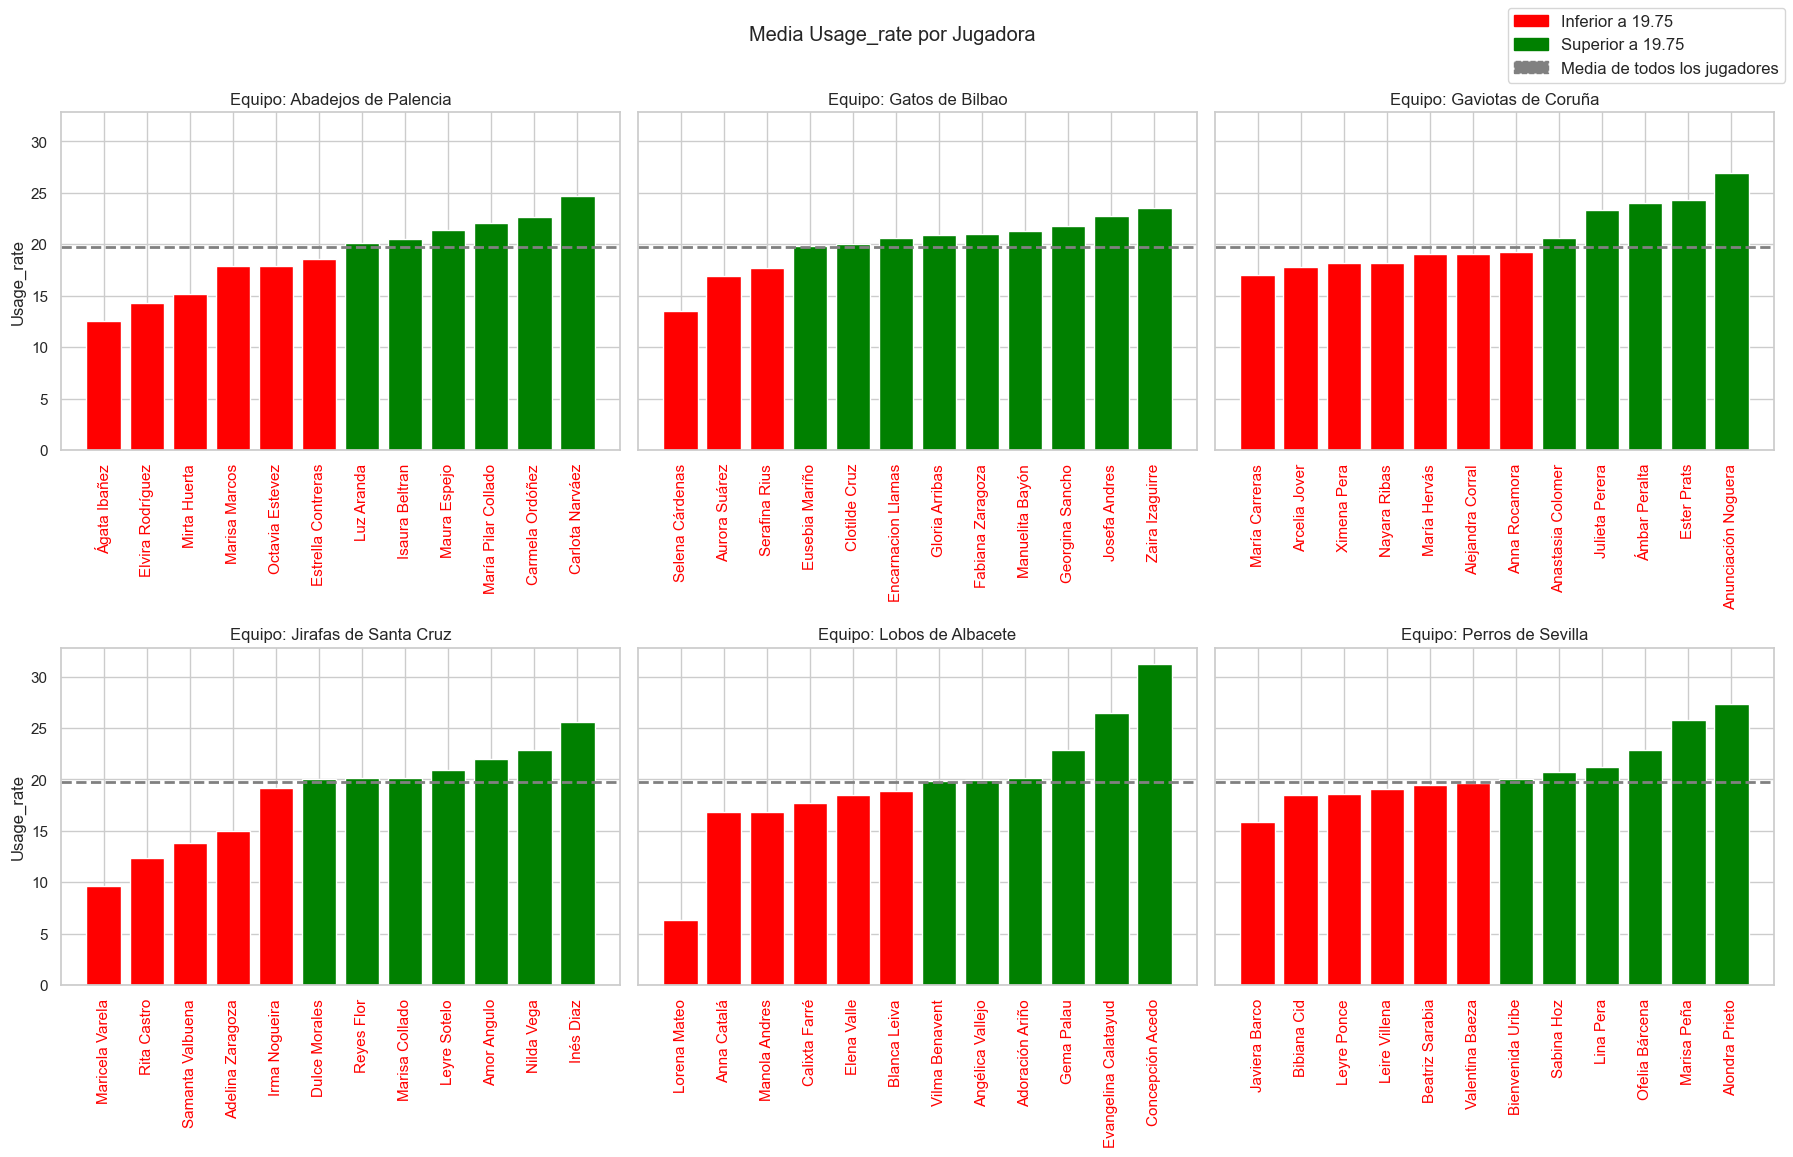

In [88]:

datos_players_aux = comparadorParametro(datos_players,'Usage_rate',datos_players['Usage_rate'].mean(),'Comparador_Usage_rate')
graficoBarrasJugadoresPorEquipo(datos_players_aux,'Usage_rate','Comparador_Usage_rate')


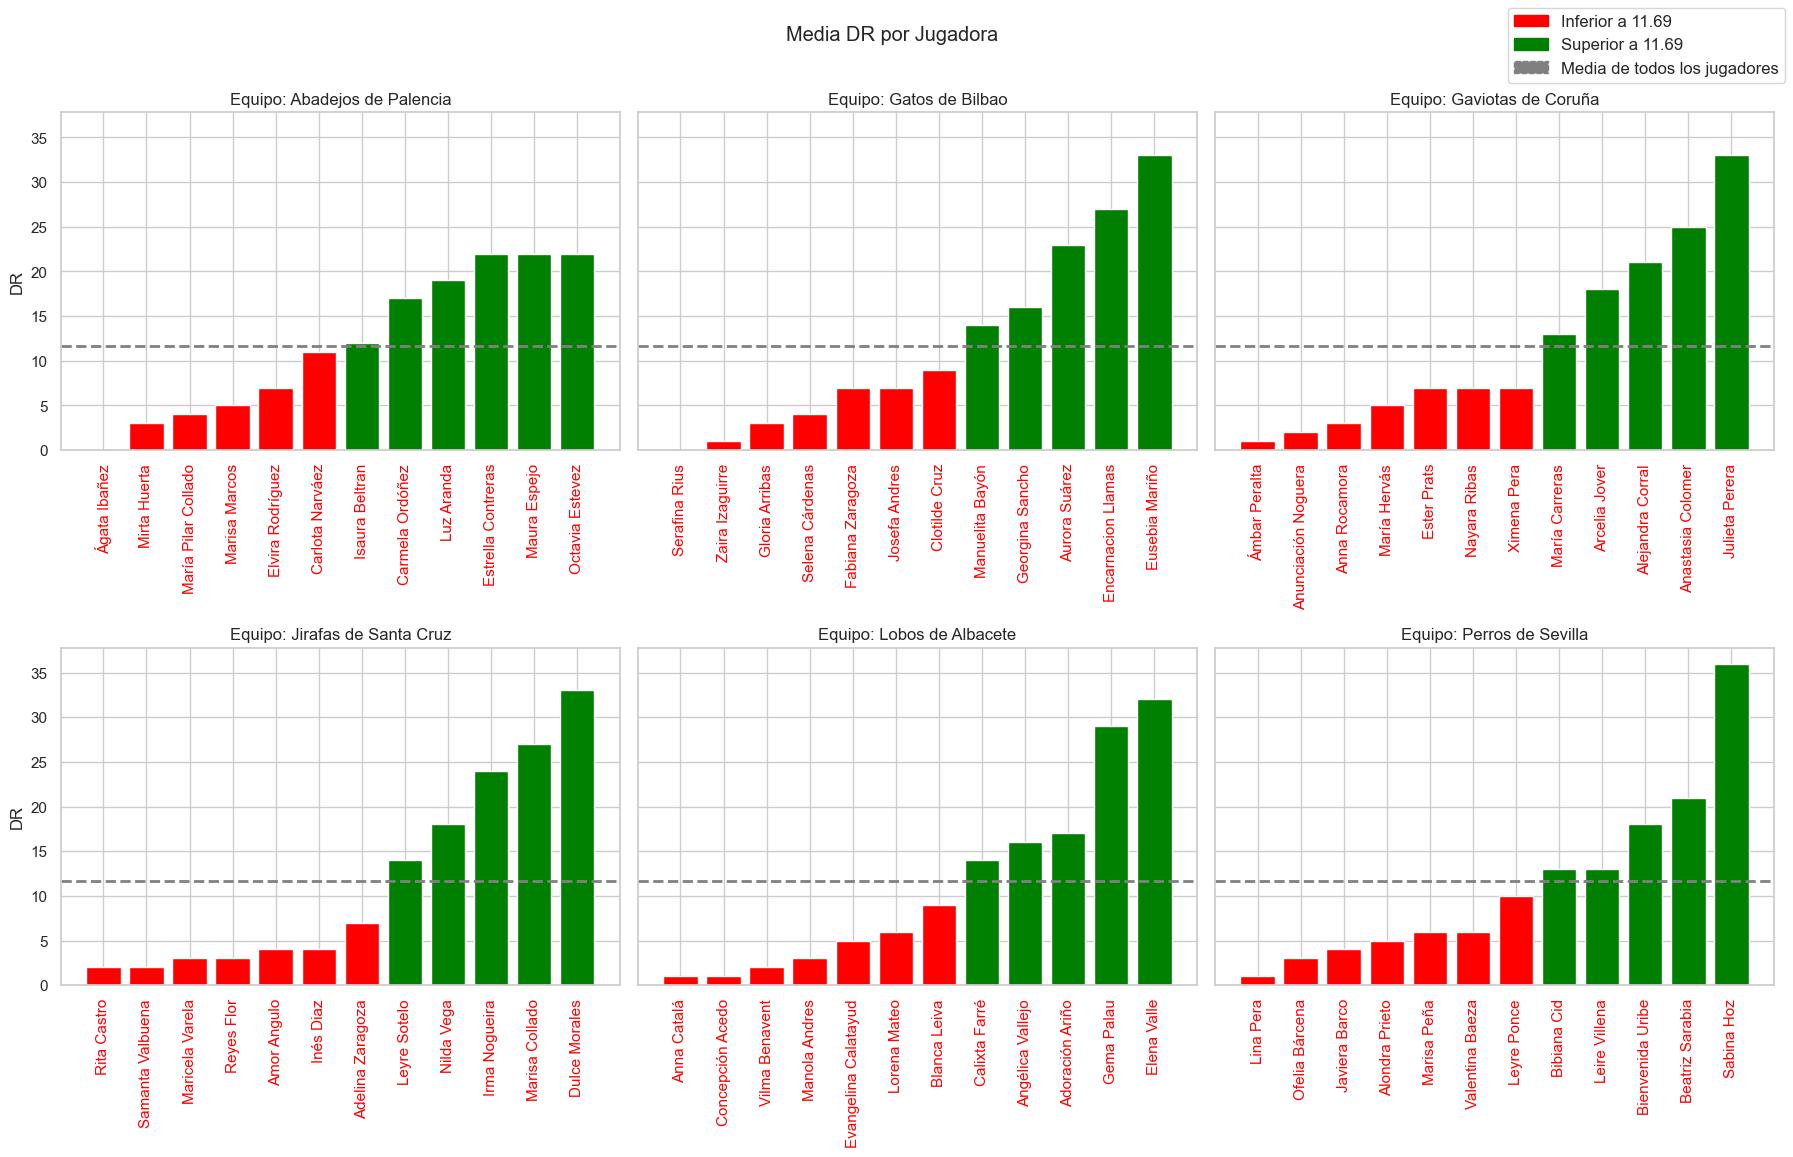

In [89]:
datos_players_aux = comparadorParametro(datos_players,'DR',datos_players['DR'].mean(),'Comparador_DR')
graficoBarrasJugadoresPorEquipo(datos_players_aux,'DR','Comparador_DR')


In [90]:
datos_players.sort_values(by='EFG',ascending=False)


,player,team,Tiempo,Tiempo_minutos,2P,2PA,3P,3PA,FT,FTA,...,TO_Percentage,OE,OER,Usage_rate,Comparador_EFG,Comparador_TS,PTS_POR_MINUTO,Comparador_PTS_POR_MINUTO,Comparador_Usage_rate,Comparador_DR
64,Selena Cárdenas,Gatos de Bilbao,3825,63.750000,2.0,4.0,3.0,3.0,3.0,3.0,...,32.467532,0.454545,1.298701,13.516799,Superior a 50.71,Superior a 61.36,0.250980,Inferior a 0.29,Inferior a 19.75,Inferior a 11.69
20,Concepción Acedo,Lobos de Albacete,2661,44.350000,5.0,5.0,2.0,4.0,15.0,19.0,...,14.734774,0.700000,1.688453,31.254570,Superior a 50.71,Superior a 61.36,0.698985,Superior a 0.29,Superior a 19.75,Inferior a 11.69
47,Maricela Varela,Jirafas de Santa Cruz,2482,41.366667,2.0,3.0,1.0,1.0,0.0,0.0,...,33.333333,1.500000,3.500000,9.652788,Superior a 50.71,Superior a 61.36,0.169218,Inferior a 0.29,Inferior a 19.75,Inferior a 11.69
43,Lorena Mateo,Lobos de Albacete,1926,32.100000,0.0,1.0,1.0,1.0,0.0,0.0,...,33.333333,0.500000,1.500000,6.362761,Superior a 50.71,Superior a 61.36,0.093458,Inferior a 0.29,Inferior a 19.75,Inferior a 11.69
4,Amor Angulo,Jirafas de Santa Cruz,2944,49.066667,5.0,8.0,2.0,3.0,4.0,5.0,...,18.518519,0.500000,1.234568,21.972551,Superior a 50.71,Superior a 61.36,0.407609,Superior a 0.29,Superior a 19.75,Inferior a 11.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,Ámbar Peralta,Gaviotas de Coruña,1384,23.066667,1.0,4.0,0.0,1.0,0.0,0.0,...,37.500000,0.142857,0.285714,23.974283,Inferior a 50.71,Inferior a 61.36,0.086705,Inferior a 0.29,Superior a 19.75,Inferior a 11.69
65,Serafina Rius,Gatos de Bilbao,2310,38.500000,1.0,3.0,0.0,2.0,3.0,4.0,...,30.737705,0.142857,0.570776,17.730967,Inferior a 50.71,Inferior a 61.36,0.129870,Inferior a 0.29,Inferior a 19.75,Inferior a 11.69
36,Javiera Barco,Perros de Sevilla,3266,54.433333,1.0,4.0,0.0,2.0,5.0,6.0,...,31.645570,0.100000,0.553797,15.902339,Inferior a 50.71,Inferior a 61.36,0.128598,Inferior a 0.29,Inferior a 19.75,Inferior a 11.69
8,Anna Rocamora,Gaviotas de Coruña,2245,37.416667,0.0,0.0,0.0,3.0,7.0,10.0,...,28.846154,0.000000,0.673077,19.213599,Inferior a 50.71,Inferior a 61.36,0.187082,Inferior a 0.29,Inferior a 19.75,Inferior a 11.69
